# Expression of genes DE between neighbouring stages
Genes whose expression changes strongly between two neighbouring stages were selected with two different methods (described below). These methods also ensure that genes do not change between many neighbouring stages.

In [ ]:
library(ComplexHeatmap)
library(circlize)
library(viridis)
library(proxy)
library(seriation)
library(dendextend)
options(repr.plot.width=15, repr.plot.height=10)
library(dplyr)

In [13]:
#**! Paths where expression data (average expression, expression patterns, expression height), strain order,
#** regulons clusters, and phenotipic data are saved
path_expression='/home/karin/Documents/timeTrajectories/data/stages/'
path_strain_order='/home/karin/Documents/timeTrajectories/data/'
path_phenotypes = '/home/karin/Documents/timeTrajectories/data/stages/'
pathImpulse='/home/karin/Documents/timeTrajectories/data/stages/DE_across_stages/'
pathDeseq='/home/karin/Documents/timeTrajectories/data/deTime/neighbouring/'

In [21]:
#**! Specify file names for regulons and expression
#** Expression tab file: Genes in columns (already scaled), averaged strain data in rows, 
#** three additional comlumns: Time, Strain, and Group (meaning strain group)
avg_expression=read.table(paste(path_expression,"genes_averaged_orange_mainStage_scale99percentileMax0.1.tsv",sep=''),
                          header=TRUE,row.names=1, sep="\t")
avg_expression=avg_expression[avg_expression['Group']=='WT',]


#** Strain order - single column with ordered strain names
strain_order<-as.vector(read.table(paste(path_strain_order,"strain_order.tsv",sep=''))[,1])

In [15]:
#** Some plotting parameters
legend_font=12
phenotypes_font=10
legened_height=1.5
legend_width=0.7
top_annotation_height=0.6
phenotype_annotation_height=3
cluster_font=20

In [22]:
make_anno<-function(){

#Strain groups annotation
#** Colours of strain groups
group_cols=c('agg-'= '#ed1c24', 'lag_dis'= '#f97402','tag_dis'='#ffb100', 'tag'='#d9d800', 'cud'= '#008629', 'WT'= '#00b2ff',
                        'sFB'= '#1925ae', 'prec'='#a400d4' )
group_cols_background=c('agg-'= 'white', 'lag_dis'= 'white','tag_dis'='#666666', 'tag'='#666666', 'cud'= 'white', 
                        'WT'= 'white','sFB'= 'white', 'prec'='white' )
group_cols_text=c('agg-'= 'black', 'lag_dis'= 'black','tag_dis'='black', 'tag'='black', 'cud'= '#eeeeee', 
                        'WT'= 'black','sFB'= '#eeeeee', 'prec'='#eeeeee' )

group_data=t(avg_expression['Group'])
rownames(group_data)<-c('Phenotypic group')            
# ht_list=Heatmap(group_data,show_column_names = FALSE, 
#                 height = unit(top_annotation_height, "cm"),
#                 column_split=factor(avg_expression$Strain,
#                                     #** Ordering of the strains in the heatmap (a vector of strain names)
#                                     #levels=unique(avg_expression$Strain)
#                                     levels=strain_order
#                 ),
#                 cluster_columns=FALSE,name='\nPhenotypic \ngroup\n',
#                 #** Strain name font size
#                 column_title_gp=gpar(fontsize=legend_font),
#                 col=group_cols, heatmap_legend_param = list( 
#                 grid_width= unit(legend_width, "cm"),grid_height= unit(legened_height, "cm") ,
#                 labels_gp = gpar(fontsize = cluster_font),title_gp = gpar(fontsize = cluster_font)),
#                 row_names_gp = gpar(fontsize = cluster_font))


#** Group colours and gaps
group_cols_ordered=c()
groups_ordered=c()
background_cols_ordered=c()
text_cols_ordered=c()
gaps=c()
previous_group=NULL
for(strain in strain_order){
  if(strain %in% avg_expression$Strain){
      group=as.character(avg_expression[avg_expression$Strain==strain,'Group'][1])
      #print(paste(strain,group,group_cols[group]))
      groups_ordered<-append(groups_ordered,group)
      group_cols_ordered<-append(group_cols_ordered,group_cols[group])
      background_cols_ordered<-append(background_cols_ordered,group_cols_background[group])
      text_cols_ordered<-append(text_cols_ordered,group_cols_text[group])
      #Gaps - if previous group was different add larger gap; (N gaps = N-1 columns)
      if (!is.null(previous_group)){
        if (previous_group==group){ 
          gaps=append(gaps,1)
        }else{
          gaps=append(gaps,2.5)
        }
      }
      previous_group=group
 }else{
      strain_order=strain_order[strain_order!=strain]
  }
}
gaps=unit(gaps,'mm')

#** Colours of phenotype annotations
phenotype_cols=c('no image'= '#d9d9d9', 'no_agg'= '#ed1c24', 'stream'= '#985006', 'lag'= '#f97402', 'tag'= '#d9d800', 'tip'= '#66cf00',
  'slug'= '#008629', 'mhat'= '#00c58f', 'cul'= '#0ff2ff', 'FB'= '#00b2ff', 'yem'='#666666')
    
ht_list=Heatmap(t(avg_expression['main_stage']), height = unit(top_annotation_height, "cm"),
                column_split=factor(avg_expression$Strain,
                #** Ordering of the strains in the heatmap (a vector of strain names)
                levels=strain_order ),
                column_title =NULL,column_gap=gaps,
                cluster_columns=FALSE, show_column_names = FALSE,name='\nMorphological \nstage\n',col=phenotype_cols,
                heatmap_legend_param = 
                list( 
                grid_width= unit(legend_width, "cm"),grid_height= unit(legened_height, "cm") ,
                labels_gp = gpar(fontsize = cluster_font),title_gp = gpar(fontsize = cluster_font)
                    ),
                row_names_gp = gpar(fontsize = cluster_font),
                #column_title_gp=gpar(border =group_cols_ordered,fontsize=cluster_font,col =text_cols_ordered,fill=group_cols_ordered,
                #                     fontface='bold'),
                #Annotation for Phenotype group
                top_annotation = HeatmapAnnotation(
                  Phenotype=anno_block(gp = 
                                         # Background colour; fill: color, col: border                               
                                         #gpar(fill = '#949494',col='transparent'),
                                         #gpar(fill = 'white',col='transparent'),
                                         #gpar(fill = background_cols_ordered,col='transparent'),
                                         #gpar(fill = group_cols_ordered,col=group_cols_ordered),
                                         gpar(fill=group_cols_ordered,col=group_cols_ordered,lwd =2,linejoin='mitre'),
                                       labels = groups_ordered , labels_gp = gpar(col = 
                                                                                    # Text colour
                                                                                    # 'black',
                                                                                    #group_cols_ordered, 
                                                                                    text_cols_ordered,
                                                                                  fontsize = cluster_font
                                                                                  #,fontface='bold'
                                       ),
                                       #show_name = TRUE
                                      ) ,
                  Strain = anno_block(gp = 
                                            # Background colour; fill: color, col: border                               
                                            #gpar(fill = '#949494',col='transparent'),
                                            #gpar(fill = 'white',col='transparent'),
                                            #gpar(fill = background_cols_ordered,col='transparent'),
                                            #gpar(fill = group_cols_ordered,col=group_cols_ordered),
                                              gpar(fill='white',col=group_cols_ordered,lwd =2,linejoin='mitre'),
                        labels = strain_order , labels_gp = gpar(col = 
                                                                    # Text colour
                                                                   'black',
                                                                    #group_cols_ordered, 
                                                                    #text_cols_ordered,
                                                                    fontsize = cluster_font
                                                                  #,fontface='bold'
                                                                  ), 
                                      #show_name = TRUE
                                     ),
                annotation_name_gp=gpar(fontsize = cluster_font)
                        )
                )
#ht_list=ht_list %v% ht_time

    
return(ht_list)
}

In [17]:
expressions<-within(avg_expression, rm( 'Strain','Group','main_stage'))
min_expression<-min(expressions)
max_expression<-max(expressions)

In [7]:
data_impulse<-read.table(paste(pathImpulse,'DEacrossStages_summary_mainstage_WT_0.001.tsv',sep=''),
                    header=TRUE,sep='\t',row.names=1)
data_deseq<-read.table(paste(pathDeseq,'WT/','combined.tsv',sep=''),
                    header=TRUE,sep='\t',row.names=1)
data<-merge(data_deseq,data_impulse,all=TRUE,by="row.names")
row.names(data)<-data$Row.names
data=data[,colnames(data)!='Row.names']

data_impulse_AX4<-read.table(paste(pathImpulse,'DEacrossStages_summary_mainstage_AX4_0.001.tsv',sep=''),
                    header=TRUE,sep='\t',row.names=1)
data_deseq_AX4<-read.table(paste(pathDeseq,'AX4/','combined.tsv',sep=''),
                    header=TRUE,sep='\t',row.names=1)
data_AX4<-merge(data_deseq_AX4,data_impulse_AX4,all=TRUE,by="row.names")
row.names(data_AX4)<-data_AX4$Row.names
data_AX4=data_AX4[,colnames(data_AX4)!='Row.names']

data_deseq_AX4_keepNA<-read.table(paste(pathDeseq,'AX4_keepNA/','combined.tsv',sep=''),
                    header=TRUE,sep='\t',row.names=1)
data_AX4_keepNA<-merge(data_deseq_AX4_keepNA,data_impulse_AX4,all=TRUE,by="row.names")
row.names(data_AX4_keepNA)<-data_AX4_keepNA$Row.names
data_AX4_keepNA=data_AX4_keepNA[,colnames(data_AX4_keepNA)!='Row.names']

In [9]:
comparisons<-c()
for (col in colnames(data)){
    if(grepl('_FDR_overall', col,  fixed = TRUE)){
        comparison<-gsub('_FDR_overall','', col,  fixed = TRUE)
        comparisons<-append(comparisons,comparison)
    }
}

In [8]:
MIN_ABS_LFC_DE =2
MAX_FDR_DE=0.01
MAX_N_SIGNIFICANT_DE=2

In [16]:
#Count N significant comparisons
for( gene in rownames(data)){
    data_gene = data[gene,]
    significant = 0
    for (comparison in comparisons){
        abs_lfc_gene=abs(data_gene[paste(comparison, '_log2FoldChange',sep='')])
        fdr_gene=data_gene[paste(comparison , '_FDR_overall',sep='')]
        if (!is.na(abs_lfc_gene) & !is.na(fdr_gene)){
            if (abs_lfc_gene >= MIN_ABS_LFC_DE & fdr_gene <= MAX_FDR_DE) {
                significant =significant+ 1
            }
        }
     }
    data[gene, 'Significant_N'] = significant
}

## Filtering by restricting N of DE neighbouring stages
The genes for each pair of neighbouring stages are obtained with the following two filters:
1.) Gene is DE between two neighbouring stages, based on abs lFC (e.g. >=2) and FDR (e.g. <=0.01).
2.) Gene is not DE according to the above criteria in more than 2 neighbouring stages.

Old main stage data! TODO: update main stage data.

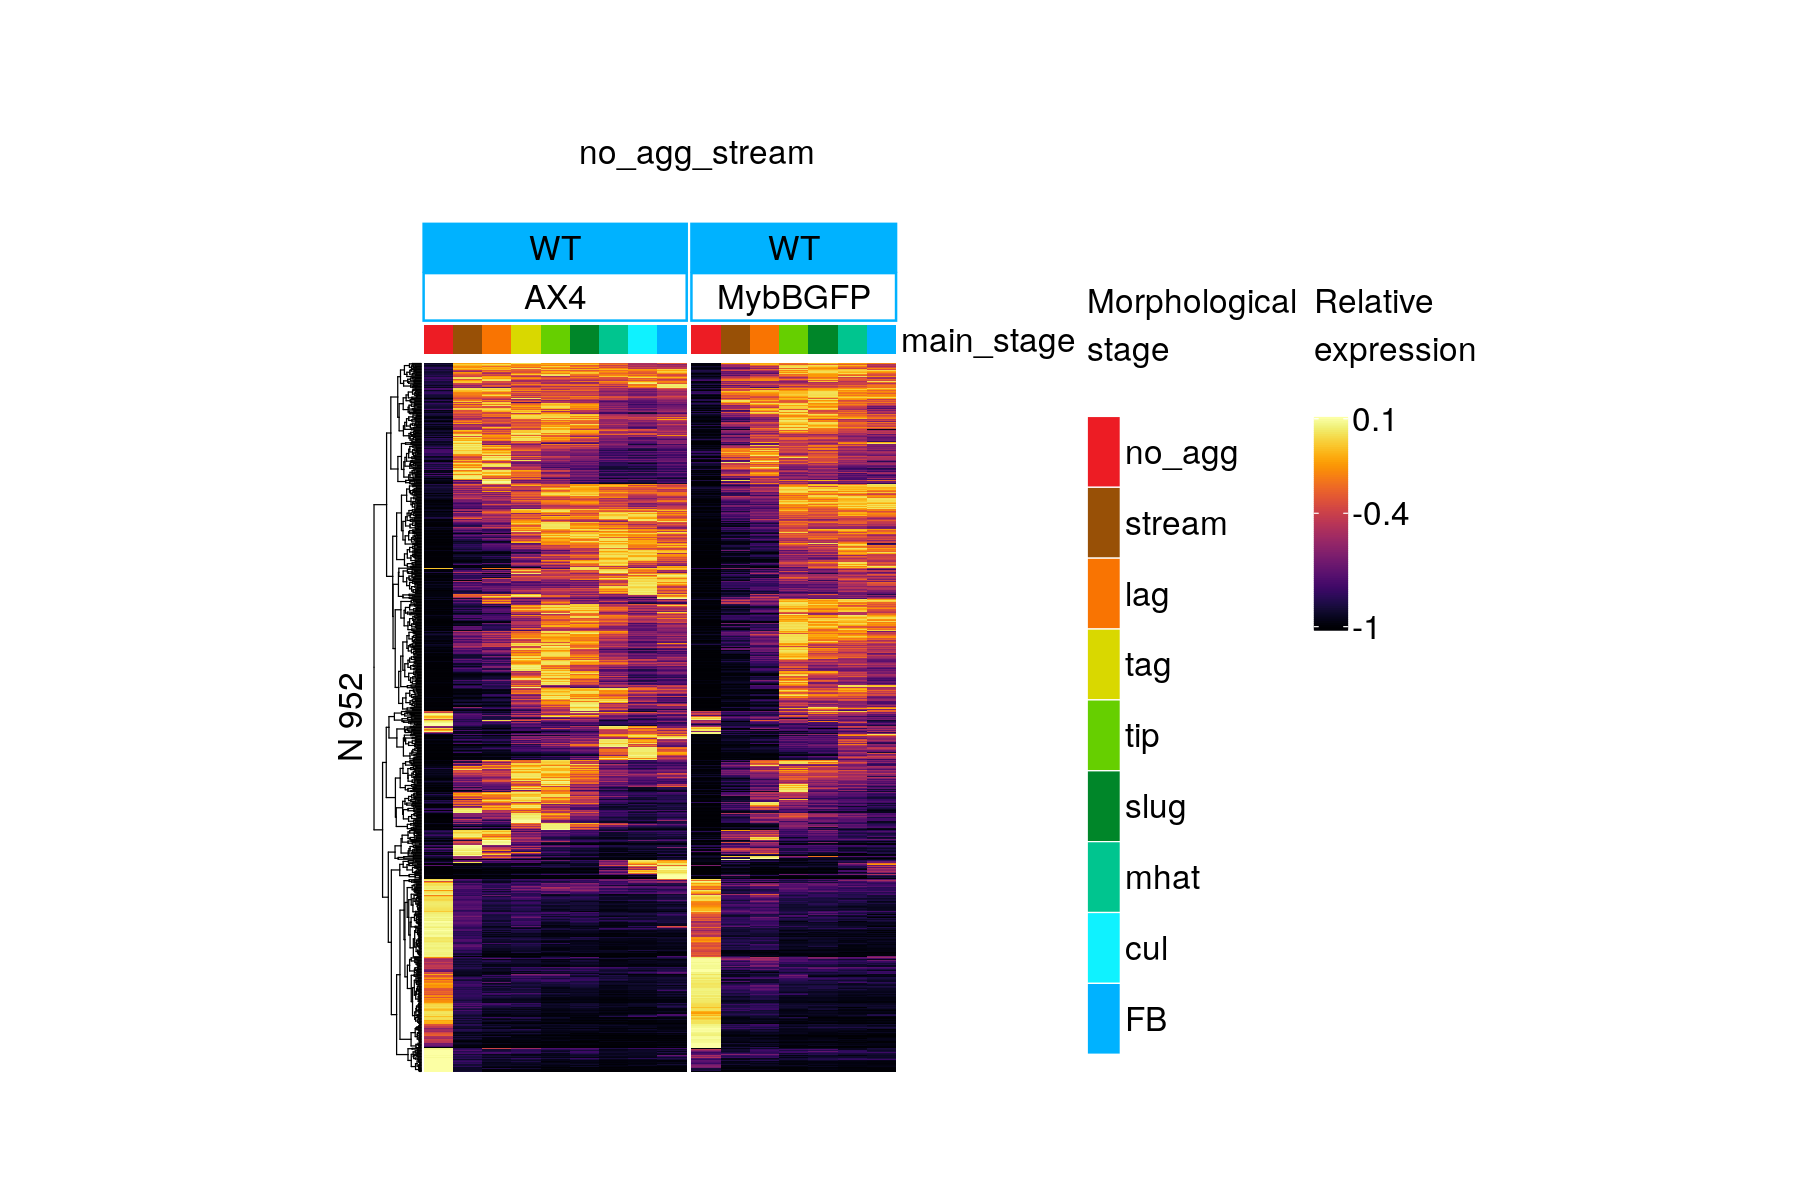

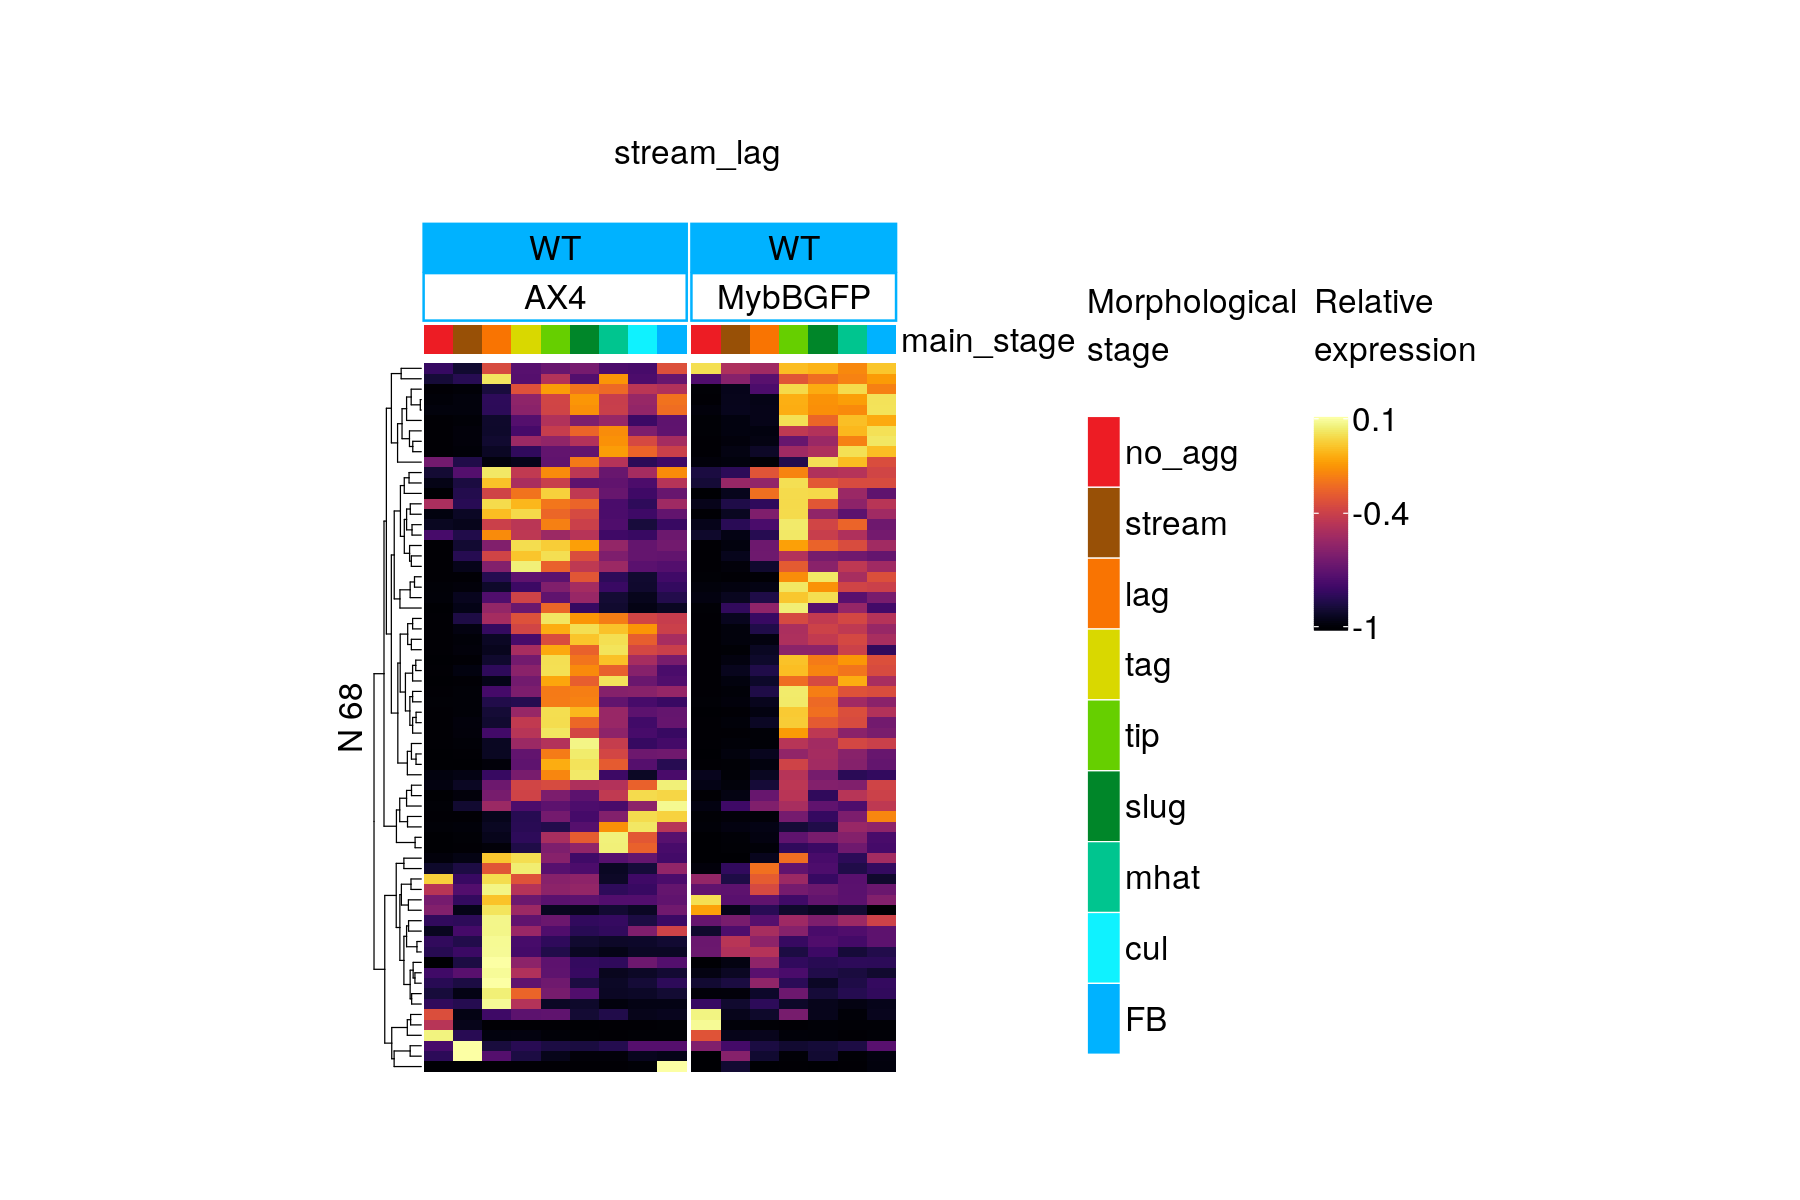

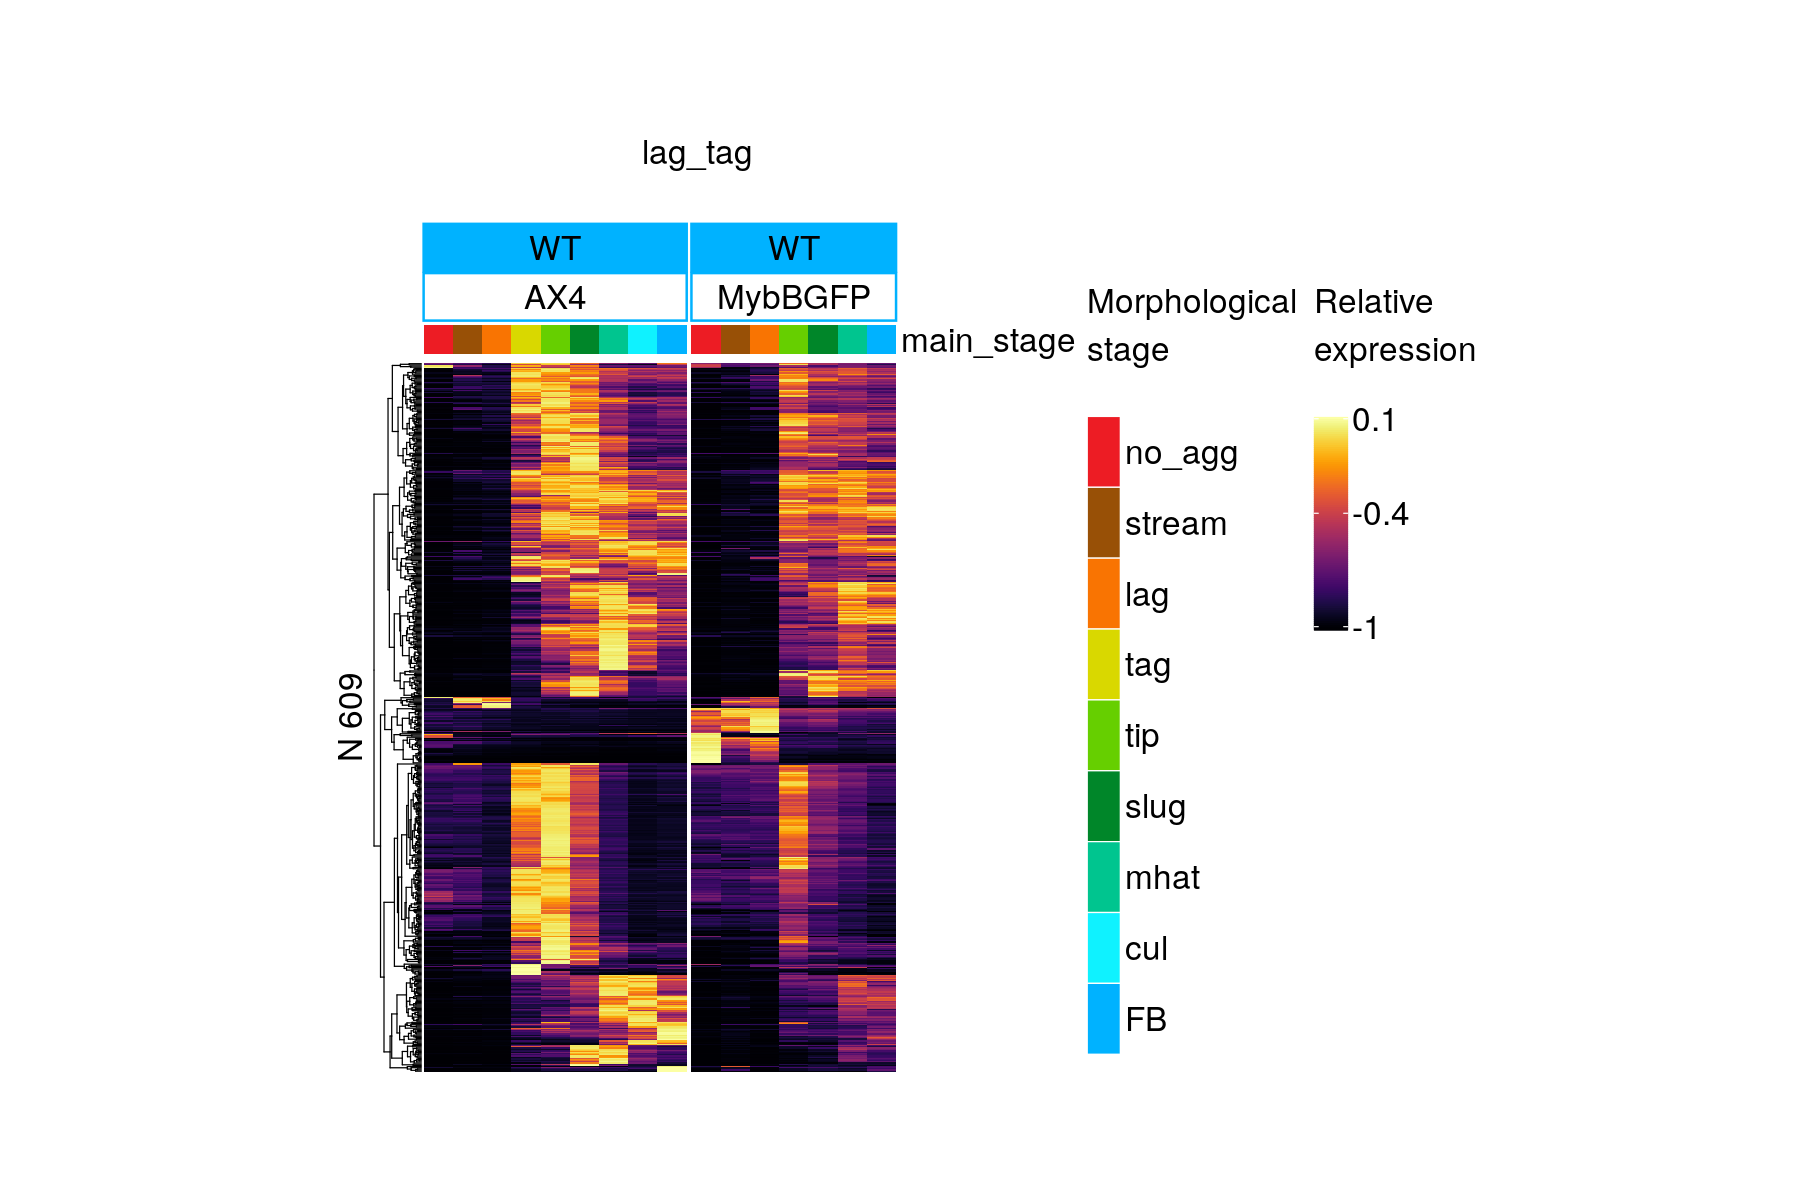

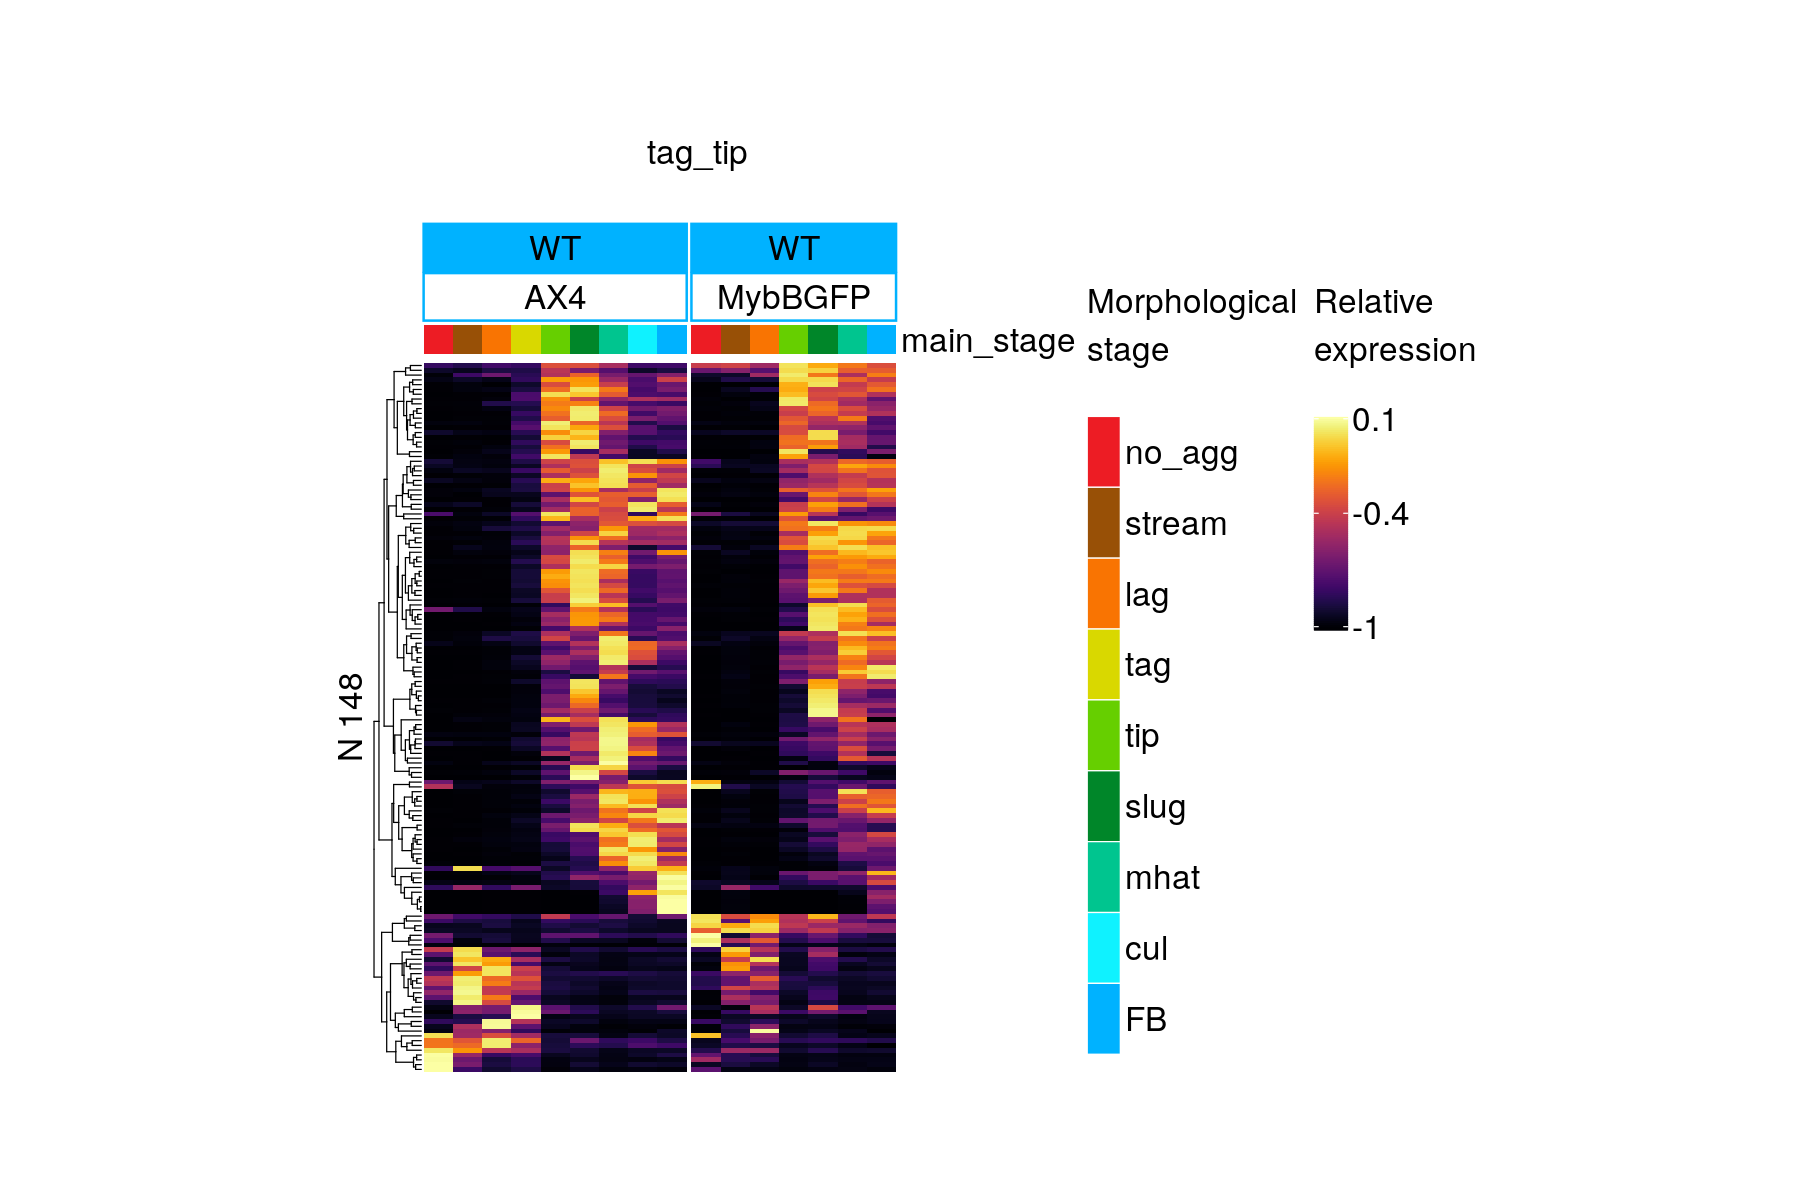

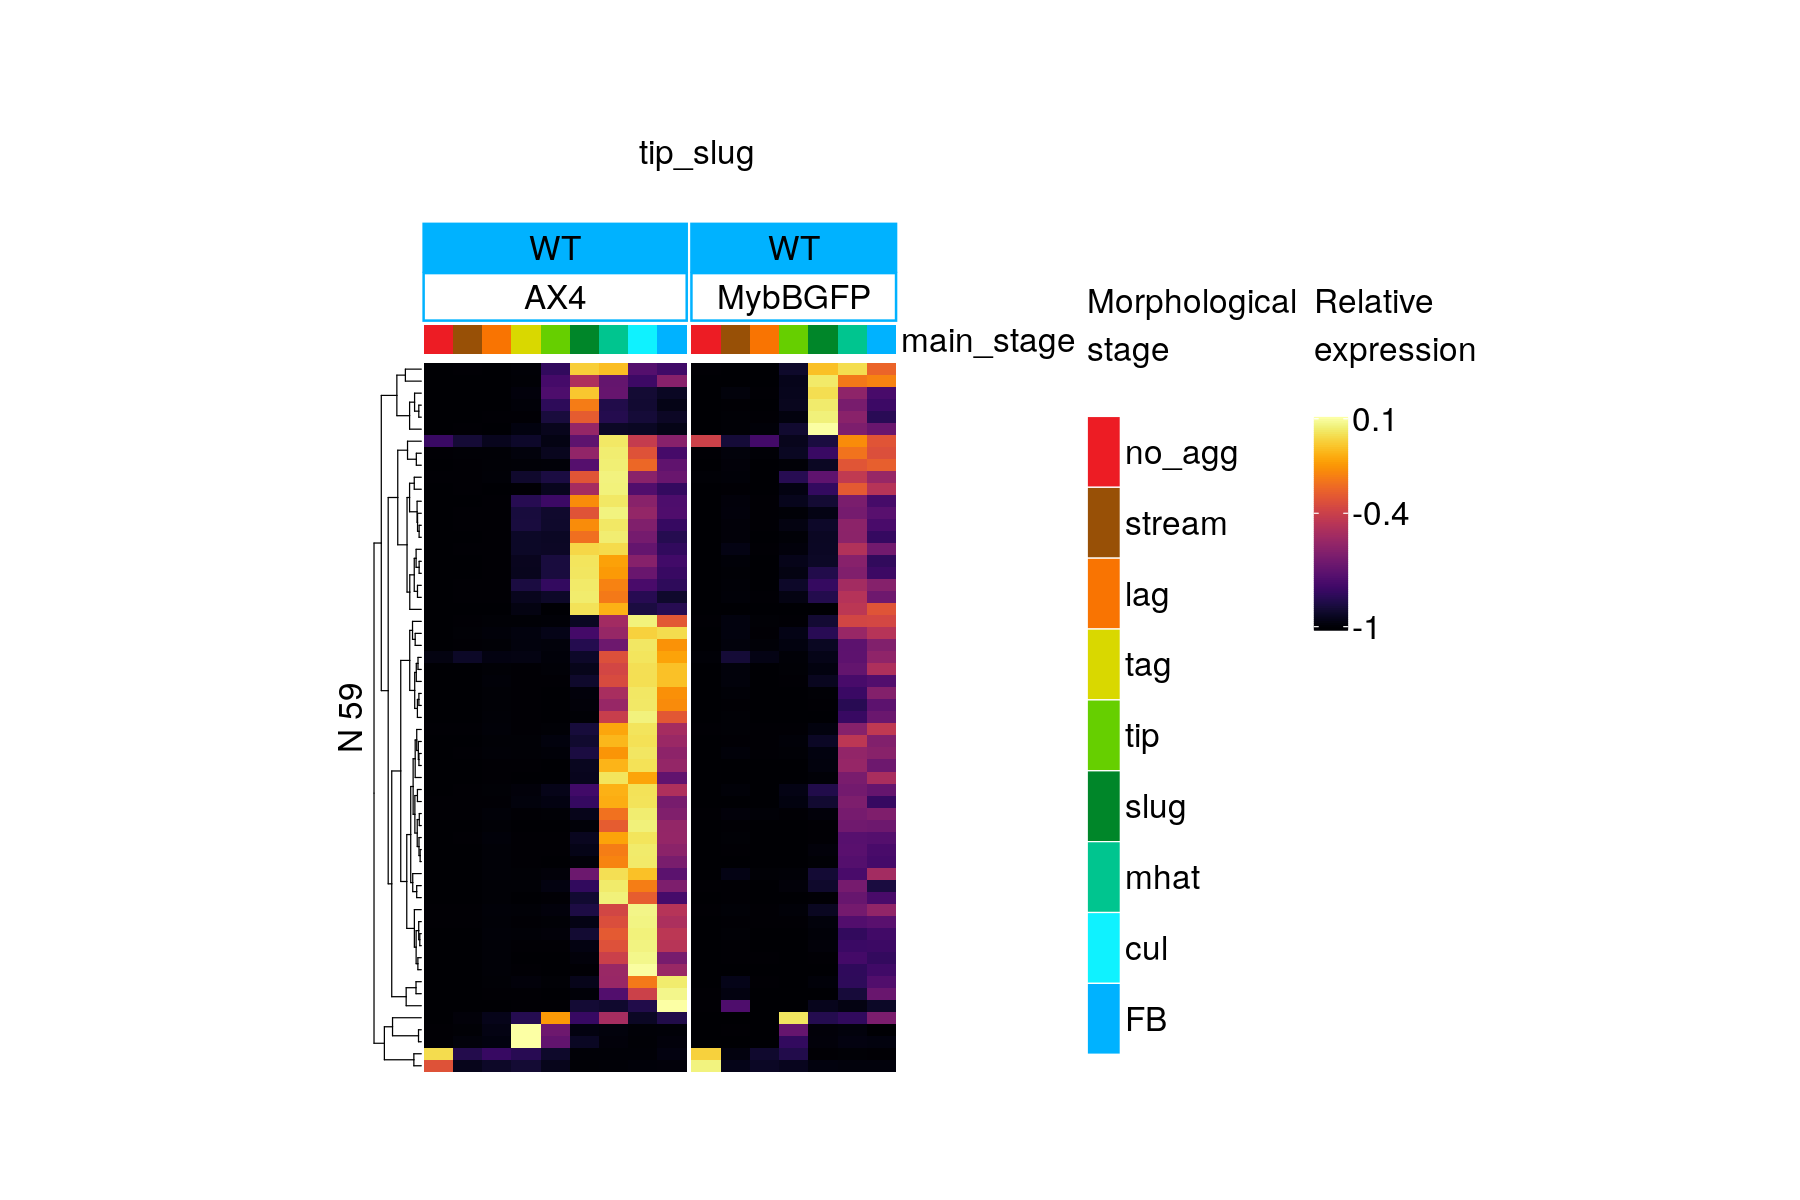

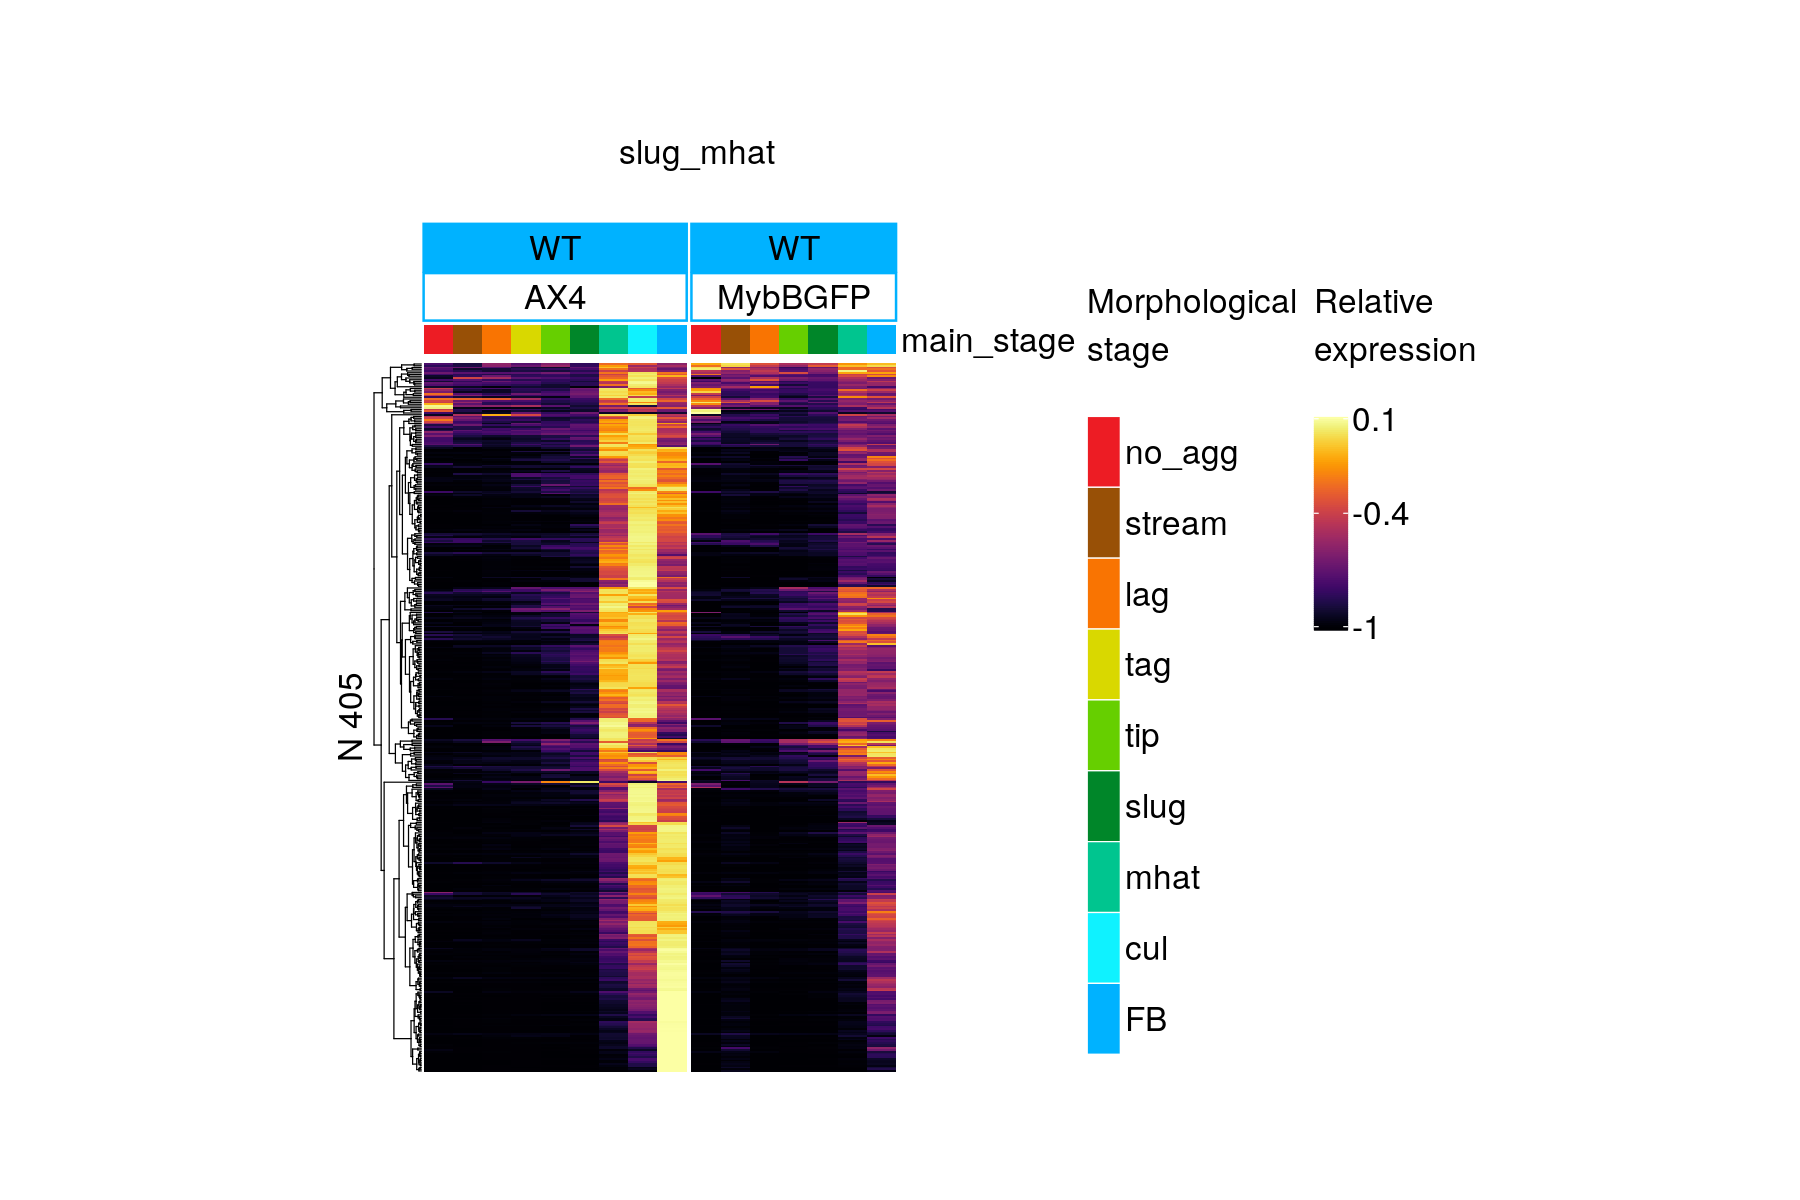

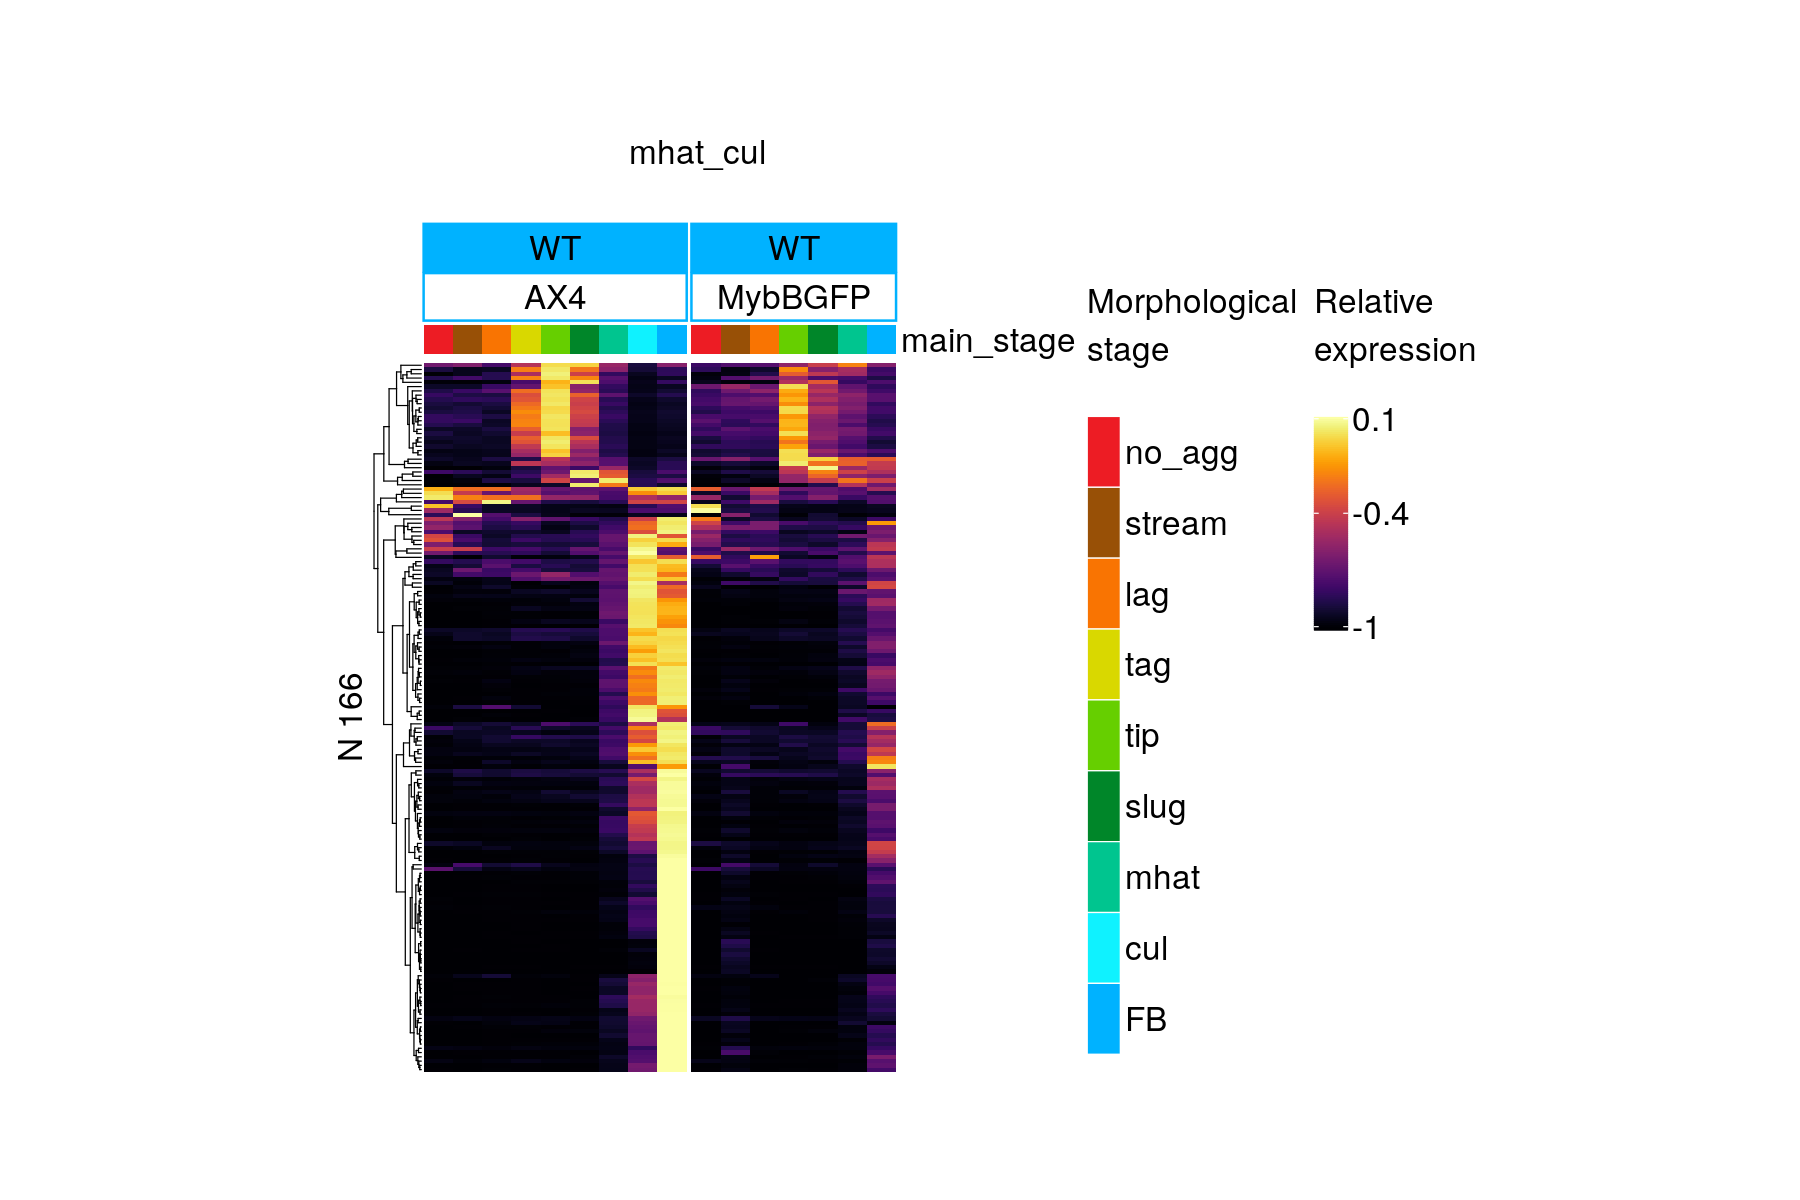

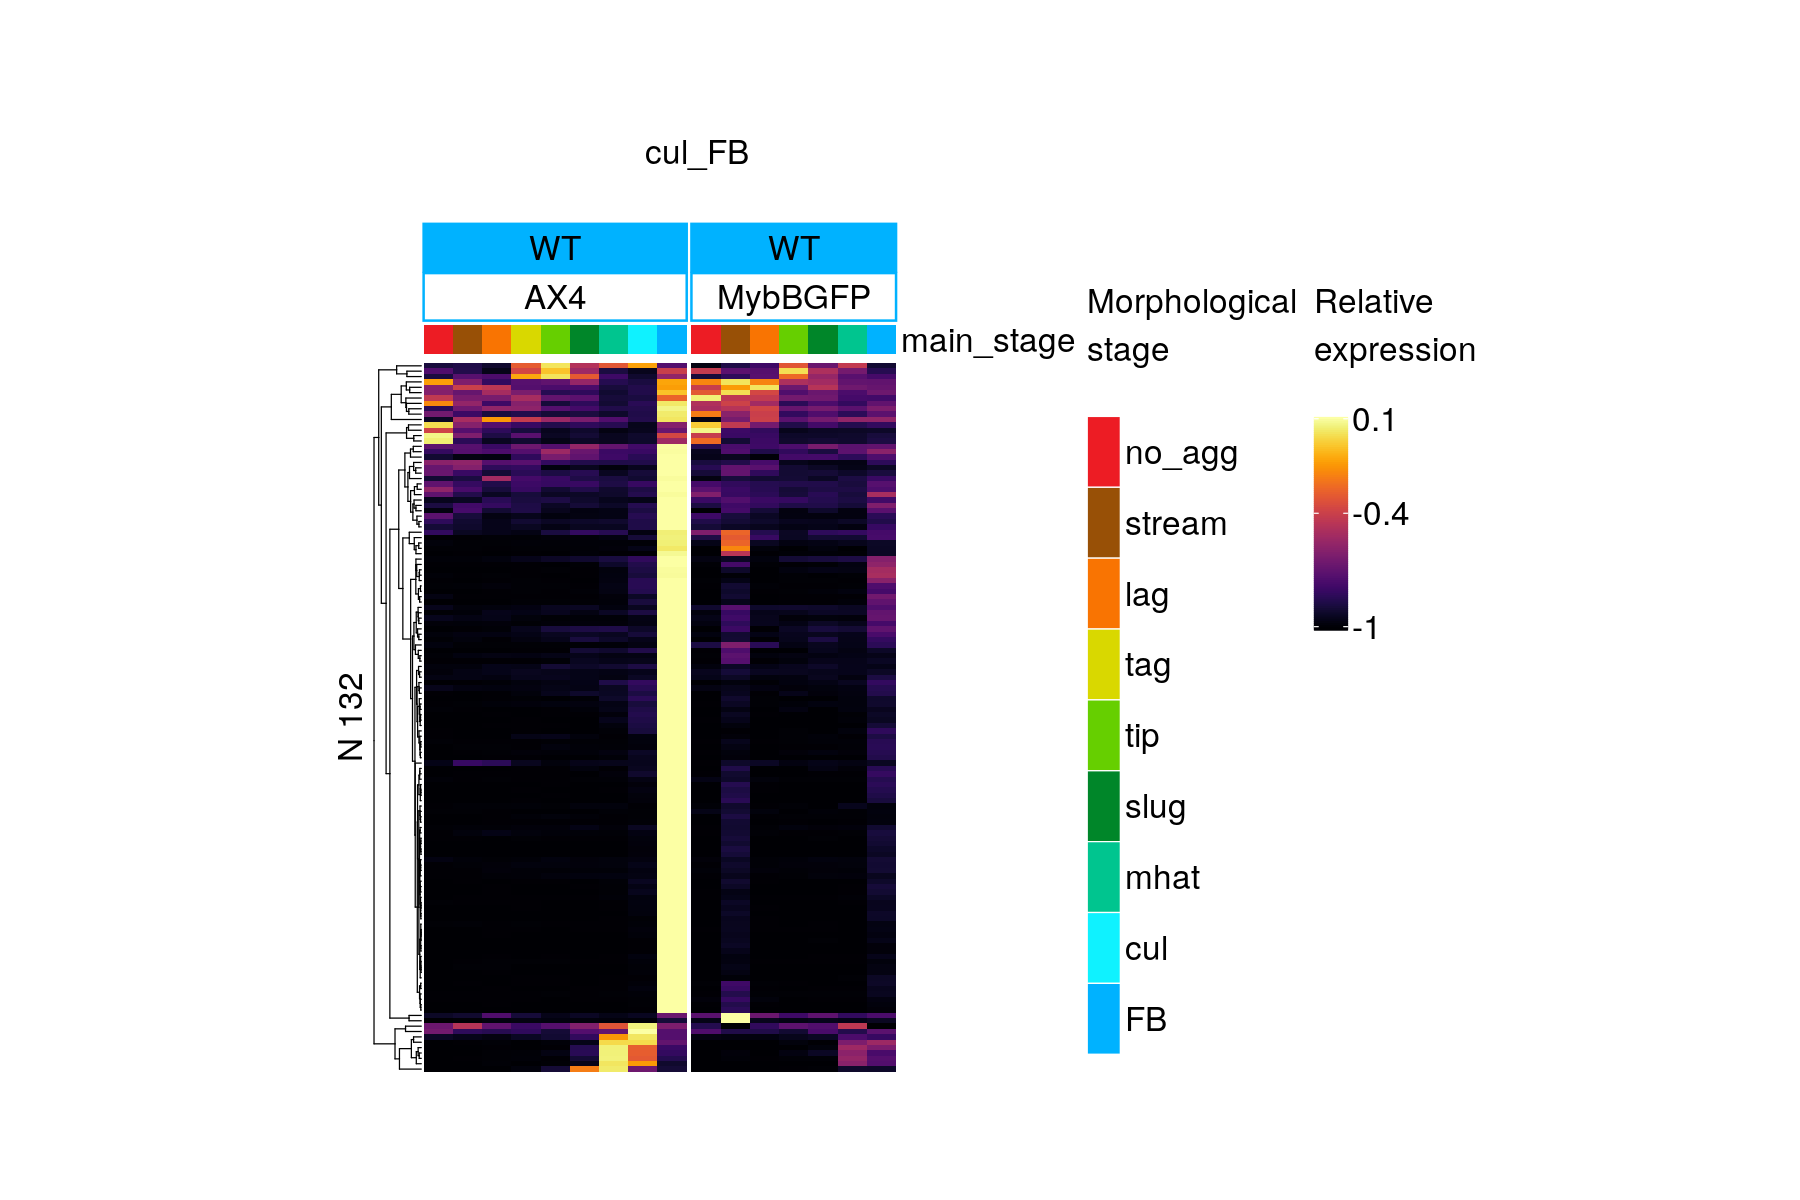

In [127]:
for (comparison in comparisons){
    fc_col=paste(comparison,'_log2FoldChange',sep='')
    fdr_col=paste(comparison,'_FDR_overall',sep='')
    data_defined=data[!is.na(data[fc_col]) & !is.na(data[fdr_col]),]
    genes<-rownames(data_defined[abs(data_defined[fc_col])>=MIN_ABS_LFC_DE & 
                        data_defined[fdr_col]<=MAX_FDR_DE &
                        data_defined['Significant_N']<=MAX_N_SIGNIFICANT_DE,])
    
    expression=t(avg_expression[avg_expression$Strain=='AX4',genes])
    #expression=t(avg_expression[,genes])
    distances<-dist(expression, method="cosine")
    hc<-hclust(d=distances, method = "ward.D2" )
    hc_ordered<-reorder(x=hc,dist = distances)
    genes<- as.dendrogram(hc_ordered) %>% labels
    
    n_genes=length(genes)
    #print(paste(comparison,n_genes))

    data_anno=paste('N',n_genes)
    height=0.3*n_genes
    if (height>15) height=15
    heatmap=Heatmap(t(avg_expression[,genes]),cluster_columns = FALSE,cluster_rows = TRUE,
                    show_column_names = FALSE,
                      show_row_names = FALSE, col=inferno(256),column_title=NULL, 
                      row_title=data_anno,
                      show_heatmap_legend = TRUE,heatmap_legend_param = list(
                      title = "\nRelative \nexpression\n",
                      at = c(min_expression, round(mean(c(min_expression,max_expression)),1),max_expression),
                      grid_width= unit(legend_width, "cm"),grid_height= unit(legened_height, "cm") ,
                      labels_gp = gpar(fontsize = cluster_font),title_gp = gpar(fontsize = cluster_font)),
                      #** Cluster name fontsize
                      row_title_gp=gpar(fontsize=cluster_font),height=unit(height, "cm"))

    draw(make_anno() %v% heatmap,width=unit(10, "cm"),
        column_title =paste(comparison,'\n'),column_title_gp = gpar(fontsize = cluster_font))

}

## Filtering by using stages identified as transitions by ImpulseDE2
The genes for each pair of neighbouring stages are obtained with the following two filters:
1.) Gene is DE between two neighbouring stages, based on abs lFC (e.g. >=2 or 1) and FDR (e.g. <=0.01 or 0.05).
2.) ImpulseDE2 identified gene as DE expressed through stages and the transition occured between the two neighbouring stages. Two heatmaps are shown for each pair of stages: the one with the less stringent threshold does not contain the genes already displayed in the one with the more stringent threshold.

In [11]:
params_data<-data.frame(padj_max=c(MAX_FDR_DE,0.05),lfc_min=c(MIN_ABS_LFC_DE,1))

Old main stage data! TODO: update main stage data.

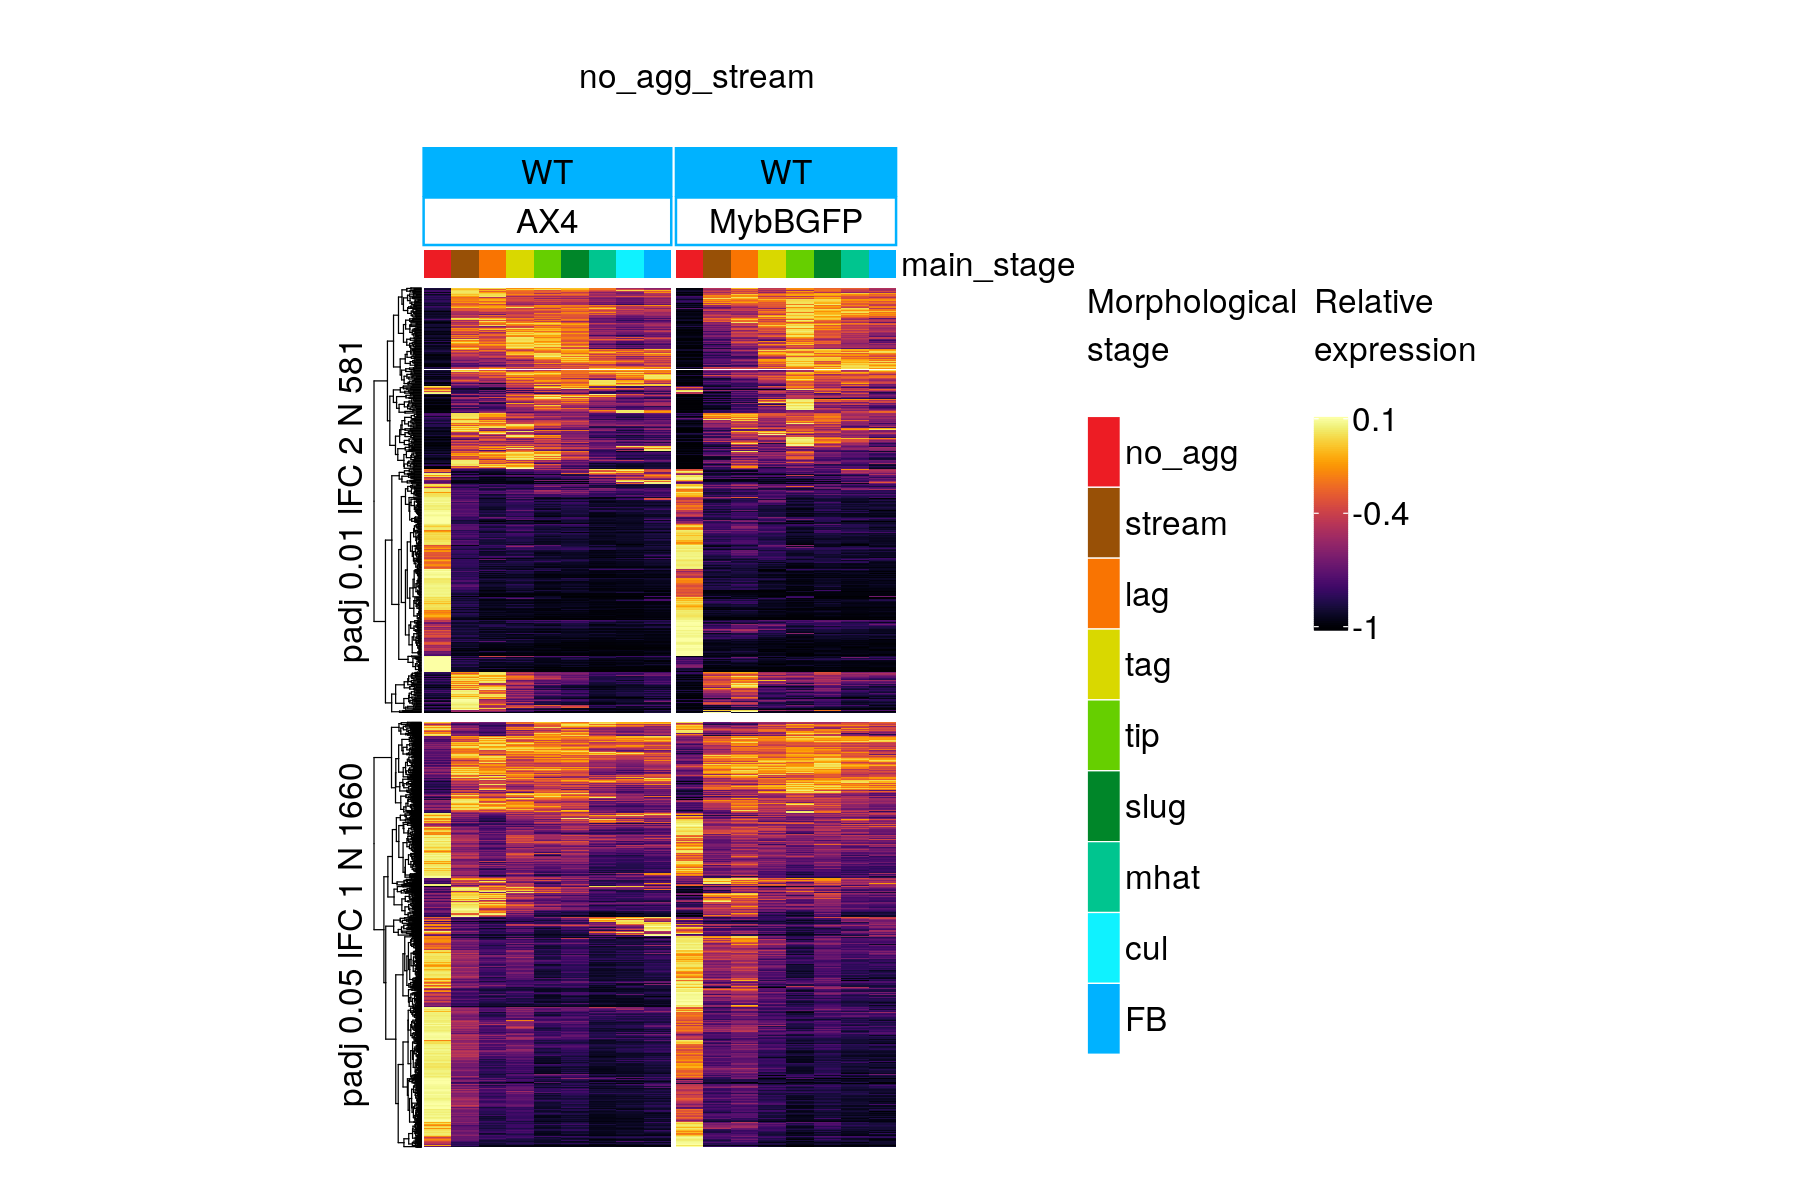

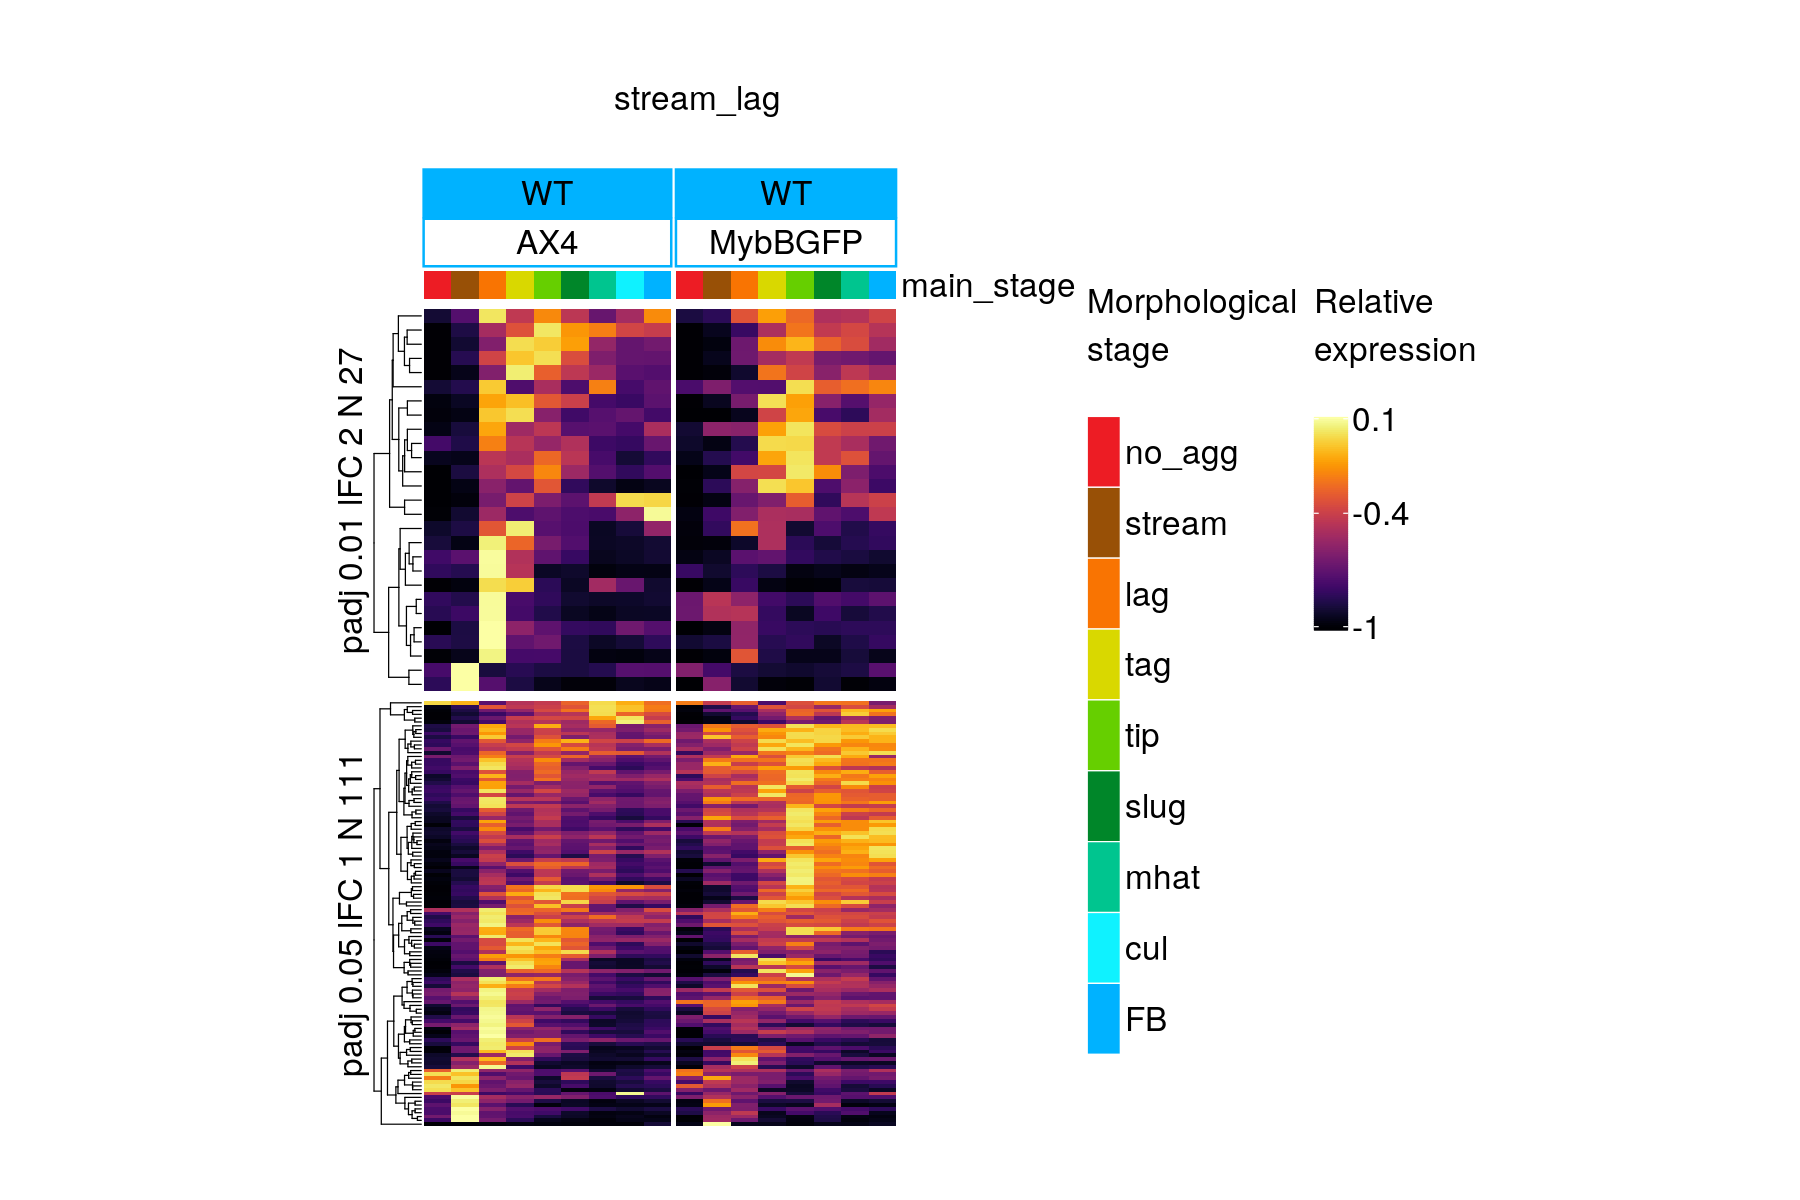

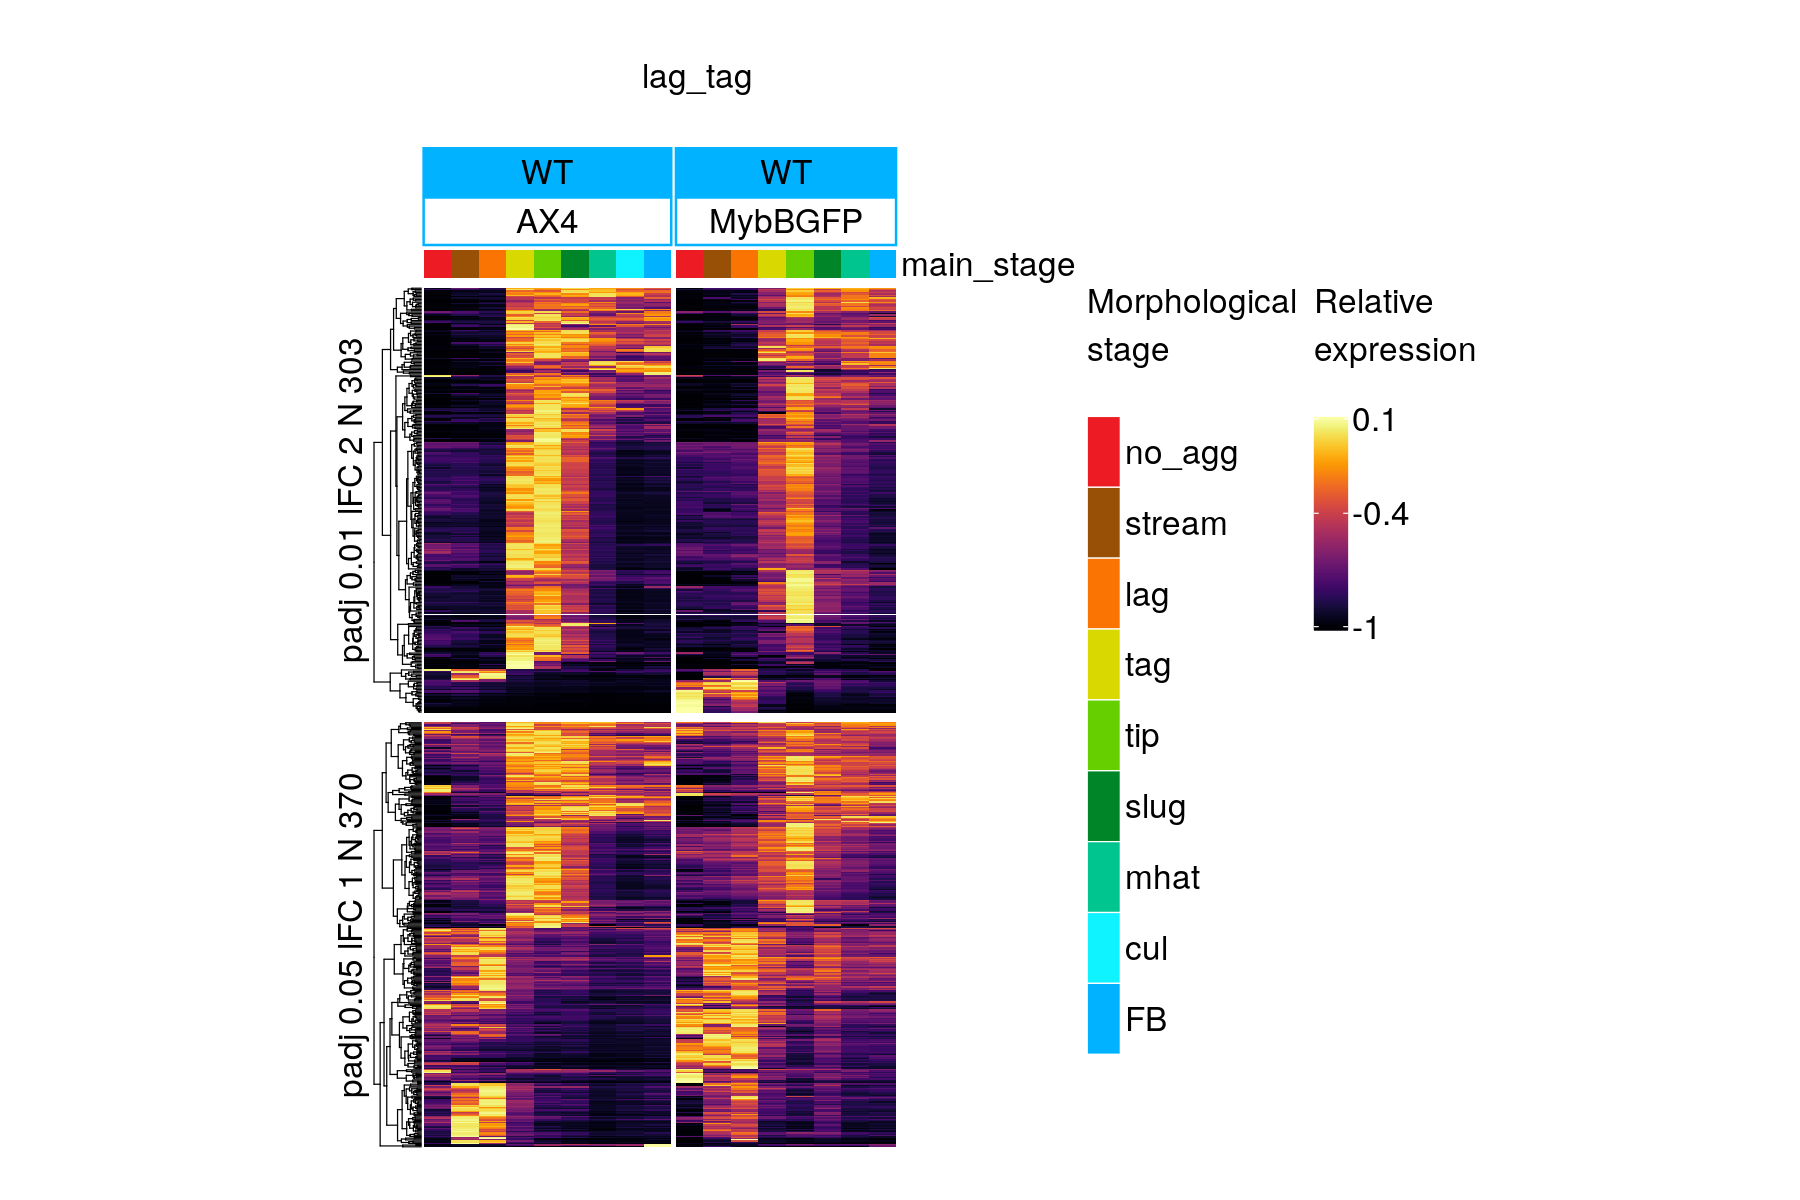

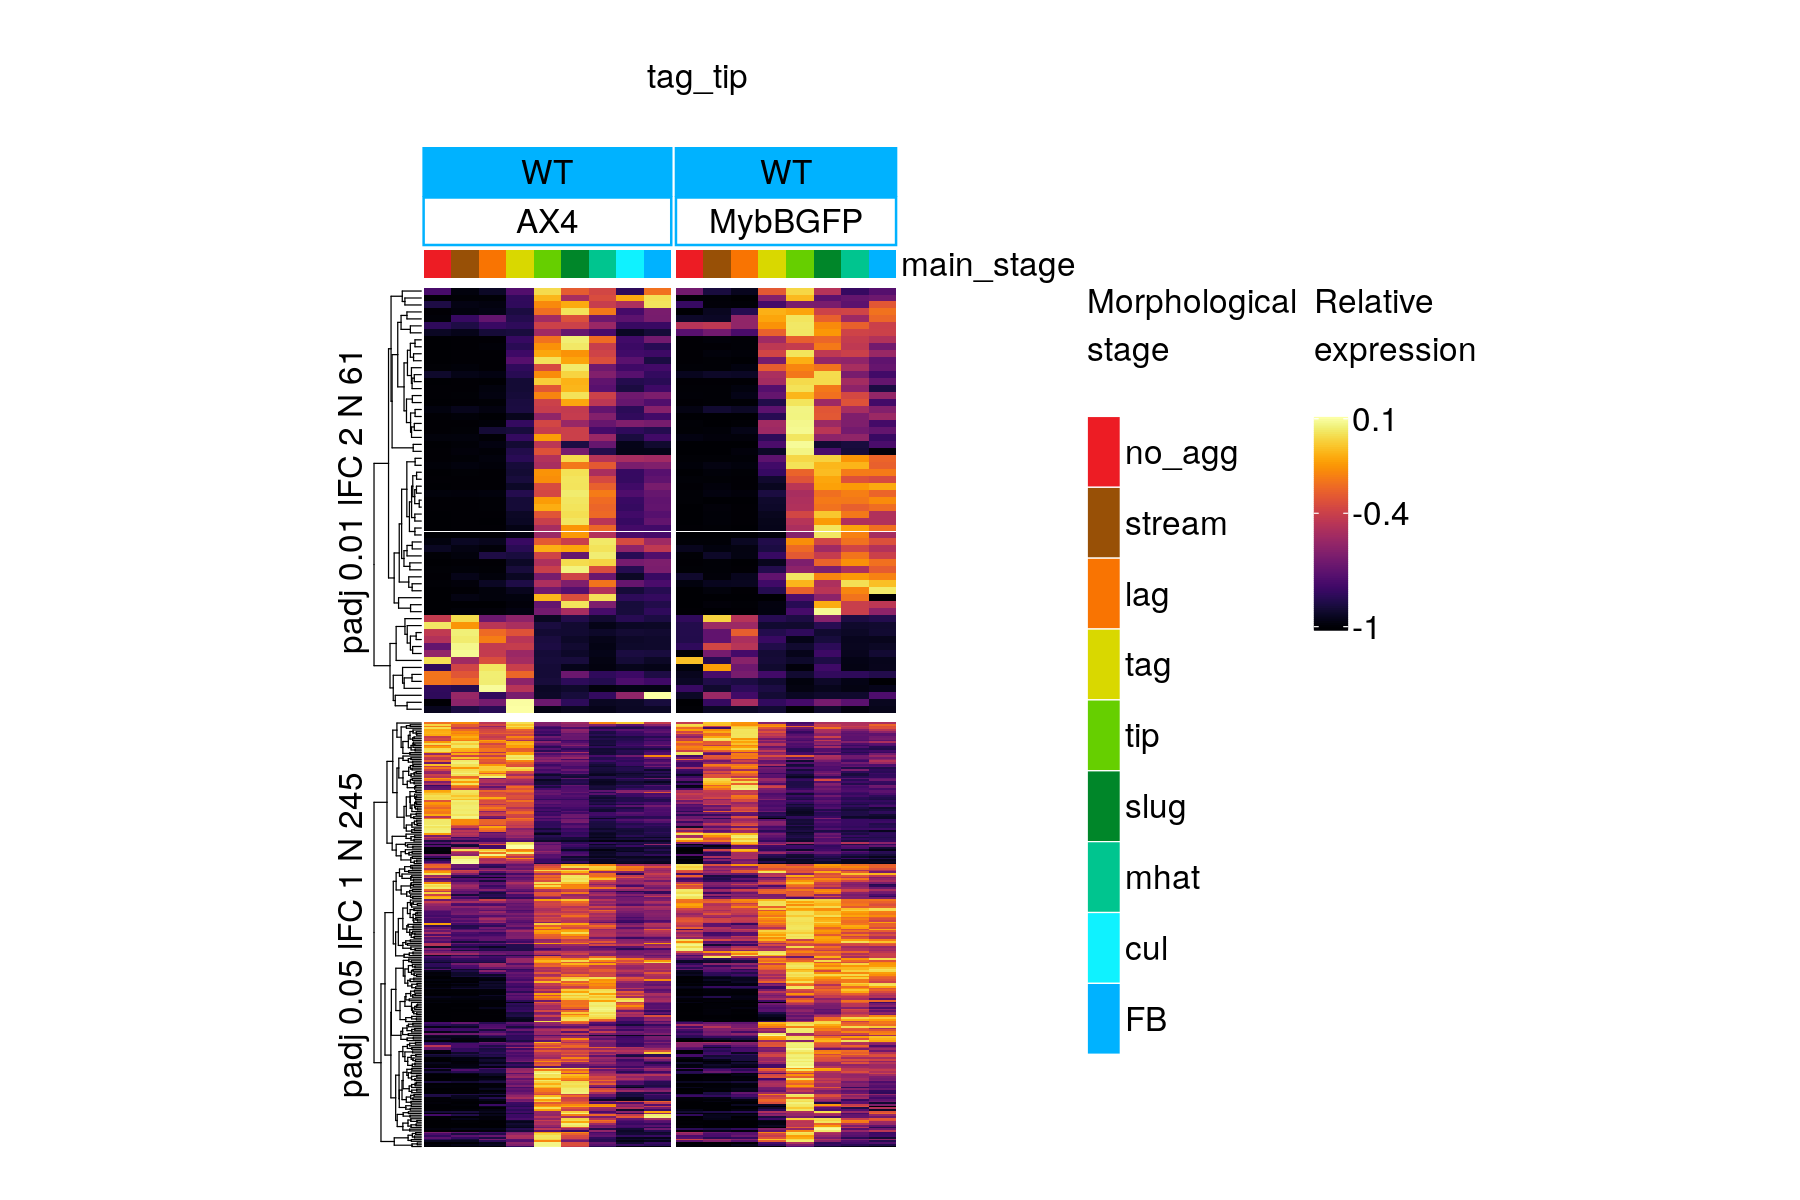

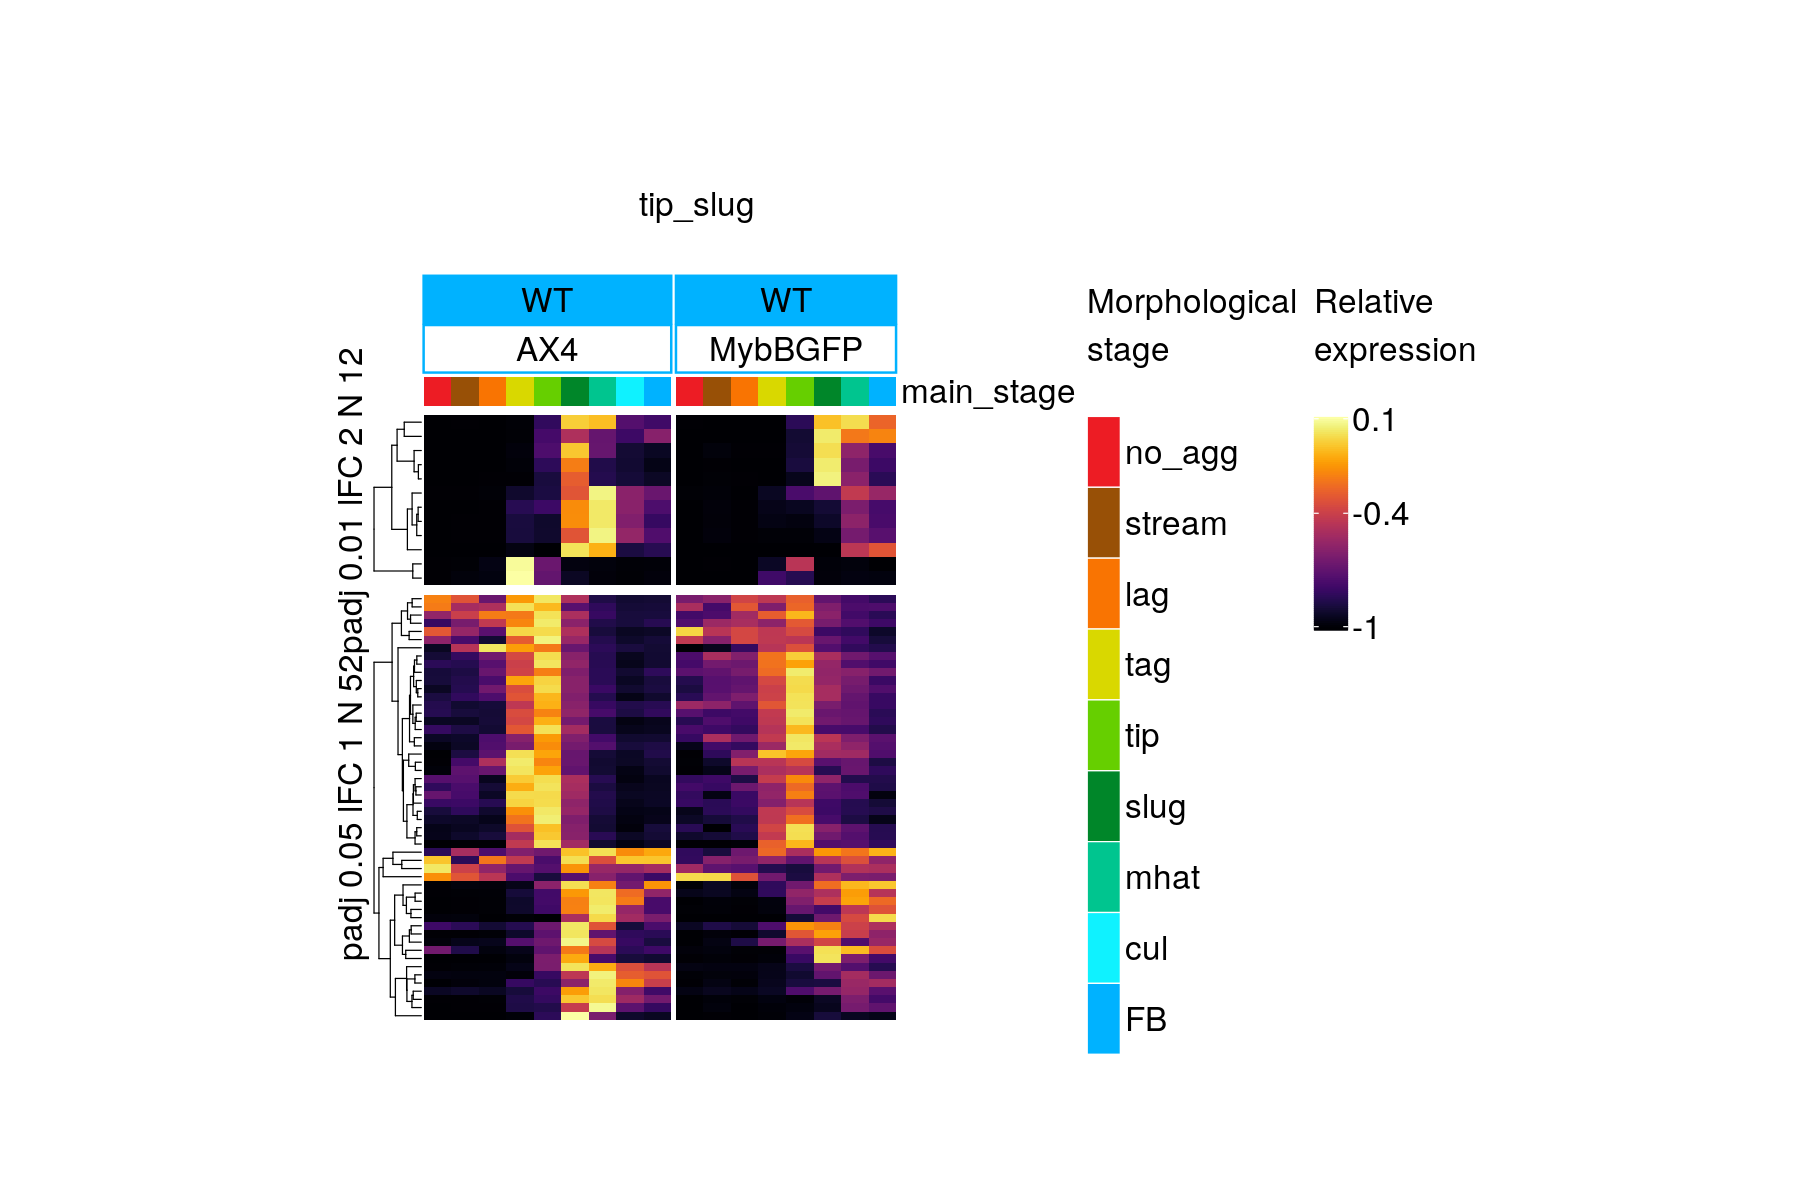

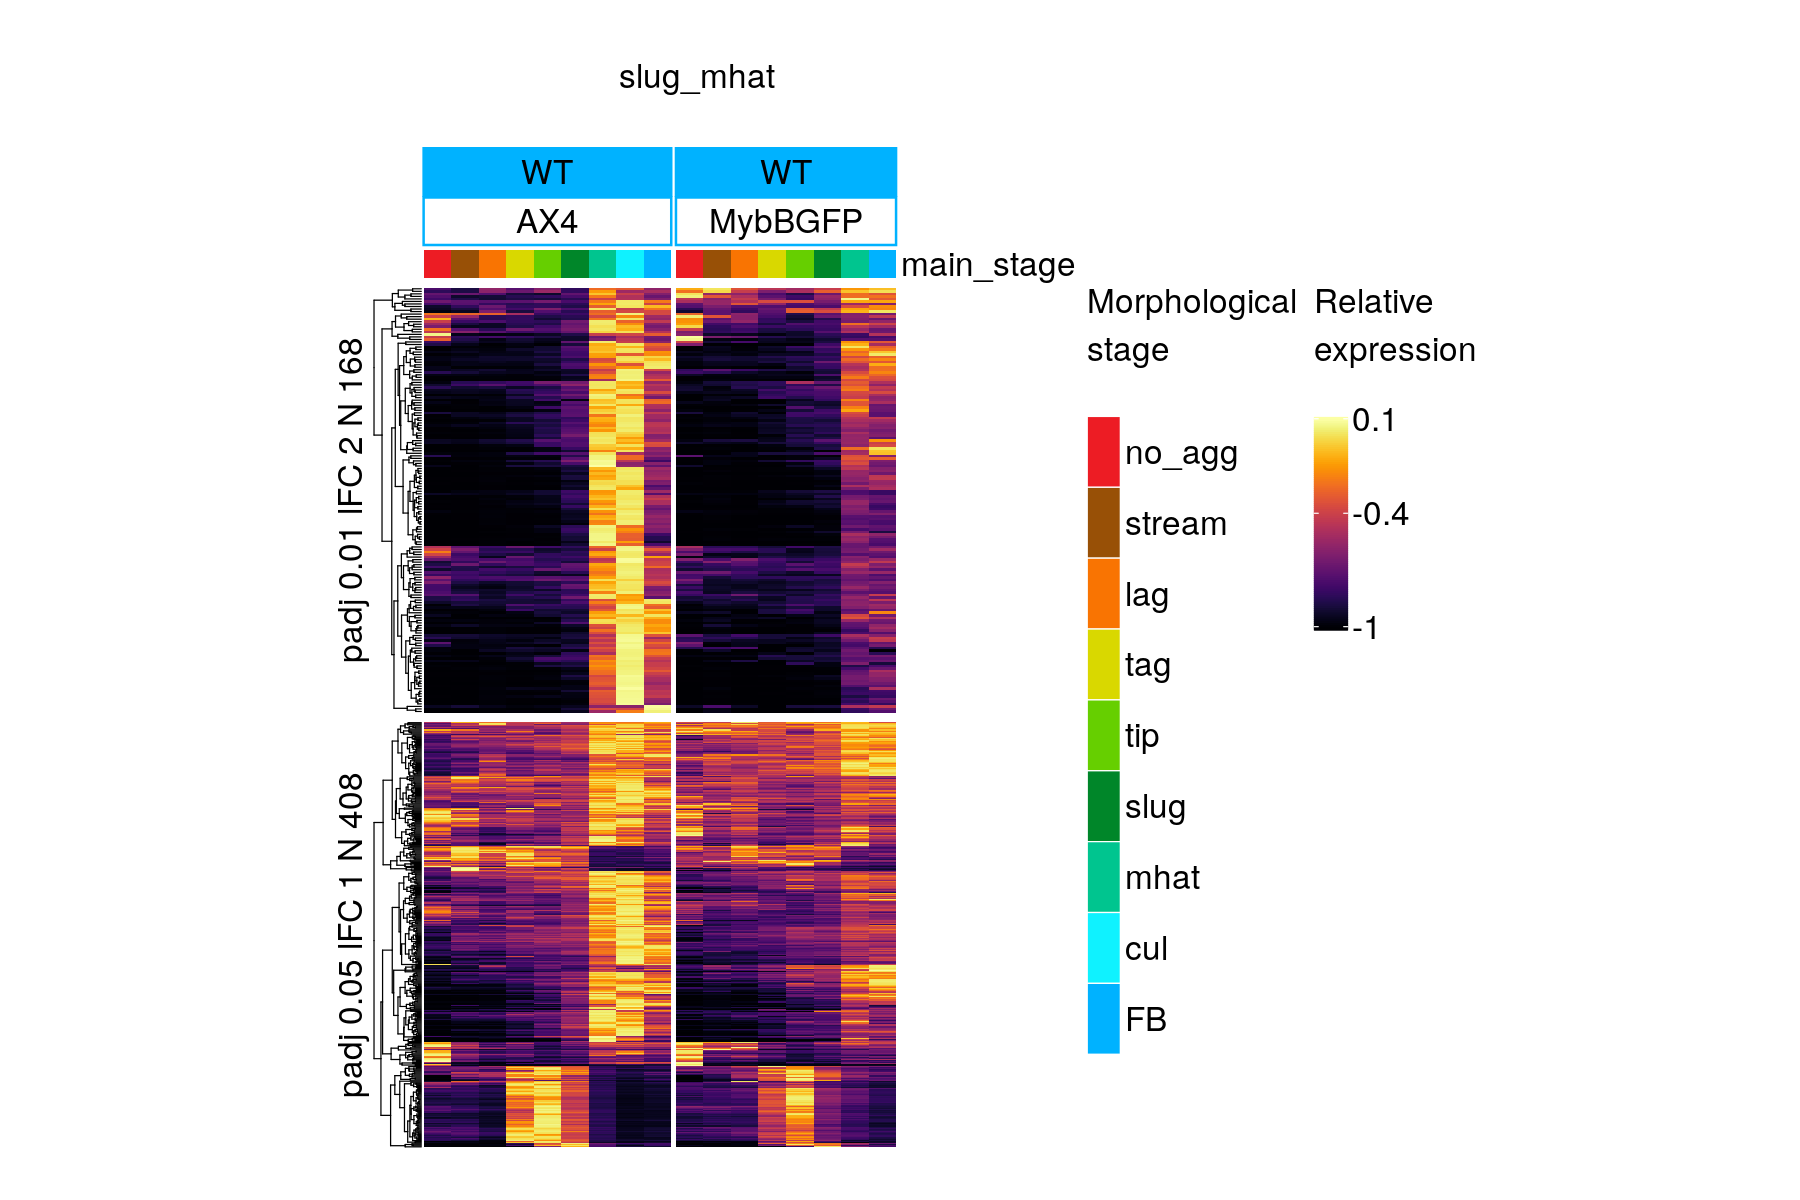

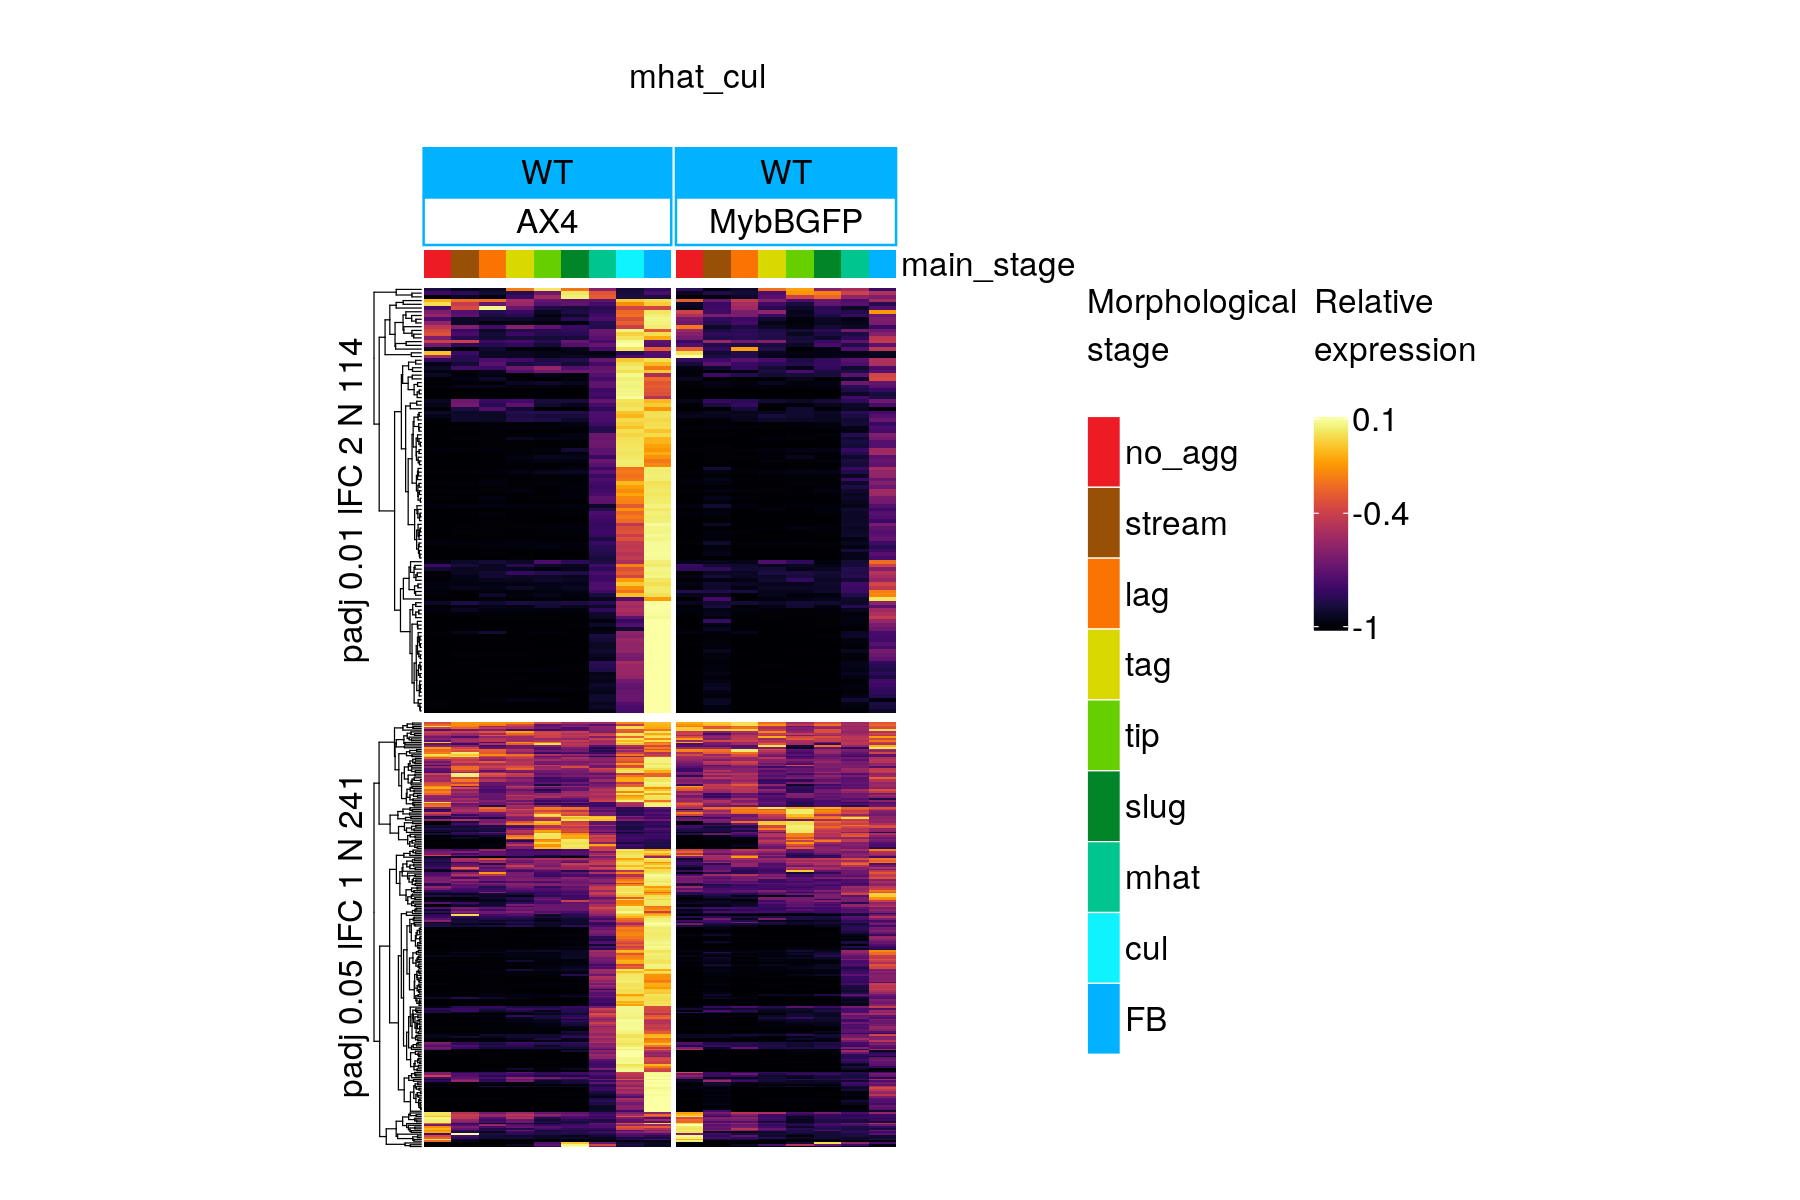

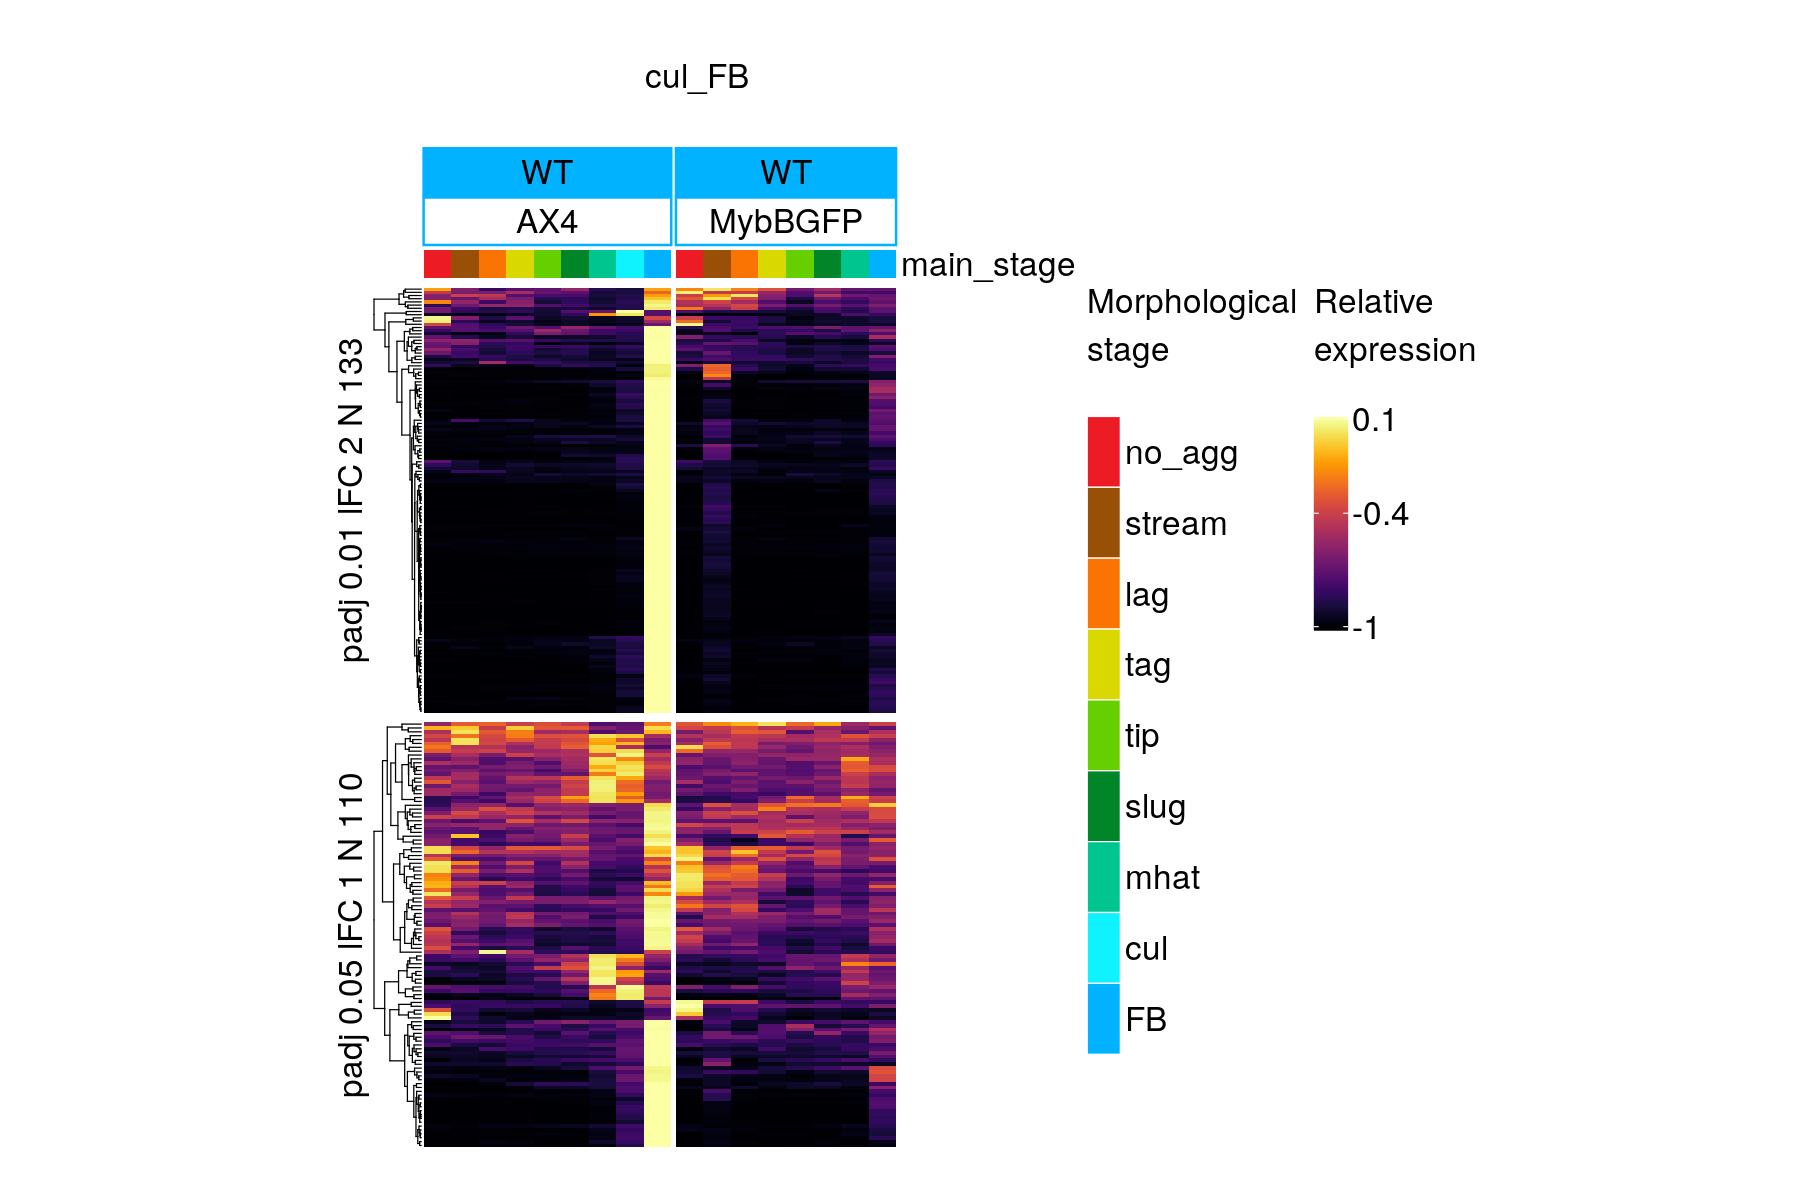

In [18]:
for (comparison in comparisons){
    fc_col=paste(comparison,'_log2FoldChange',sep='')
    fdr_col=paste(comparison,'_FDR_overall',sep='')
    data_defined=data[!is.na(data[fc_col]) & !is.na(data[fdr_col]) & !is.na(data[comparison]),]
    first=TRUE
    heatmaps=make_anno()
    for(param_idx in 1:nrow(params_data)){
        padj=params_data[param_idx,'padj_max'] 
        lfc=params_data[param_idx,'lfc_min']
        genes<-rownames(data_defined[abs(data_defined[fc_col])>=params_data[param_idx,'lfc_min'] & 
                        data_defined[fdr_col]<=params_data[param_idx,'padj_max'] &
                        data_defined[comparison]==1,])
        genes_previous=c()
        if (param_idx>1) genes_previous=rownames(
                        data_defined[abs(data_defined[fc_col])>=params_data[param_idx-1,'lfc_min'] & 
                        data_defined[fdr_col]<=params_data[param_idx-1,'padj_max'] &
                        data_defined[comparison]==1,])
        genes<-genes[which(!genes %in% genes_previous)]
    
        expression=t(avg_expression[avg_expression$Strain=='AX4',genes])
        #expression=t(avg_expression[,genes])
        distances<-dist(expression, method="cosine")
        hc<-hclust(d=distances, method = "ward.D2" )
        hc_ordered<-reorder(x=hc,dist = distances)
        genes<- as.dendrogram(hc_ordered) %>% labels

        n_genes=length(genes)
        #print(paste(comparison,n_genes))
        data_anno=paste('padj',params_data[param_idx,'padj_max'],'lFC',params_data[param_idx,'lfc_min'],'N',n_genes)
        height=0.3*n_genes
        if (height>9) height=9
        heatmap=Heatmap(t(avg_expression[,genes]),cluster_columns = FALSE,cluster_rows = TRUE,
                        show_column_names = FALSE,
                          show_row_names = FALSE, col=inferno(256),column_title=NULL, 
                          row_title=data_anno,
                          show_heatmap_legend = first,heatmap_legend_param = list(
                          title = "\nRelative \nexpression\n",
                          at = c(min_expression, round(mean(c(min_expression,max_expression)),1),max_expression),
                          grid_width= unit(legend_width, "cm"),grid_height= unit(legened_height, "cm") ,
                          labels_gp = gpar(fontsize = cluster_font),title_gp = gpar(fontsize = cluster_font)),
                          #** Cluster name fontsize
                          row_title_gp=gpar(fontsize=cluster_font),height=unit(height, "cm"))
        first=FALSE
        heatmaps = heatmaps %v% heatmap
    }
    draw(heatmaps,width=unit(10, "cm"),
            column_title =paste(comparison,'\n'),column_title_gp = gpar(fontsize = cluster_font))

}

### Filtering by using stages identified as transitions by ImpulseDE2 using only AX4 data 
Expression of MybBGFP is shown only as an example, although MybBGFP was excluded from data generation process.

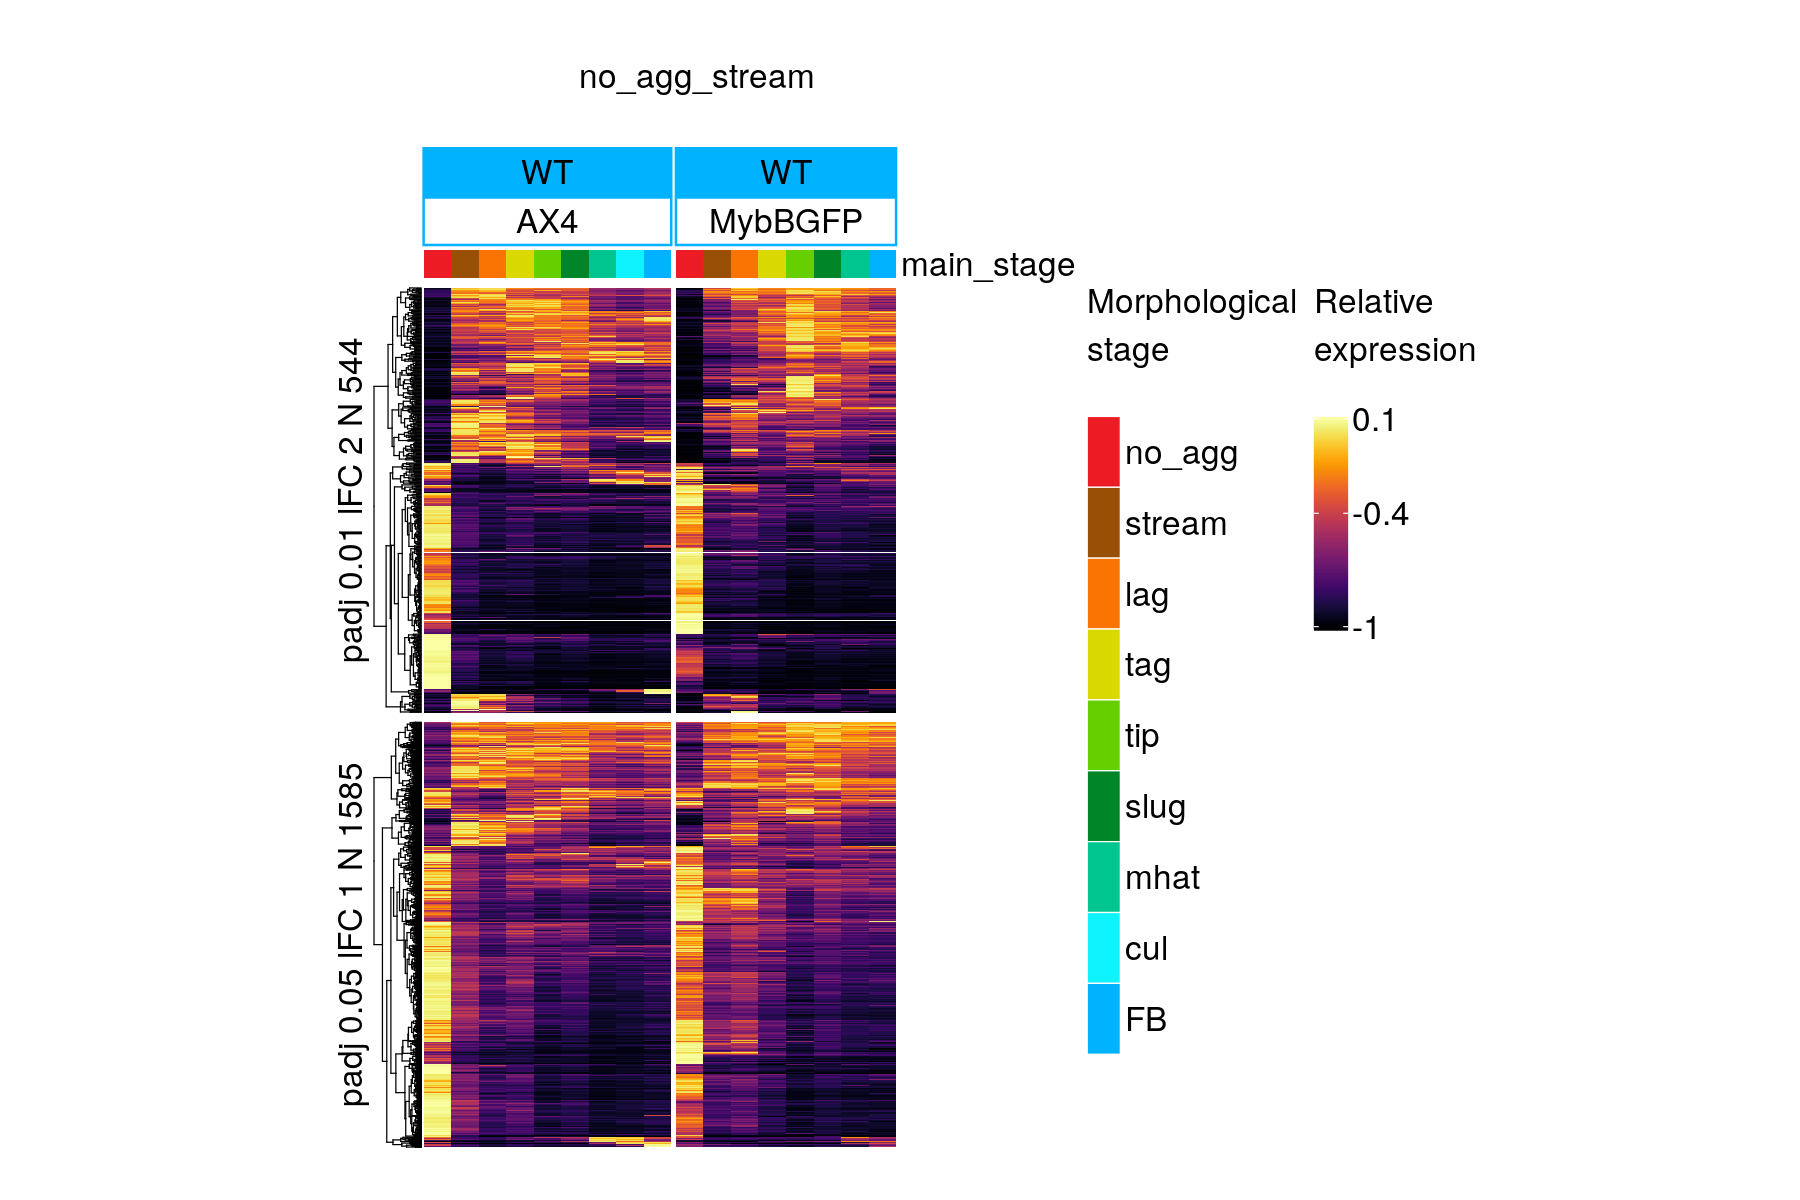

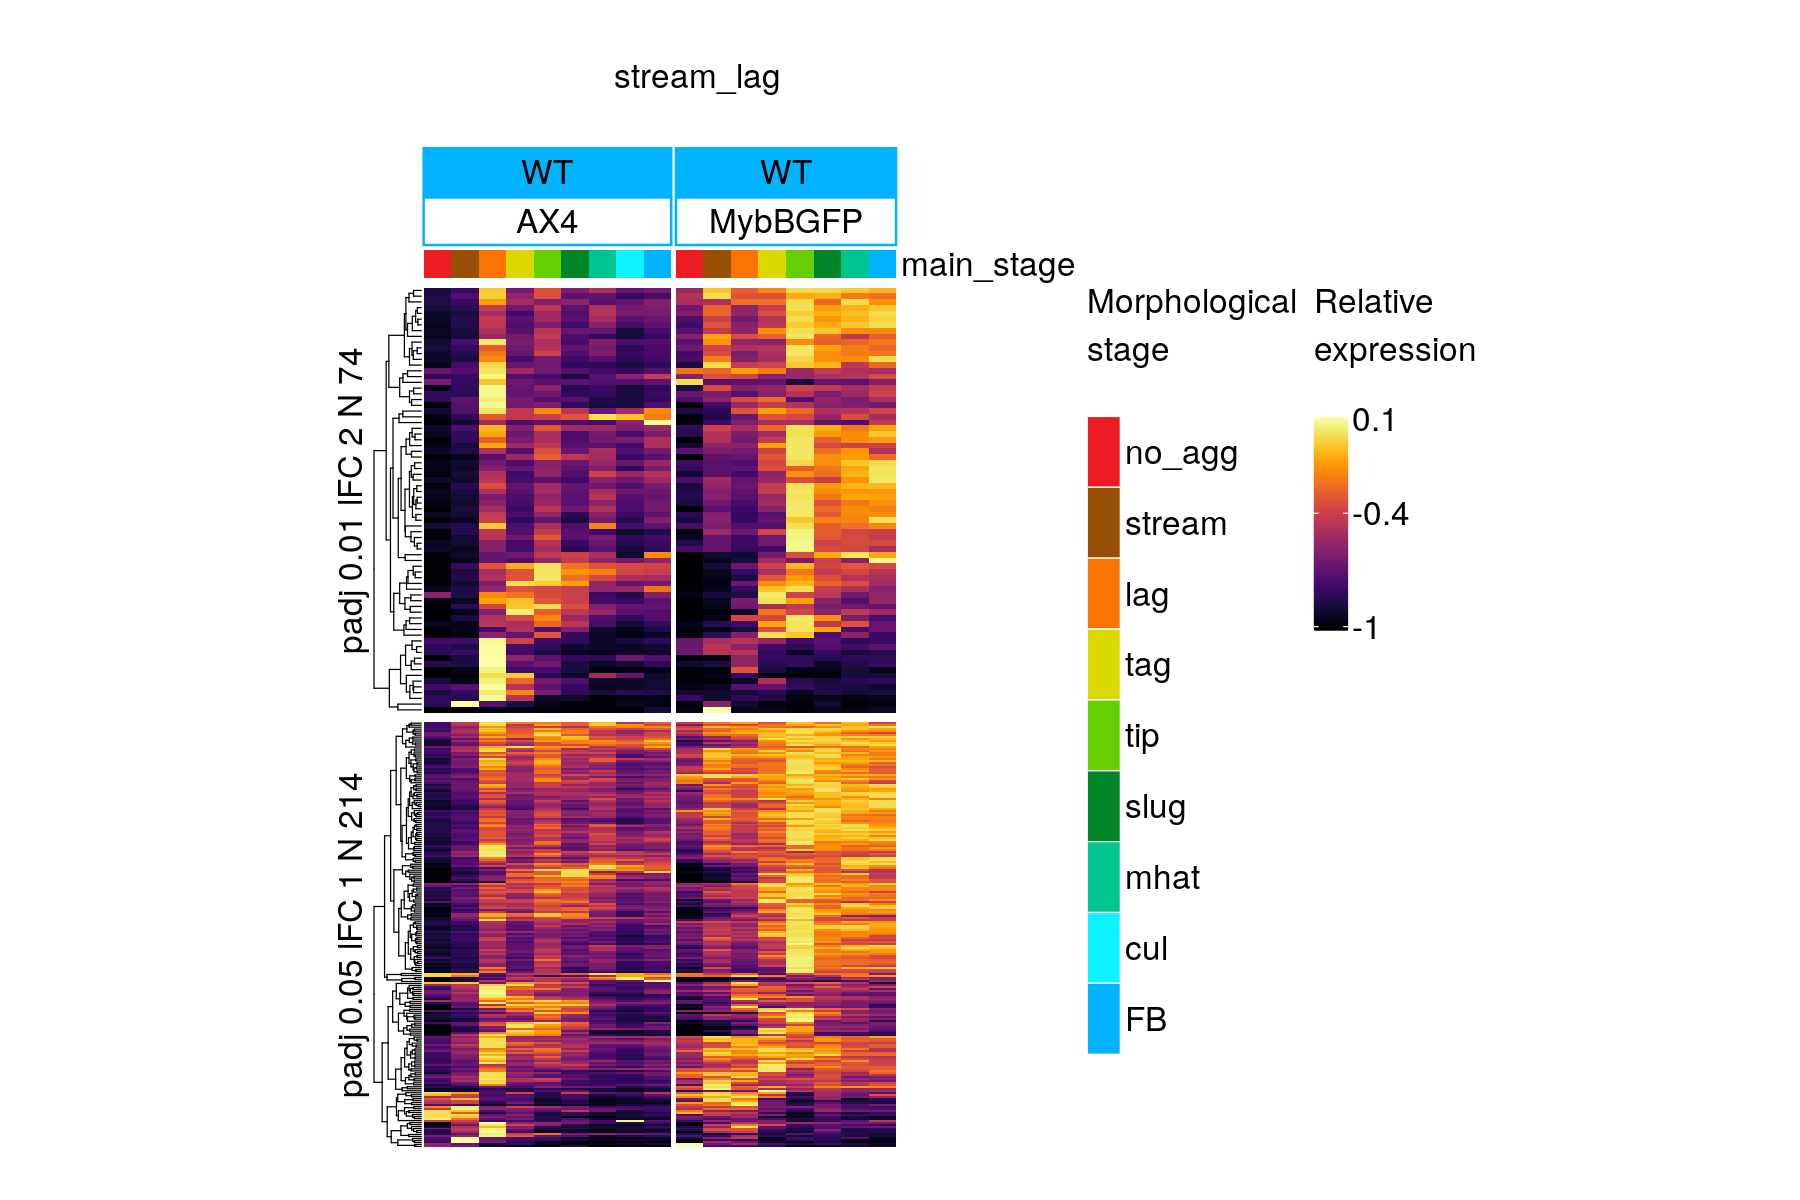

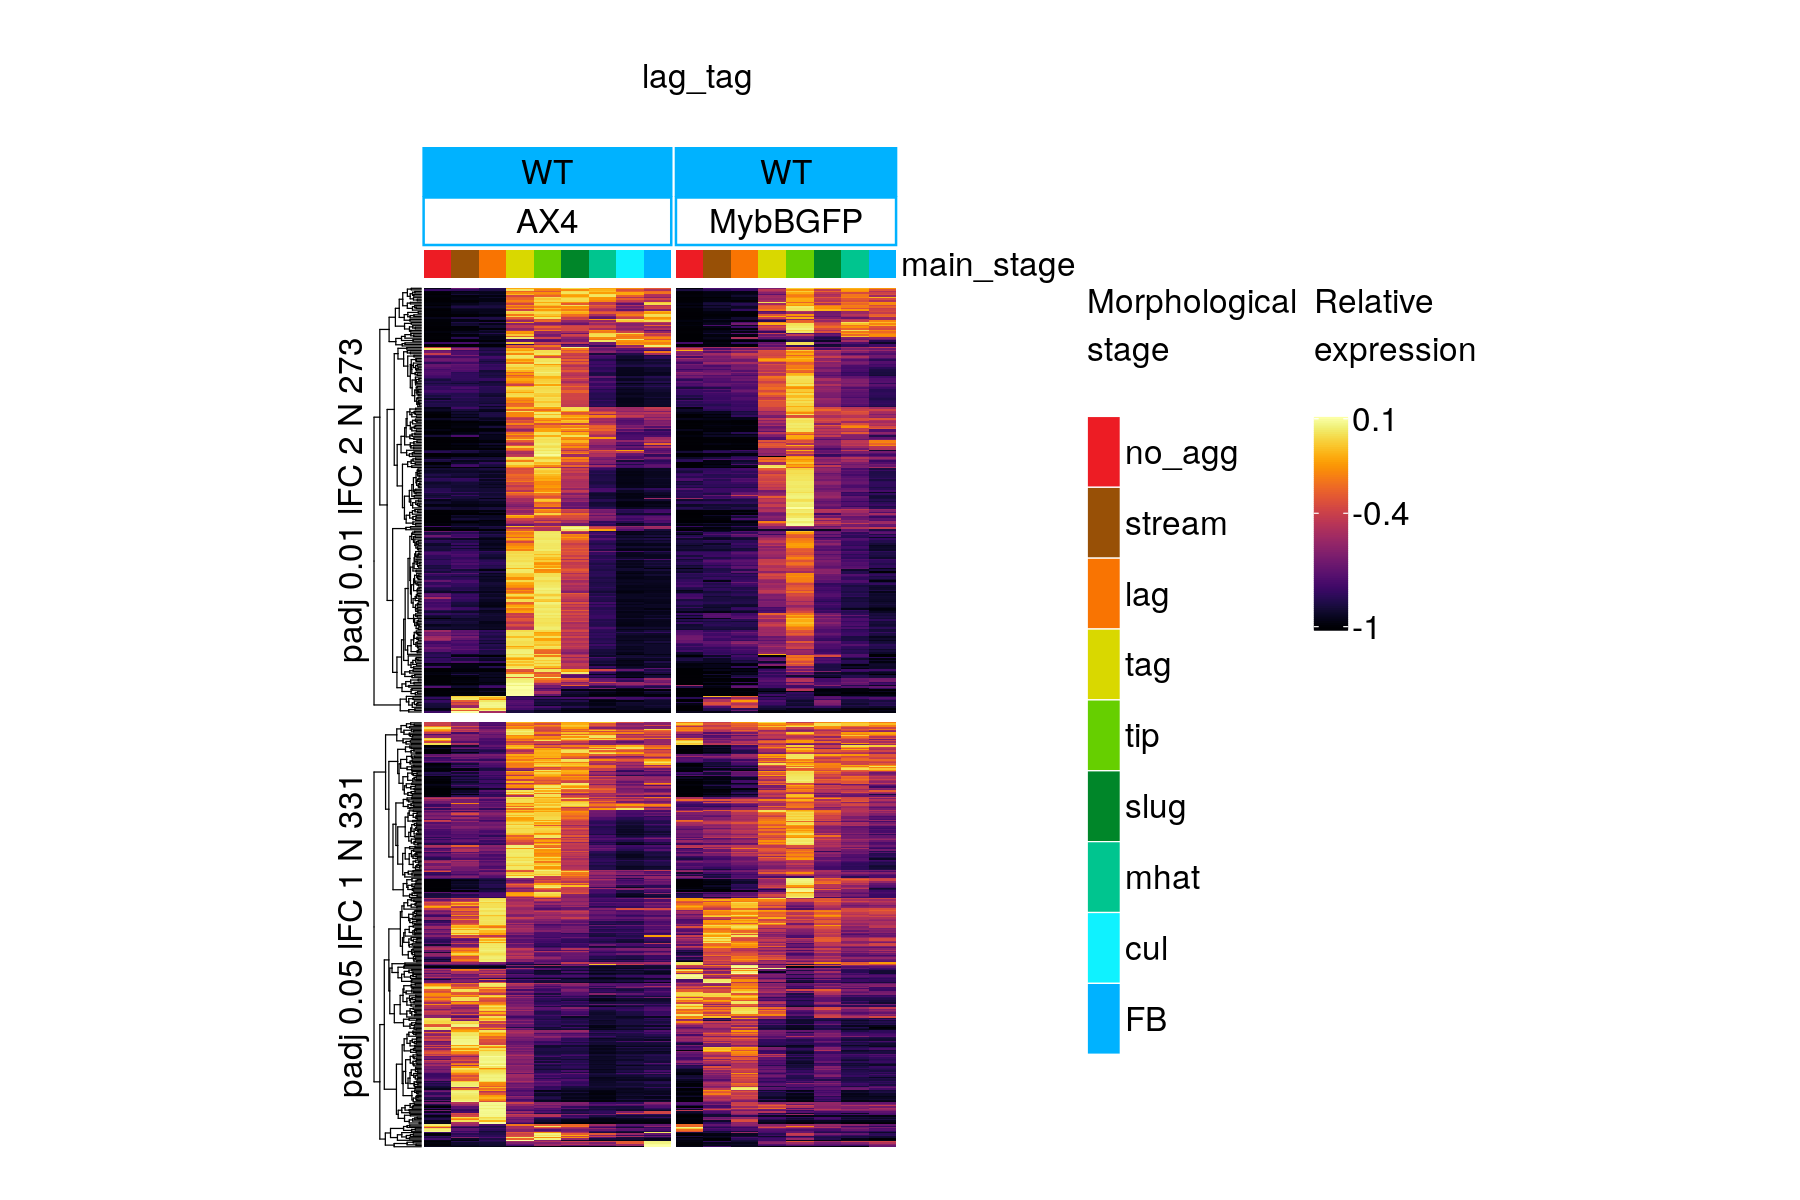

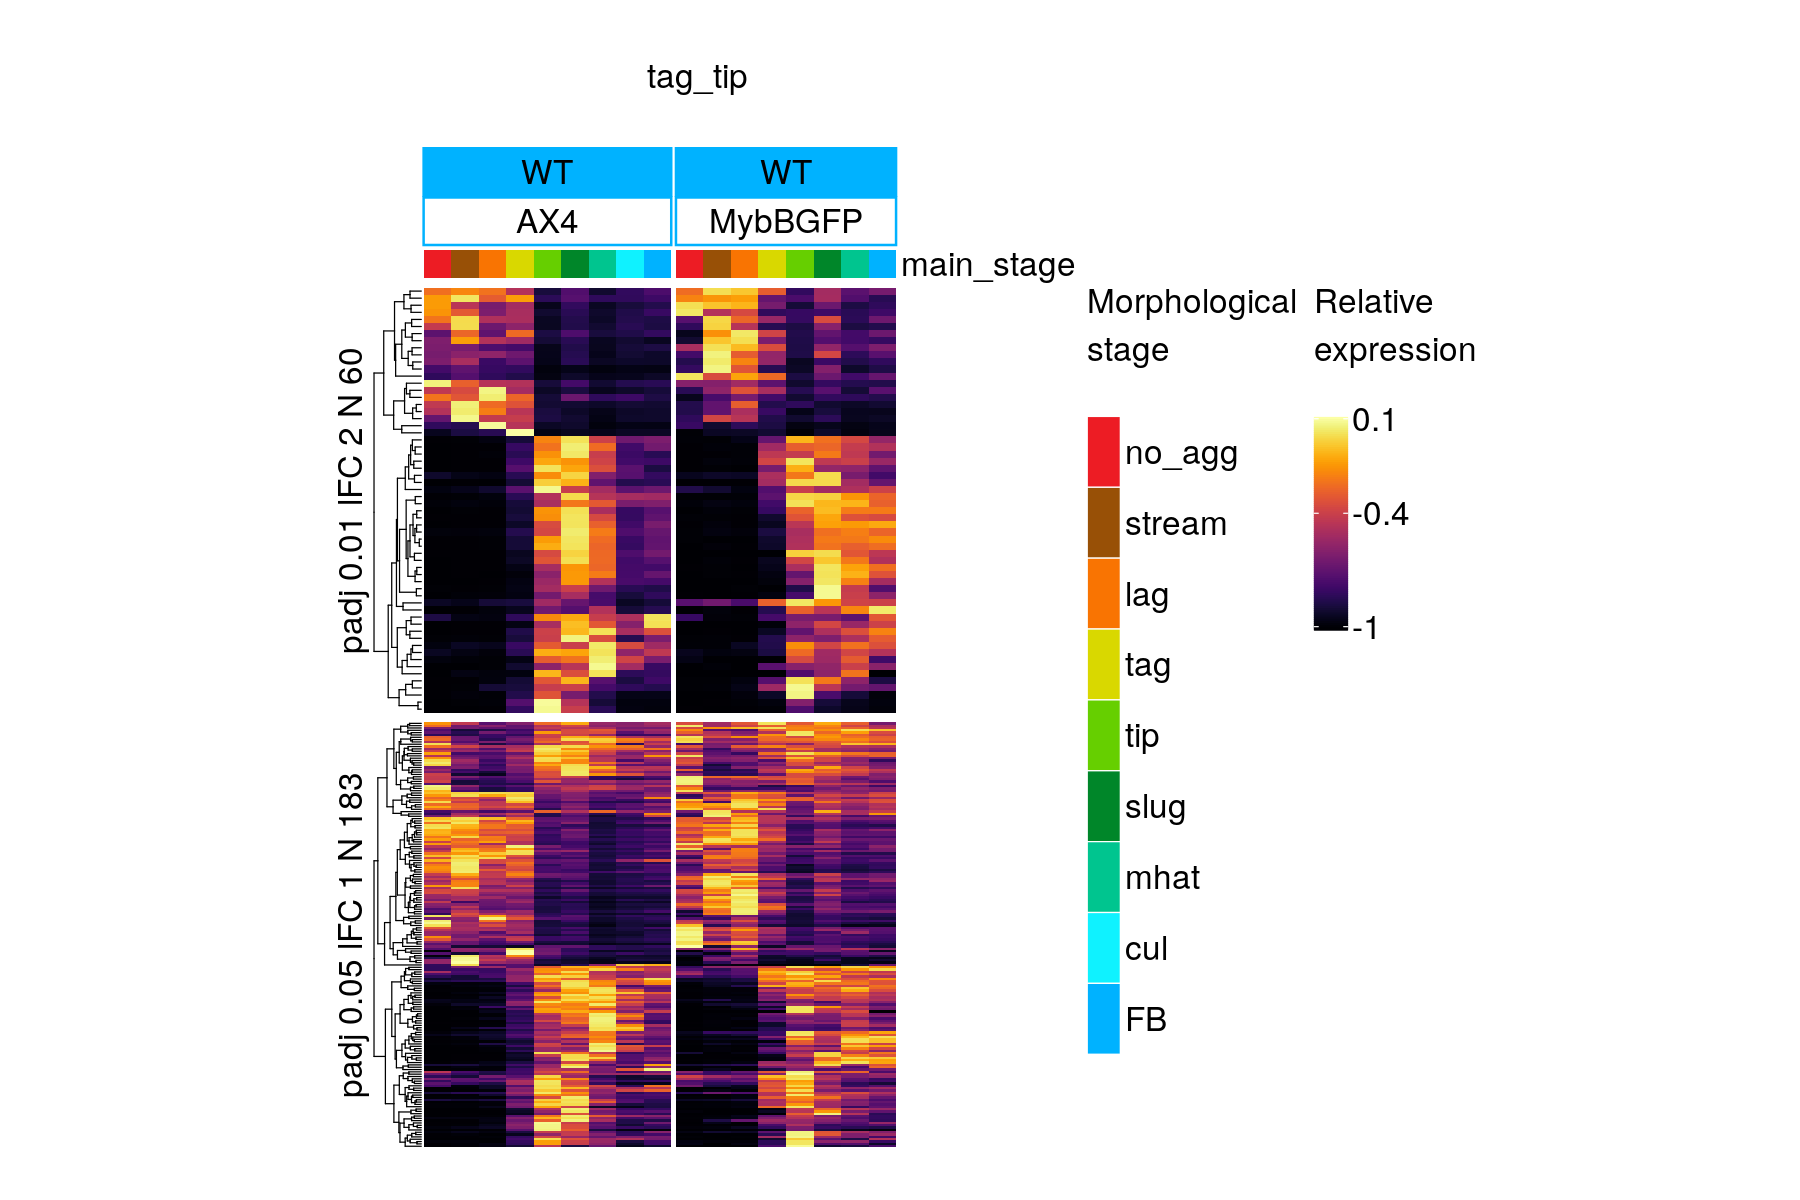

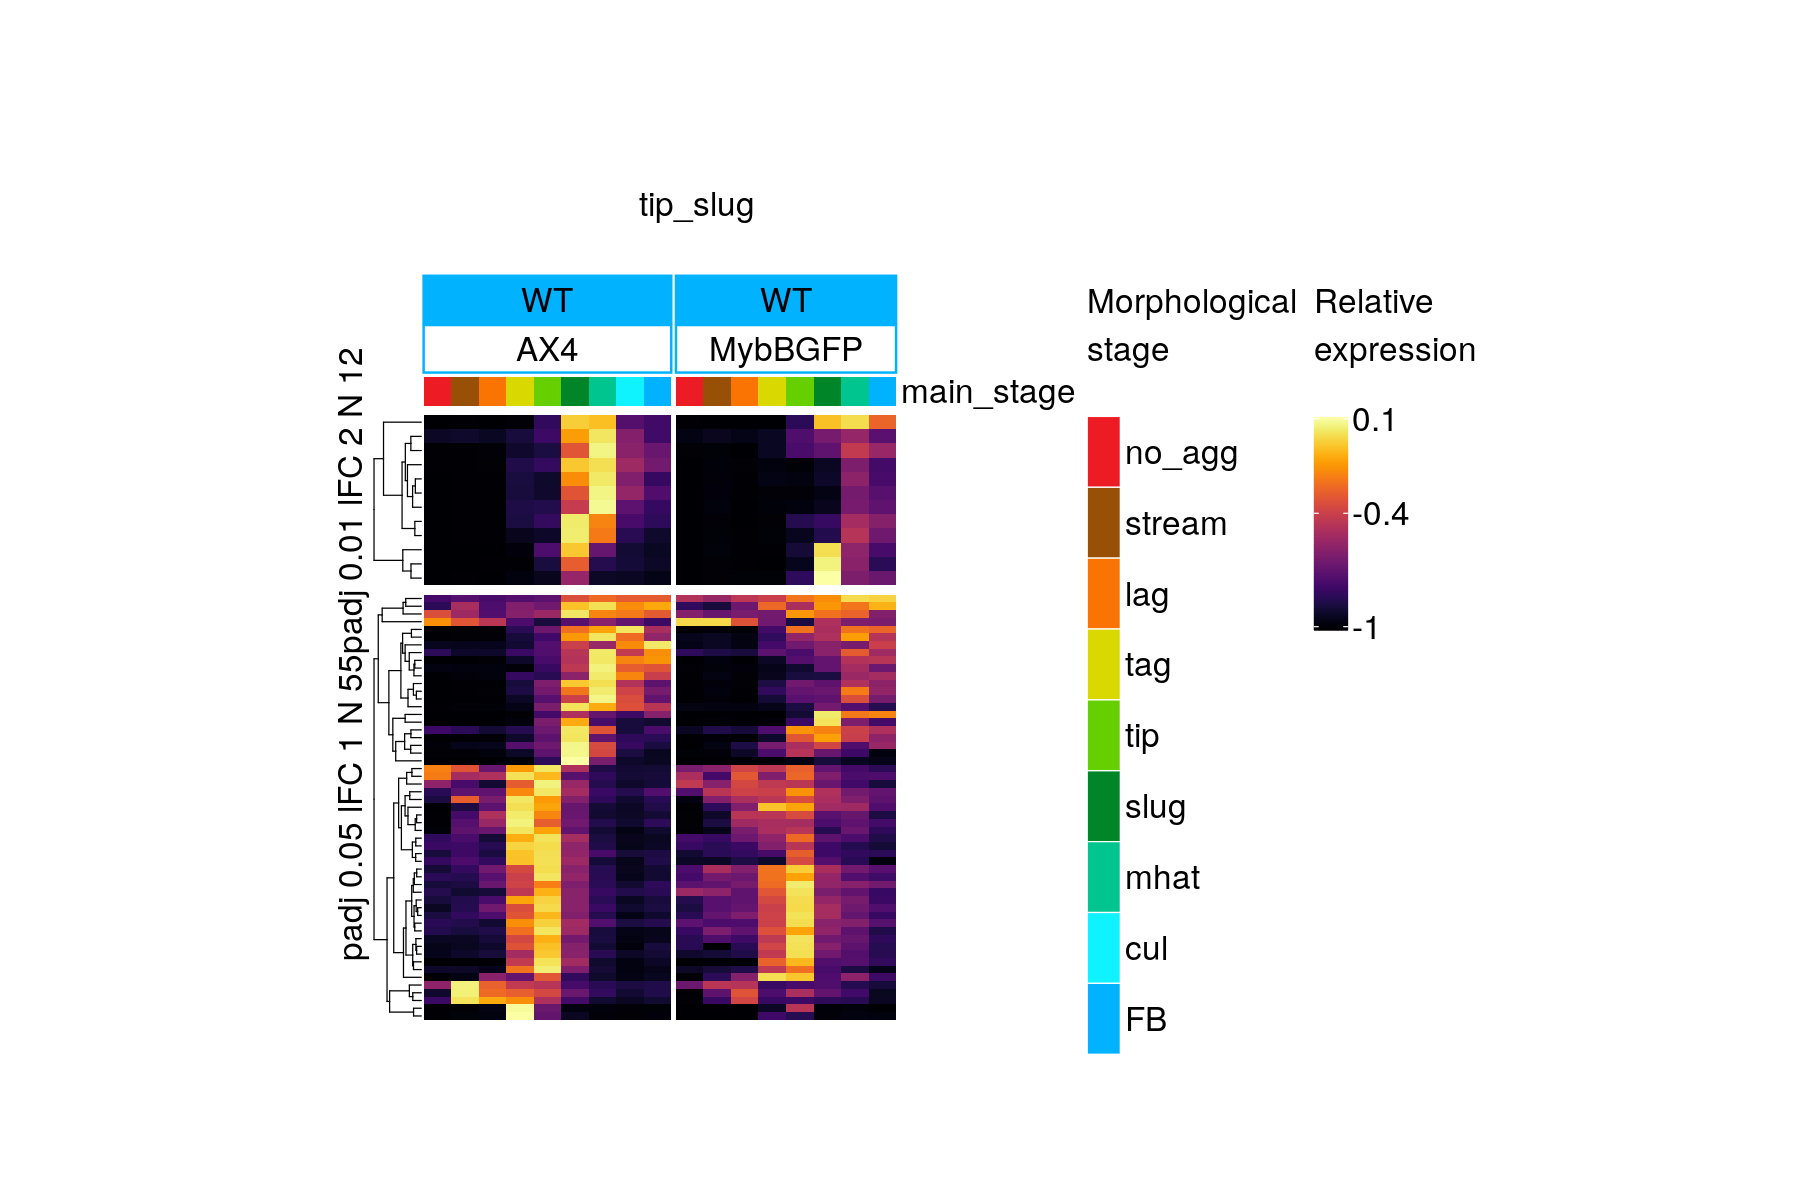

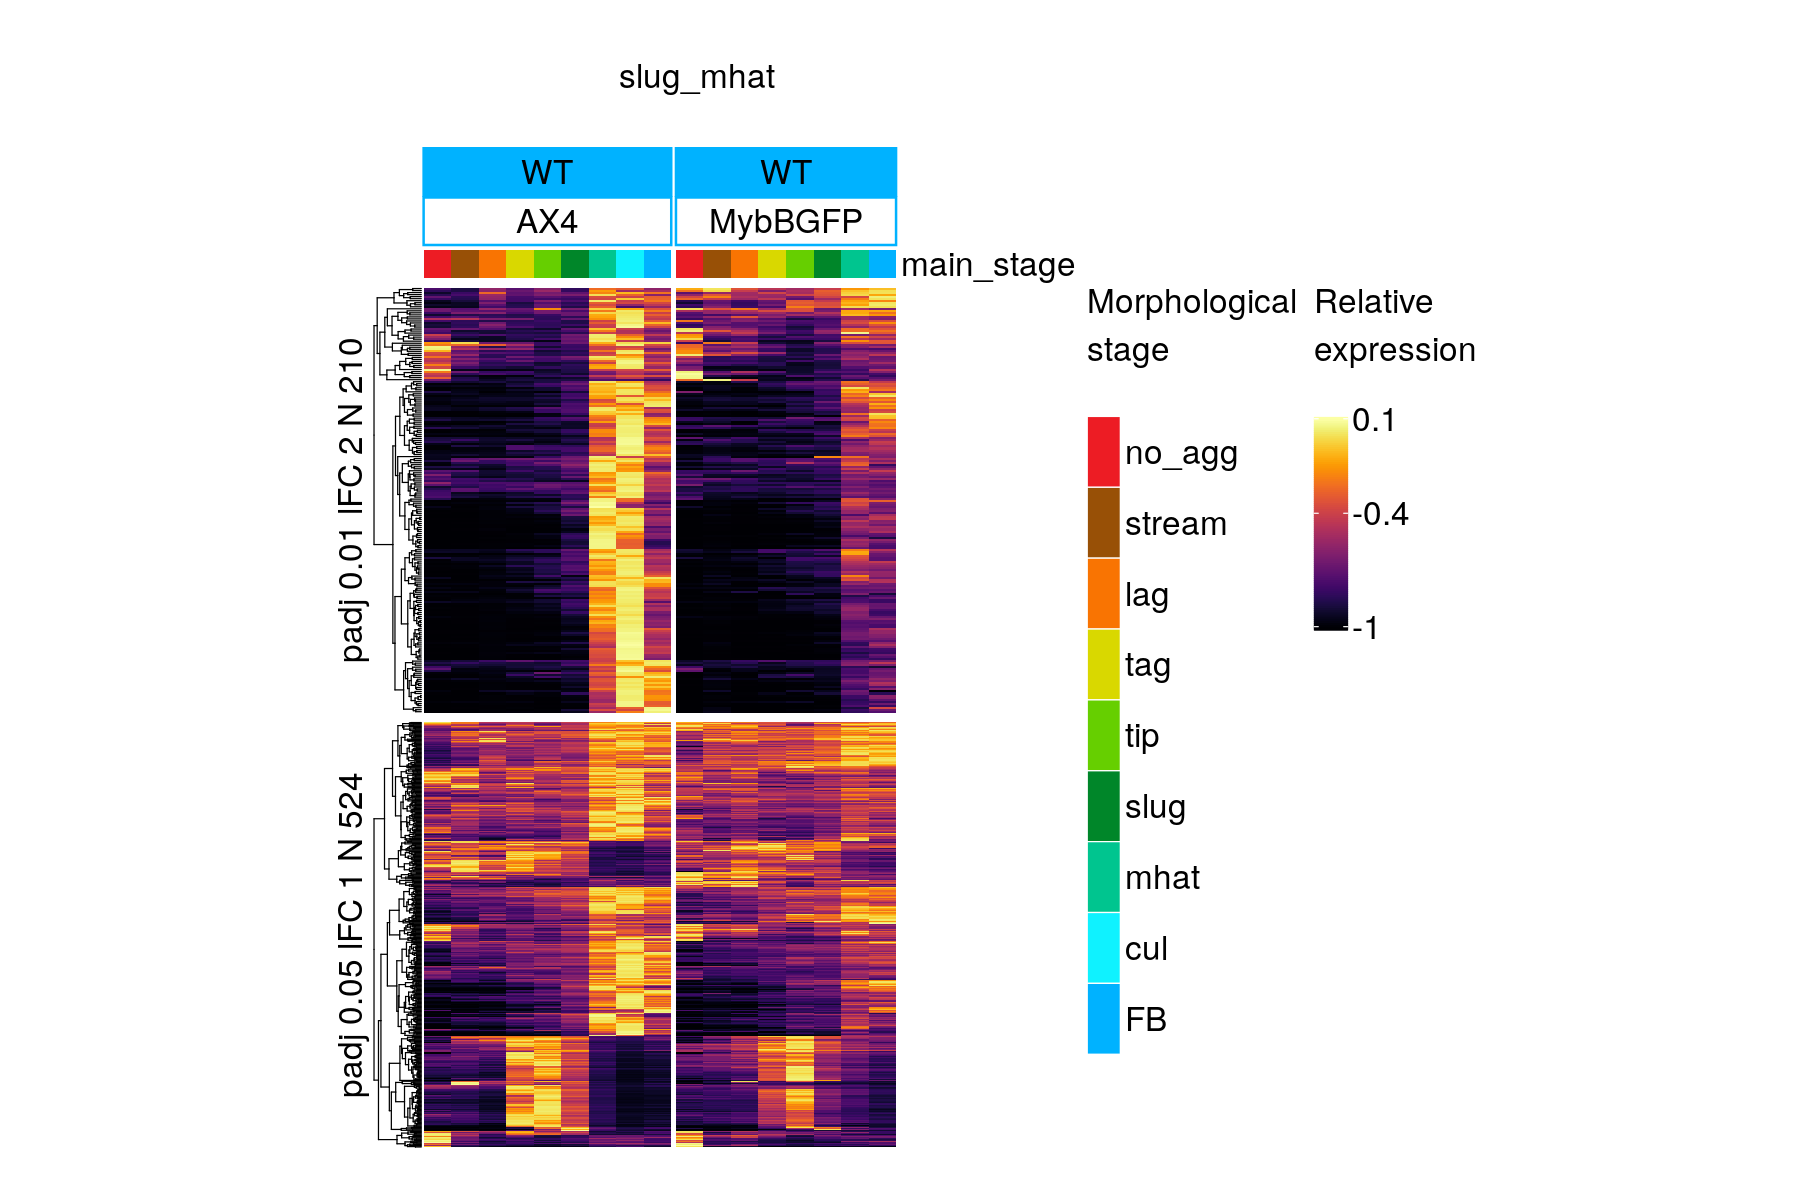

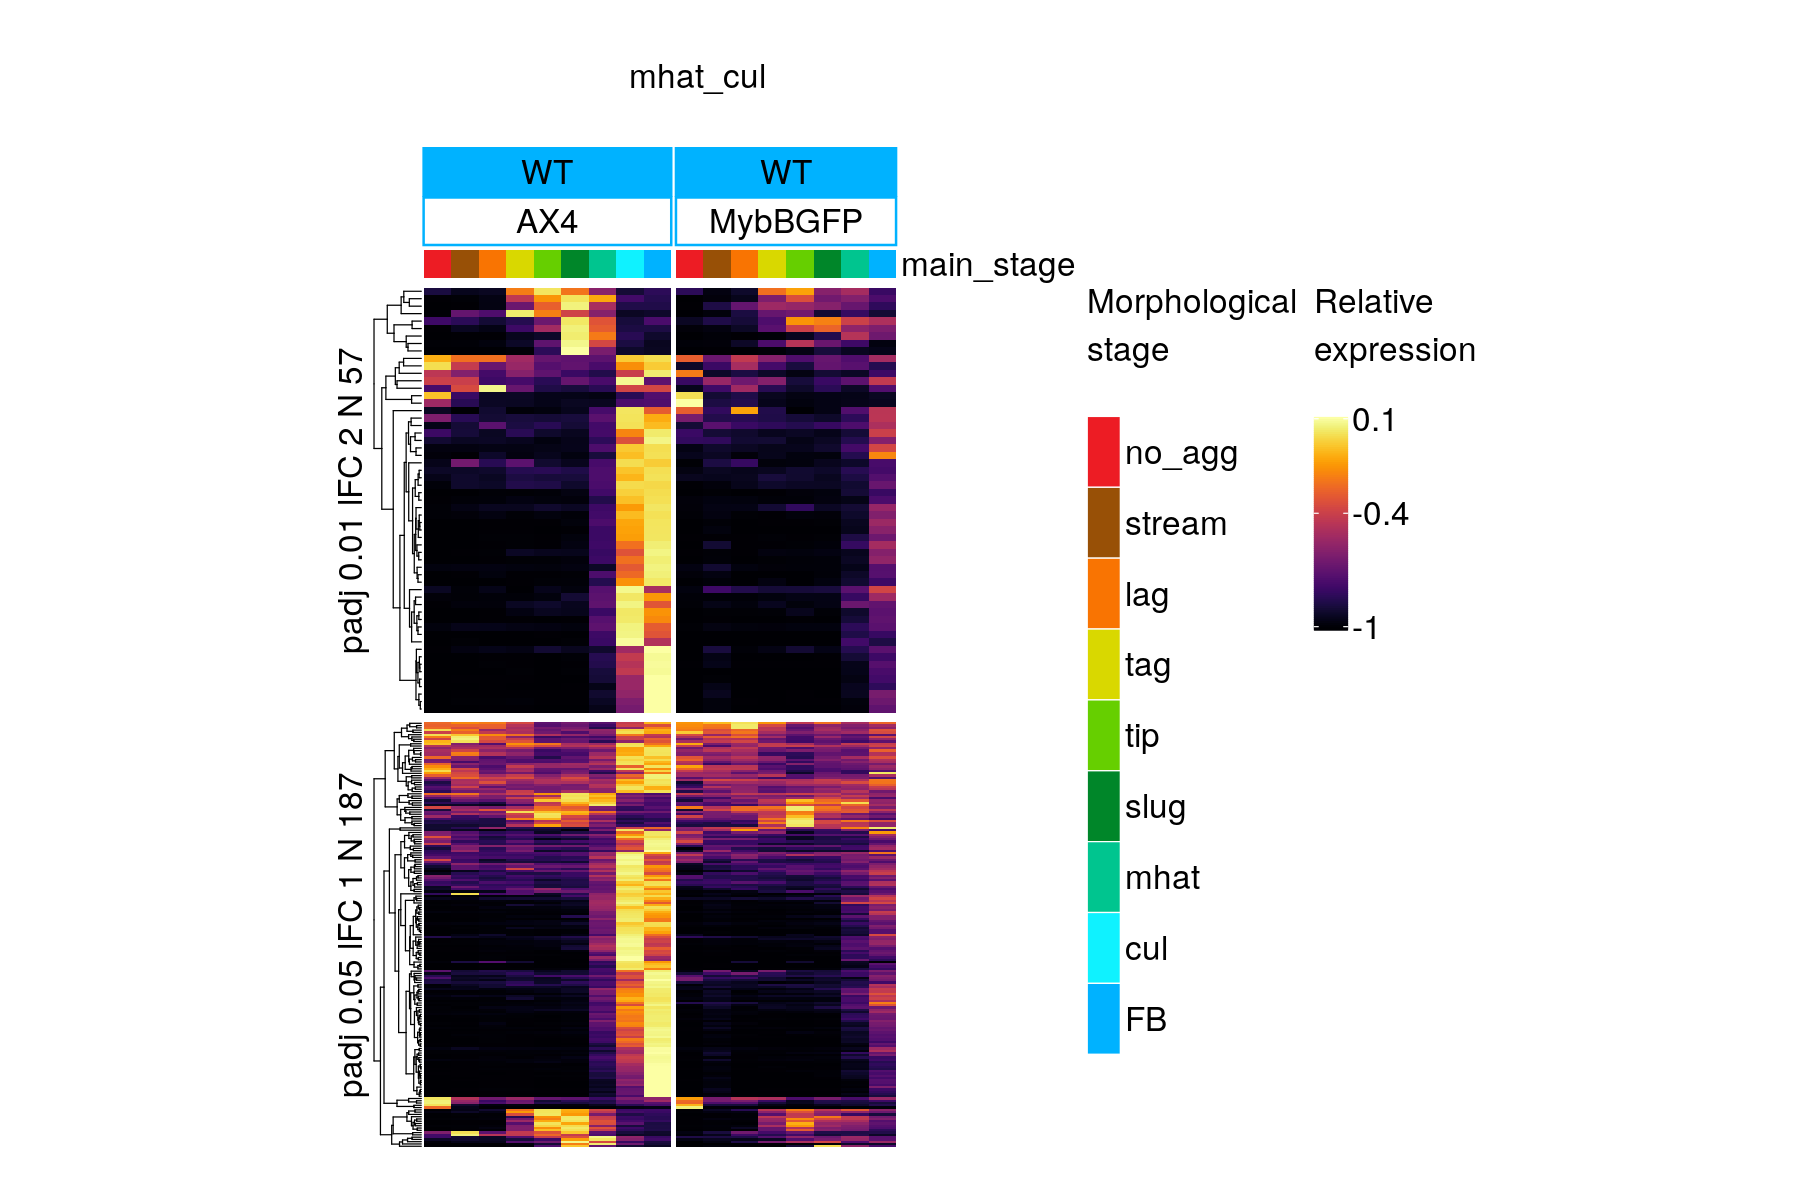

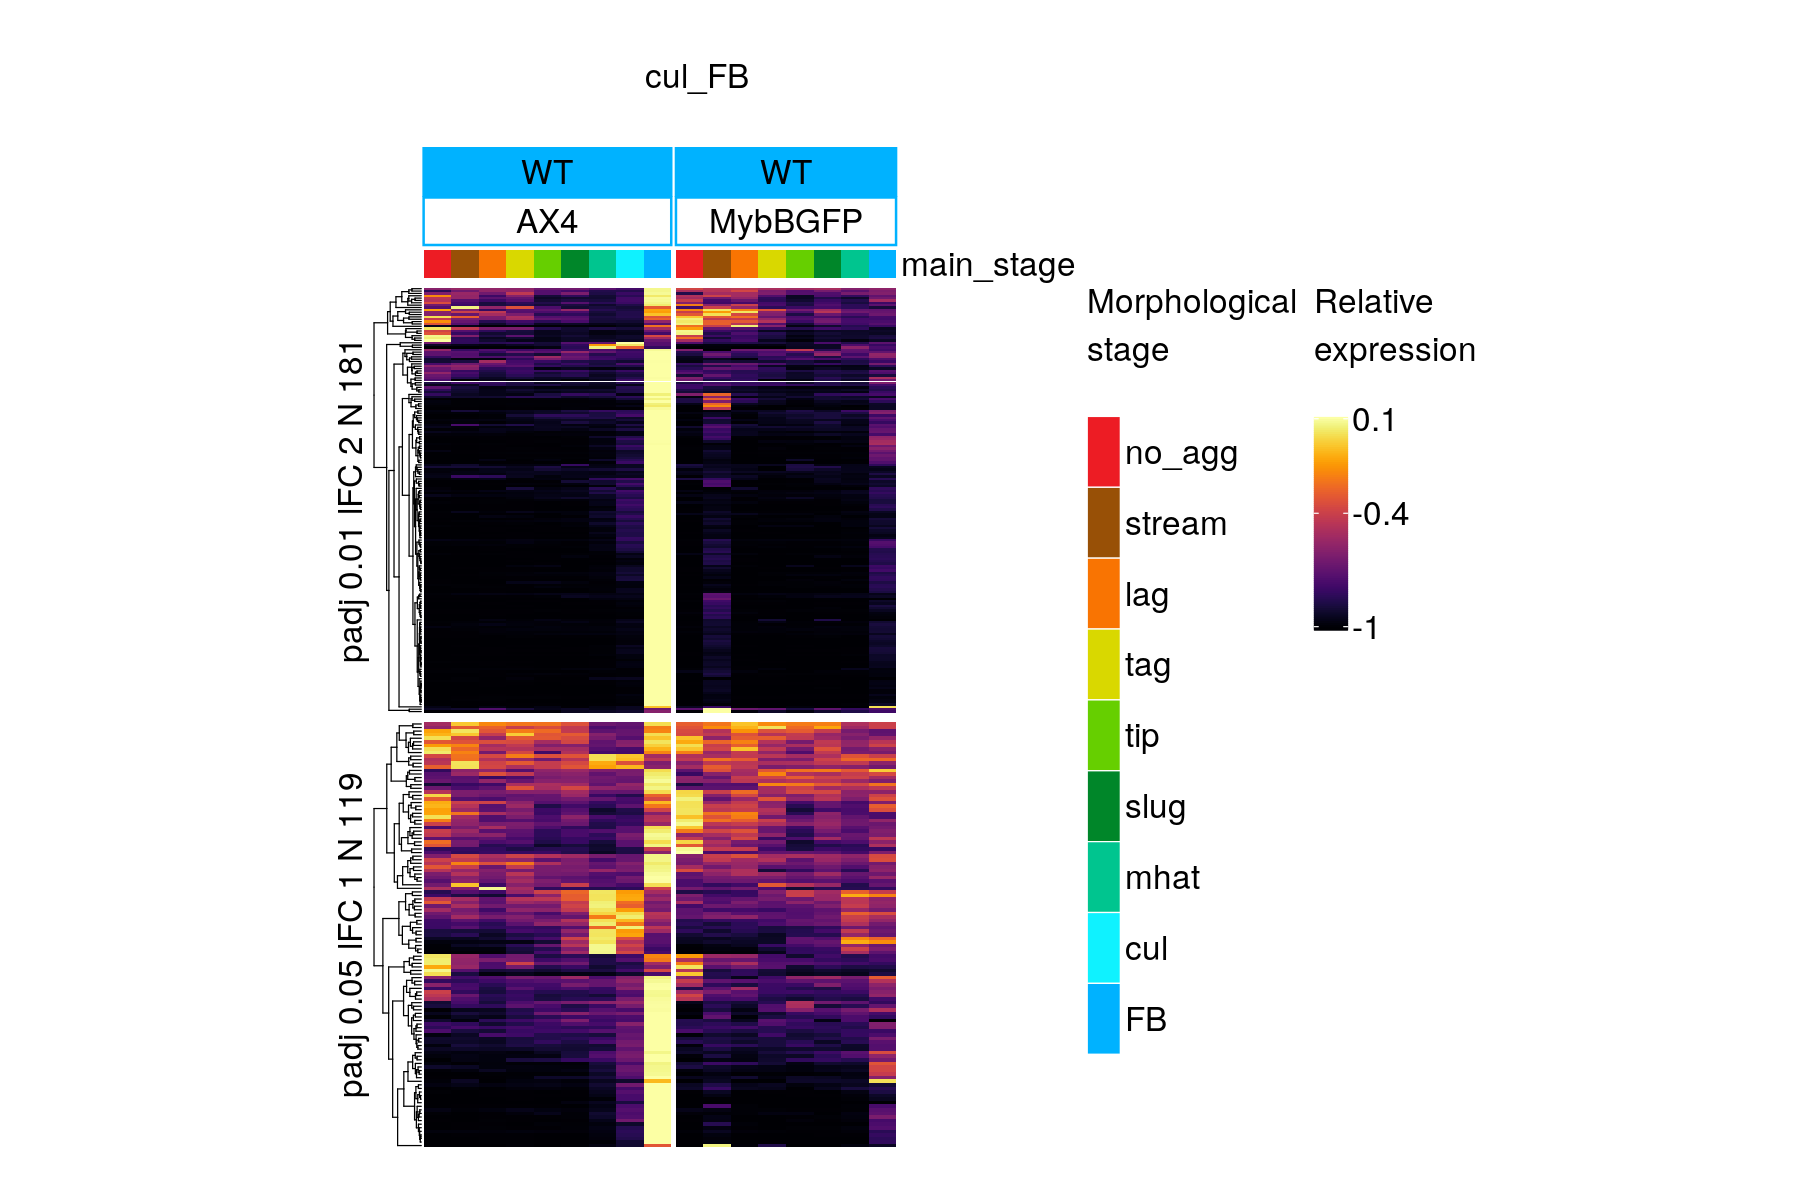

In [19]:
for (comparison in comparisons){
    fc_col=paste(comparison,'_log2FoldChange',sep='')
    fdr_col=paste(comparison,'_FDR_overall',sep='')
    data_defined=data_AX4[!is.na(data_AX4[fc_col]) & !is.na(data_AX4[fdr_col]) & !is.na(data_AX4[comparison]),]
    first=TRUE
    heatmaps=make_anno()
    for(param_idx in 1:nrow(params_data)){
        padj=params_data[param_idx,'padj_max'] 
        lfc=params_data[param_idx,'lfc_min']
        genes<-rownames(data_defined[abs(data_defined[fc_col])>=params_data[param_idx,'lfc_min'] & 
                        data_defined[fdr_col]<=params_data[param_idx,'padj_max'] &
                        data_defined[comparison]==1,])
        genes_previous=c()
        if (param_idx>1) genes_previous=rownames(
                        data_defined[abs(data_defined[fc_col])>=params_data[param_idx-1,'lfc_min'] & 
                        data_defined[fdr_col]<=params_data[param_idx-1,'padj_max'] &
                        data_defined[comparison]==1,])
        genes<-genes[which(!genes %in% genes_previous)]
    
        expression=t(avg_expression[avg_expression$Strain=='AX4',genes])
        #expression=t(avg_expression[,genes])
        distances<-dist(expression, method="cosine")
        hc<-hclust(d=distances, method = "ward.D2" )
        hc_ordered<-reorder(x=hc,dist = distances)
        genes<- as.dendrogram(hc_ordered) %>% labels

        n_genes=length(genes)
        #print(paste(comparison,n_genes))
        data_anno=paste('padj',params_data[param_idx,'padj_max'],'lFC',params_data[param_idx,'lfc_min'],'N',n_genes)
        height=0.3*n_genes
        if (height>9) height=9
        heatmap=Heatmap(t(avg_expression[,genes]),cluster_columns = FALSE,cluster_rows = TRUE,
                        show_column_names = FALSE,
                          show_row_names = FALSE, col=inferno(256),column_title=NULL, 
                          row_title=data_anno,
                          show_heatmap_legend = first,heatmap_legend_param = list(
                          title = "\nRelative \nexpression\n",
                          at = c(min_expression, round(mean(c(min_expression,max_expression)),1),max_expression),
                          grid_width= unit(legend_width, "cm"),grid_height= unit(legened_height, "cm") ,
                          labels_gp = gpar(fontsize = cluster_font),title_gp = gpar(fontsize = cluster_font)),
                          #** Cluster name fontsize
                          row_title_gp=gpar(fontsize=cluster_font),height=unit(height, "cm"))
        first=FALSE
        heatmaps = heatmaps %v% heatmap
    }
    draw(heatmaps,width=unit(10, "cm"),
            column_title =paste(comparison,'\n'),column_title_gp = gpar(fontsize = cluster_font))

}

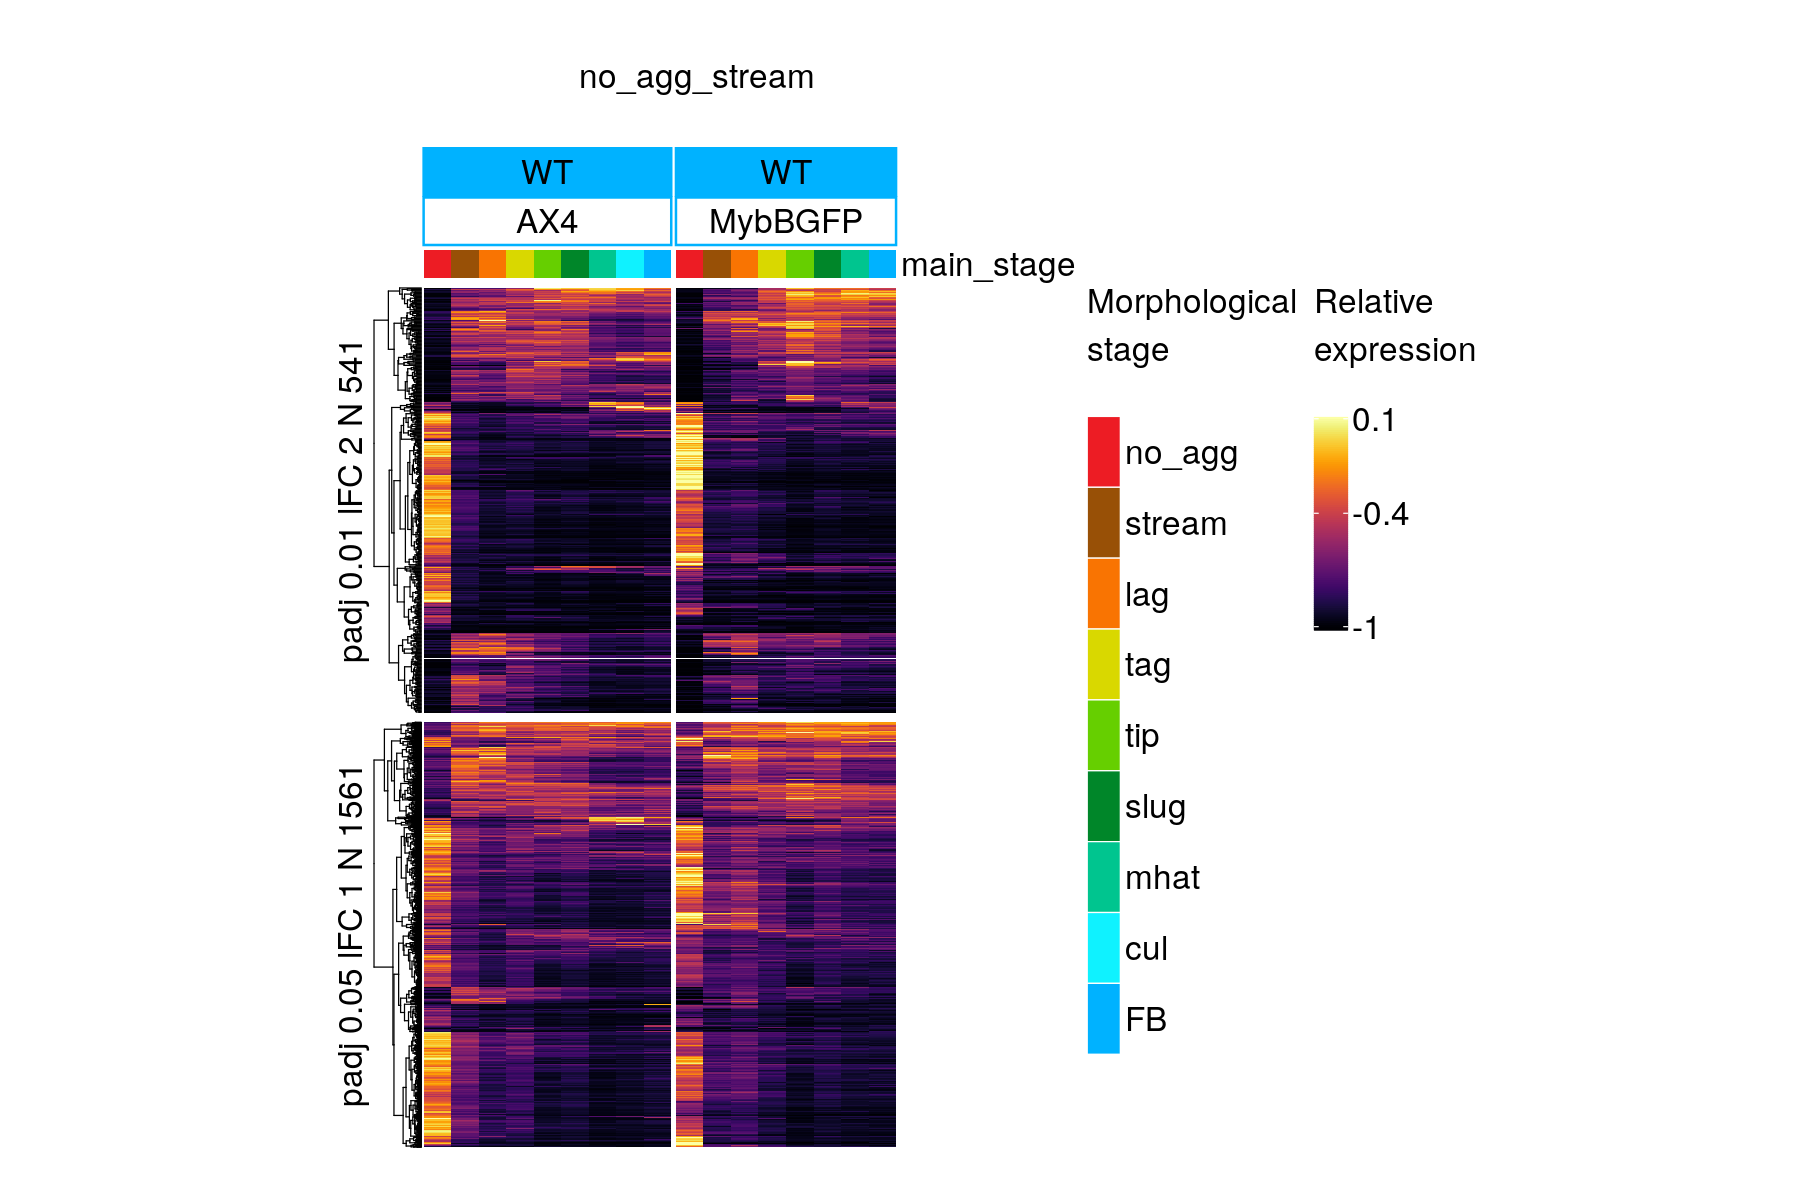

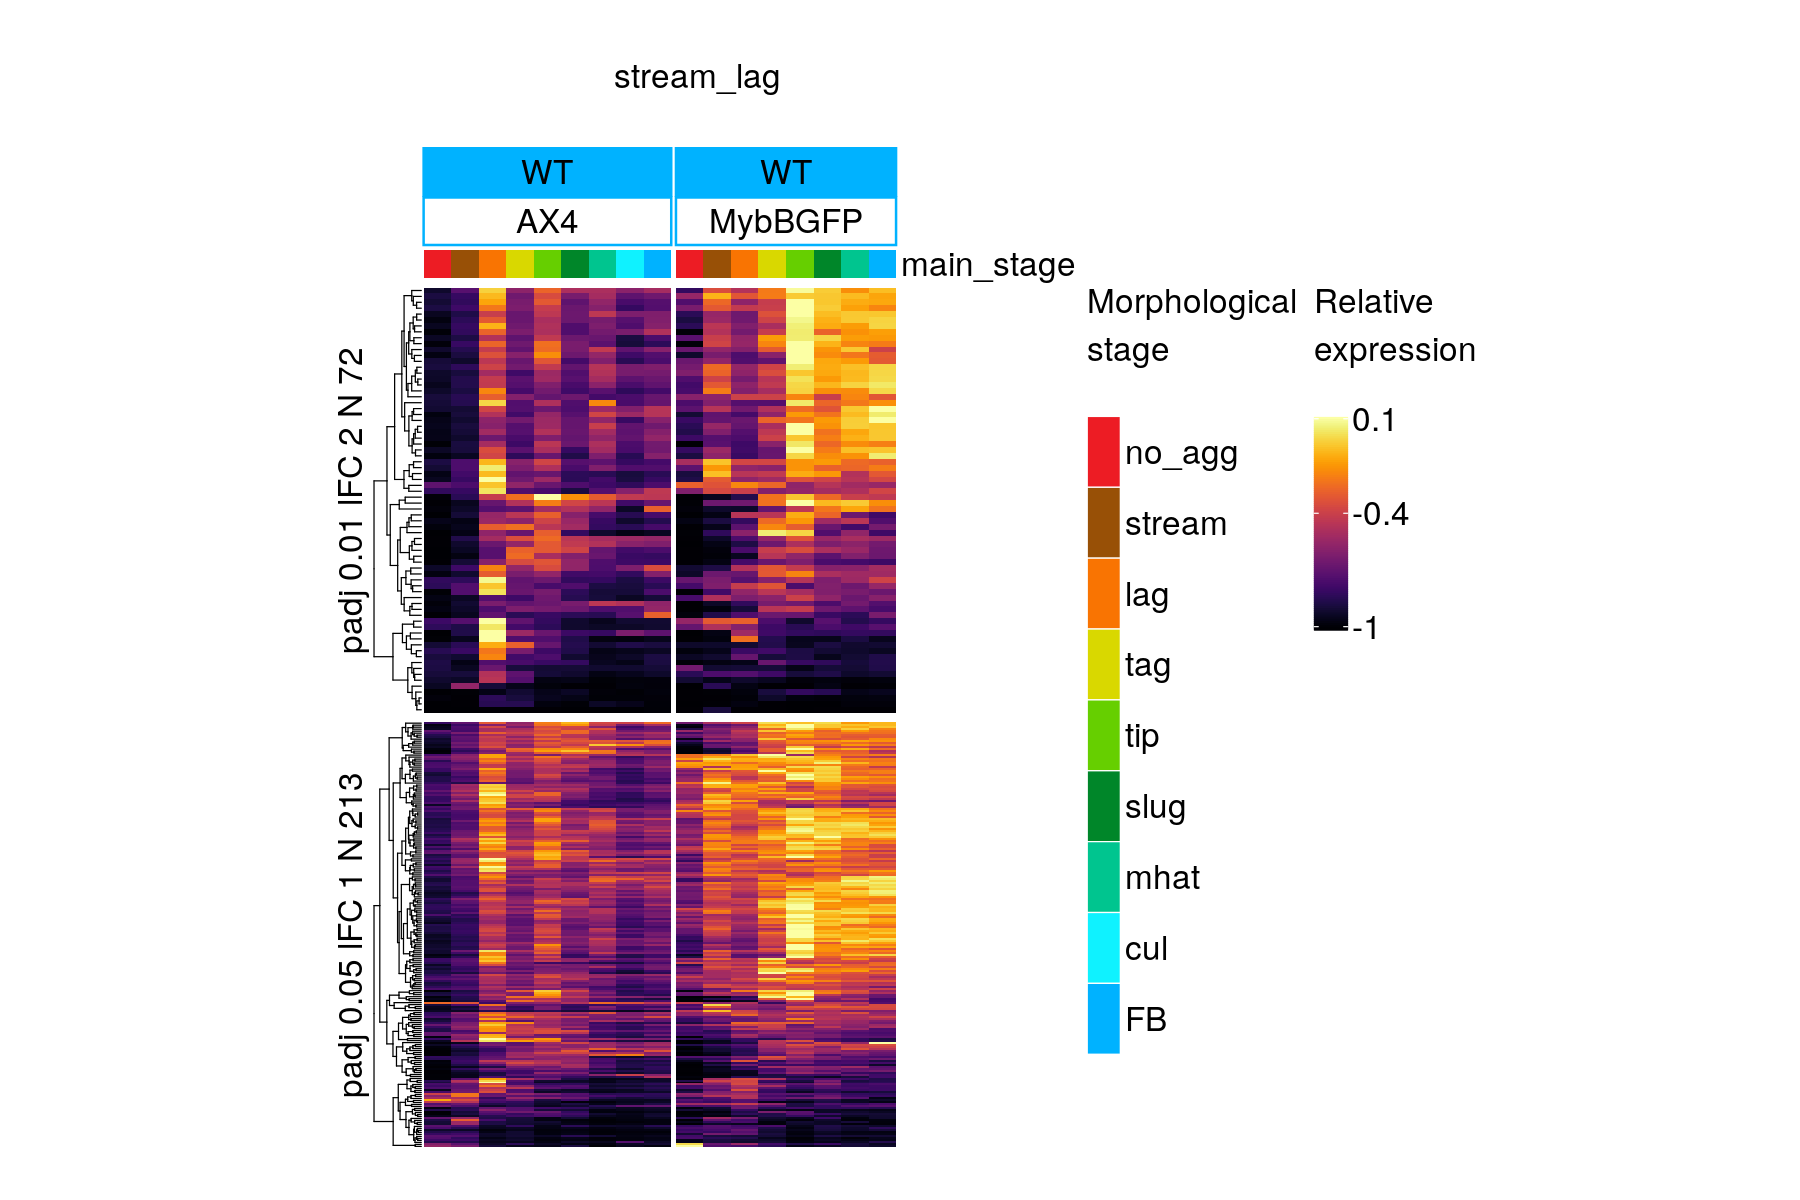

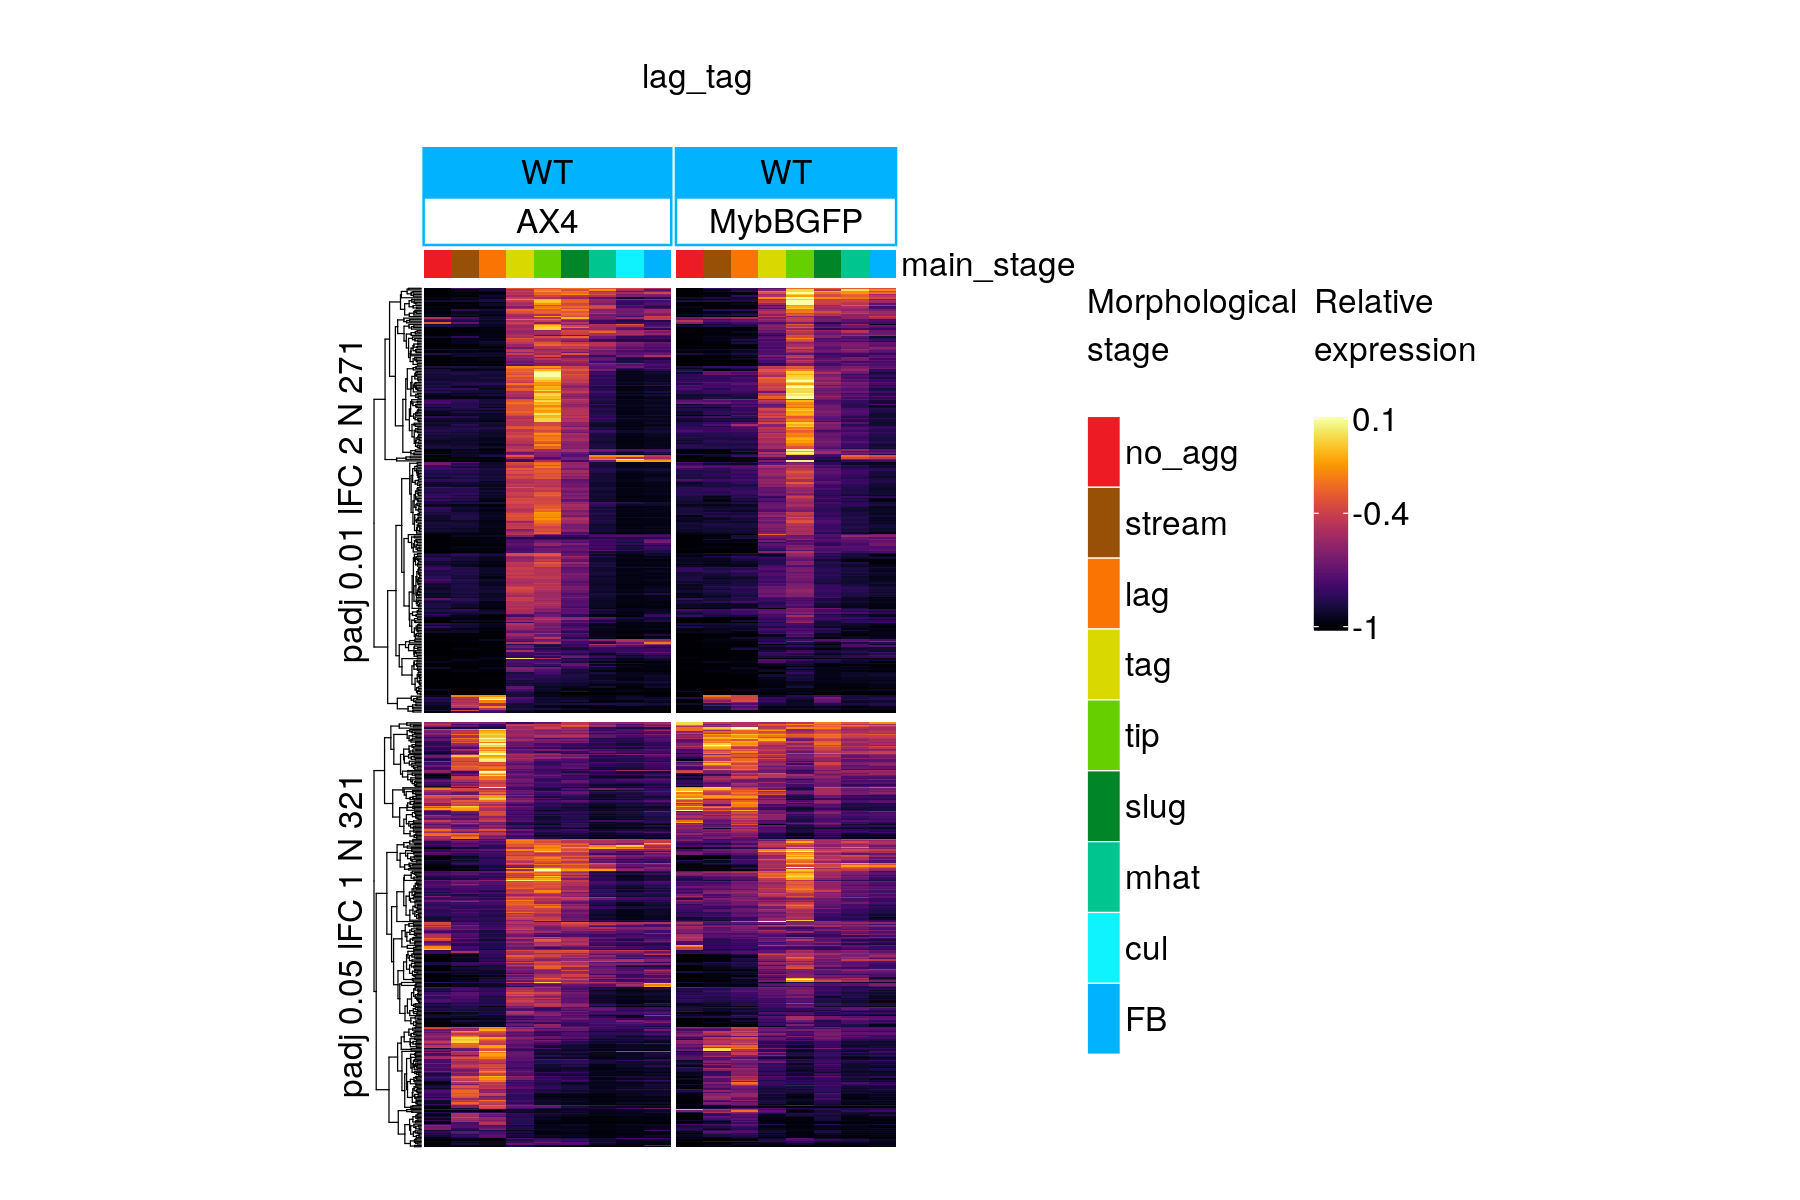

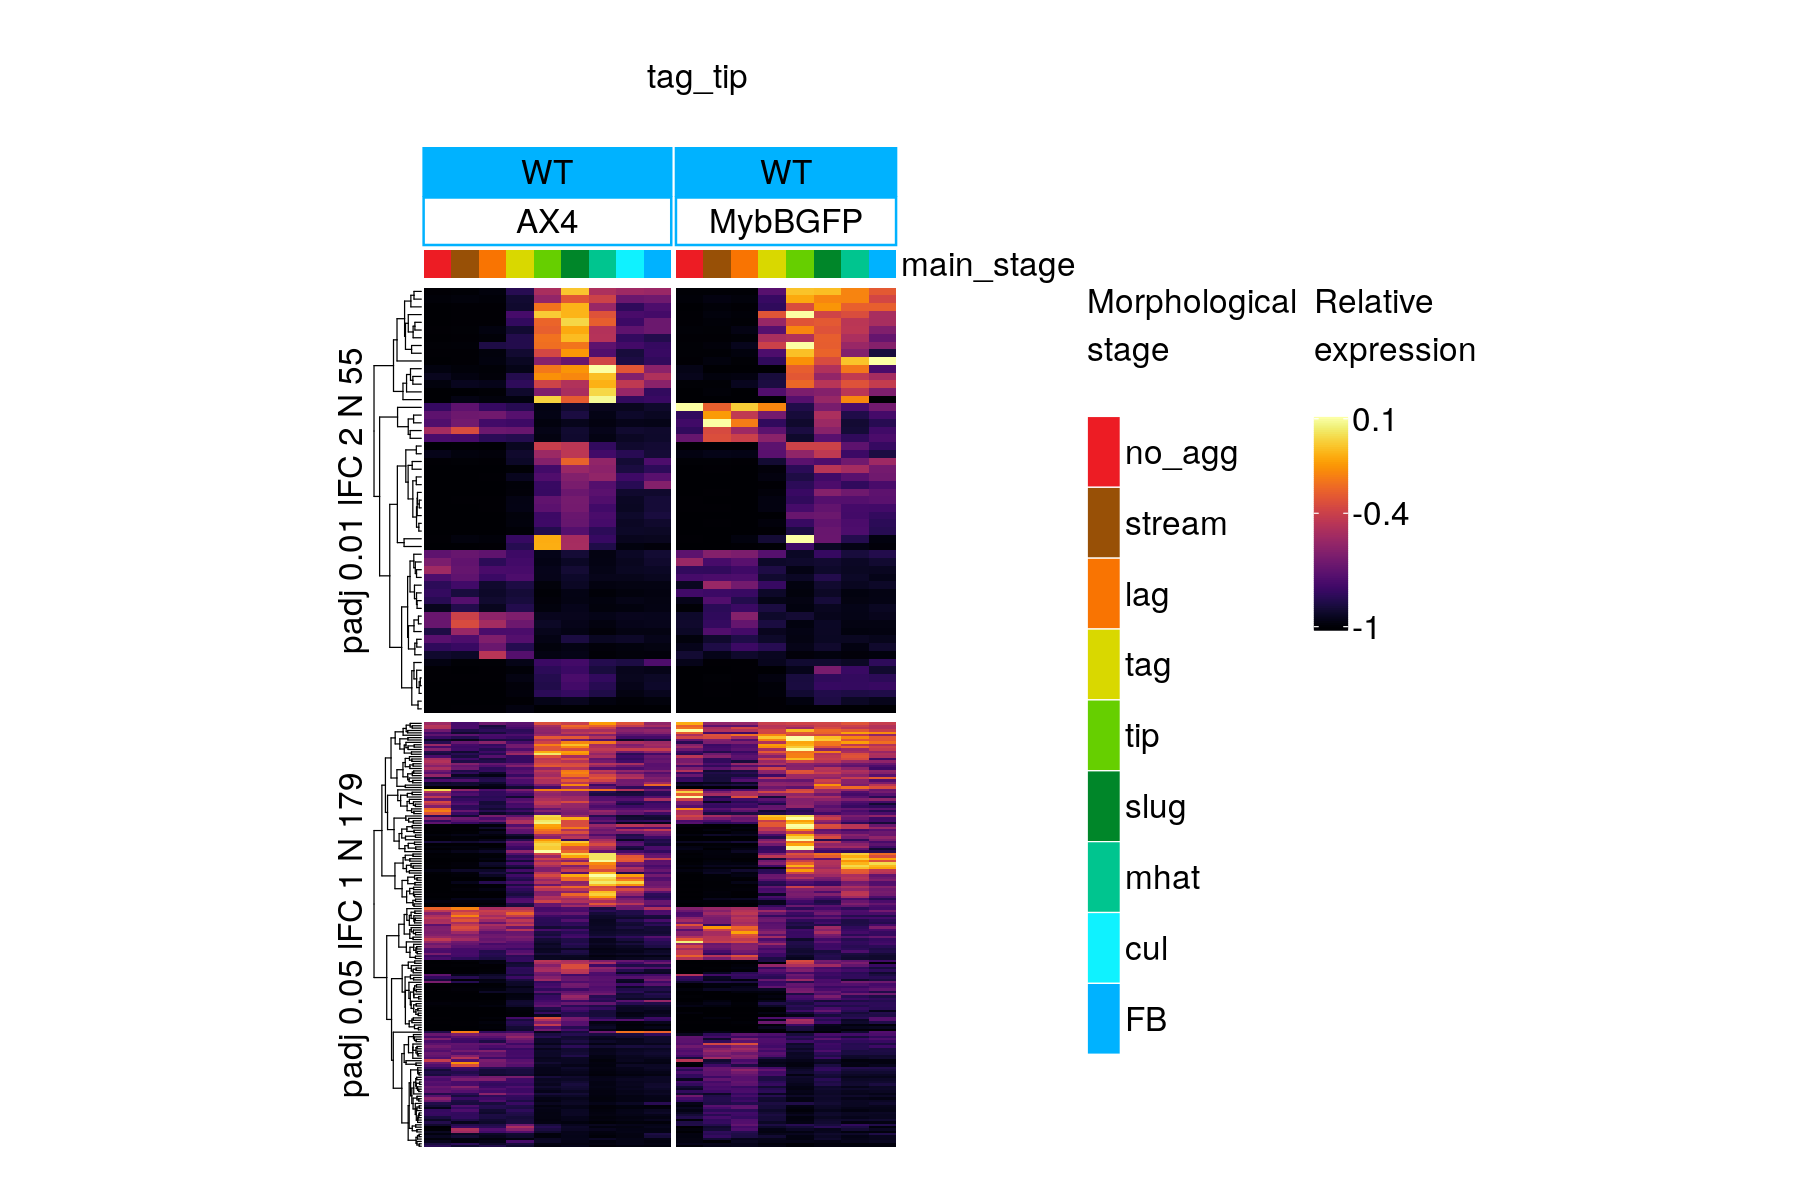

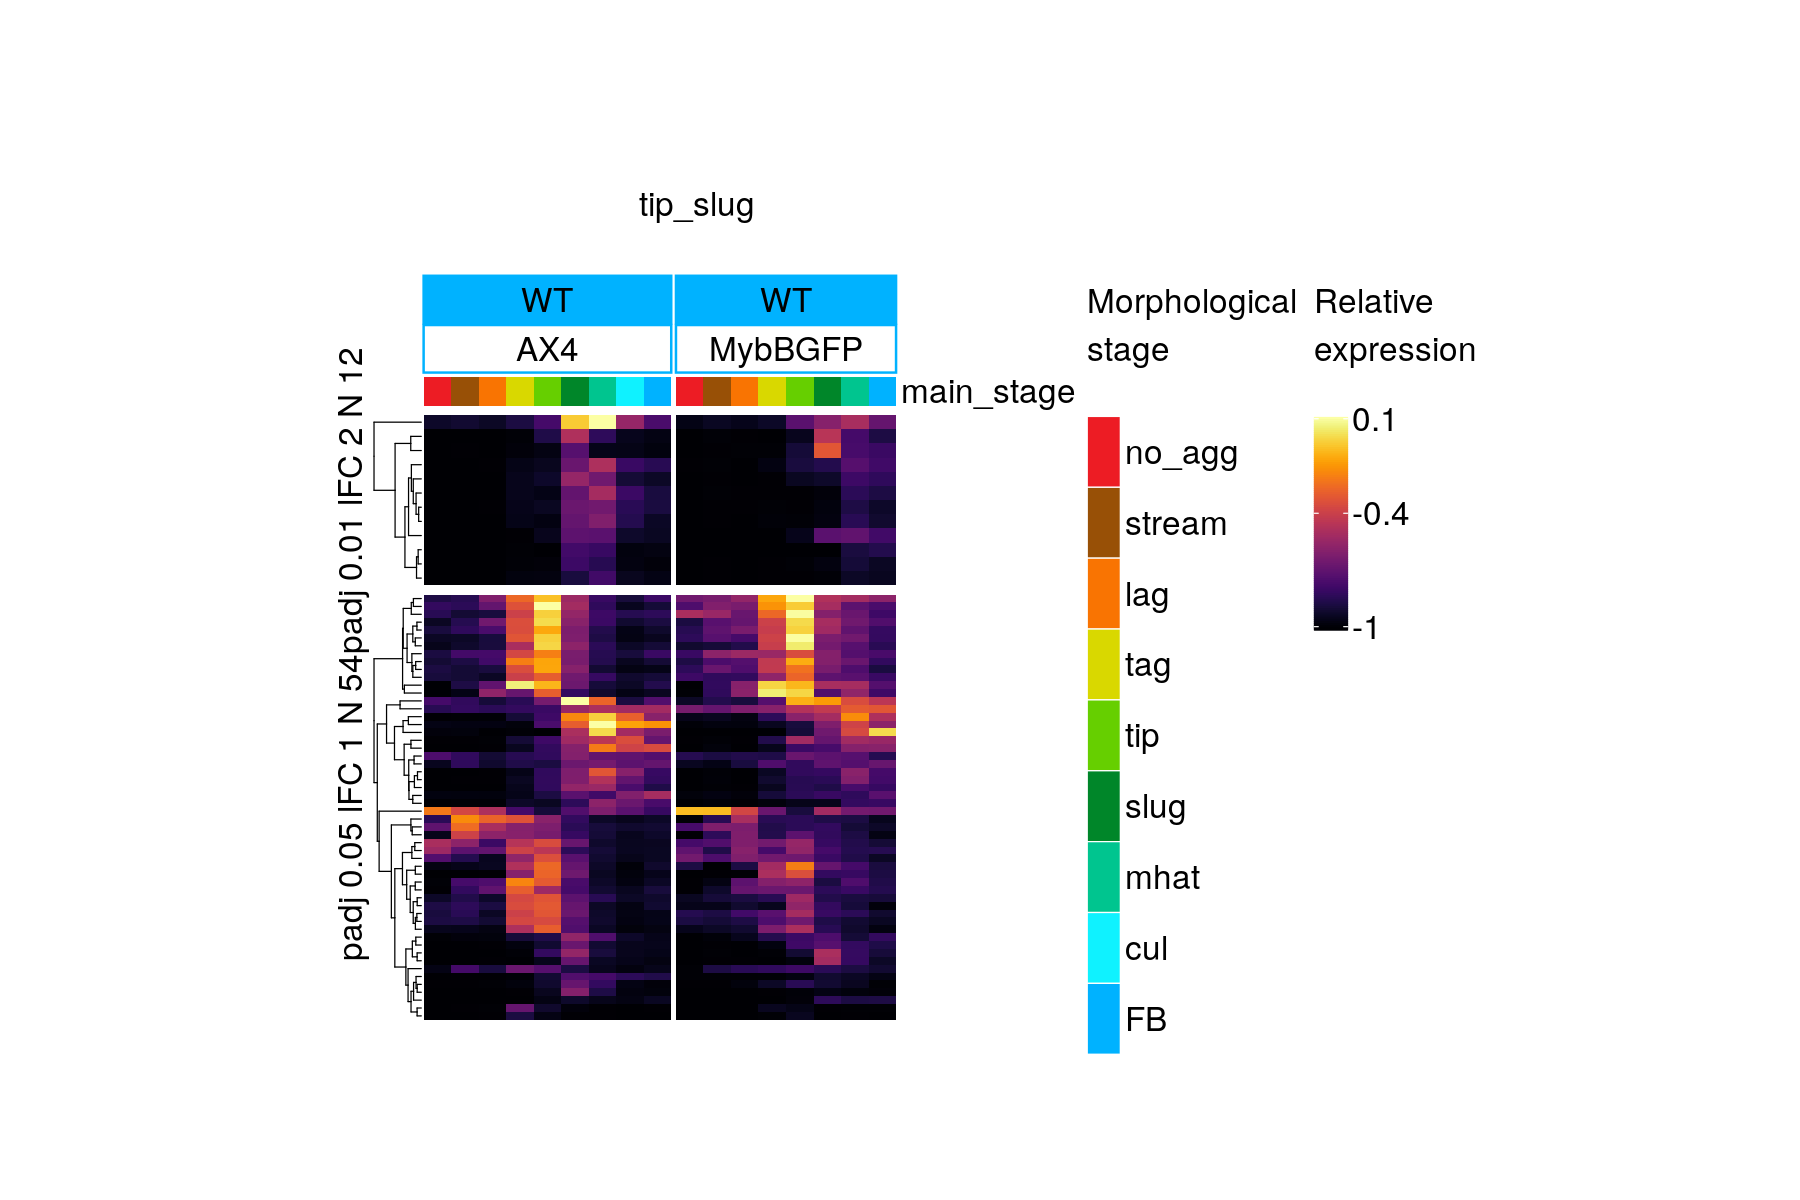

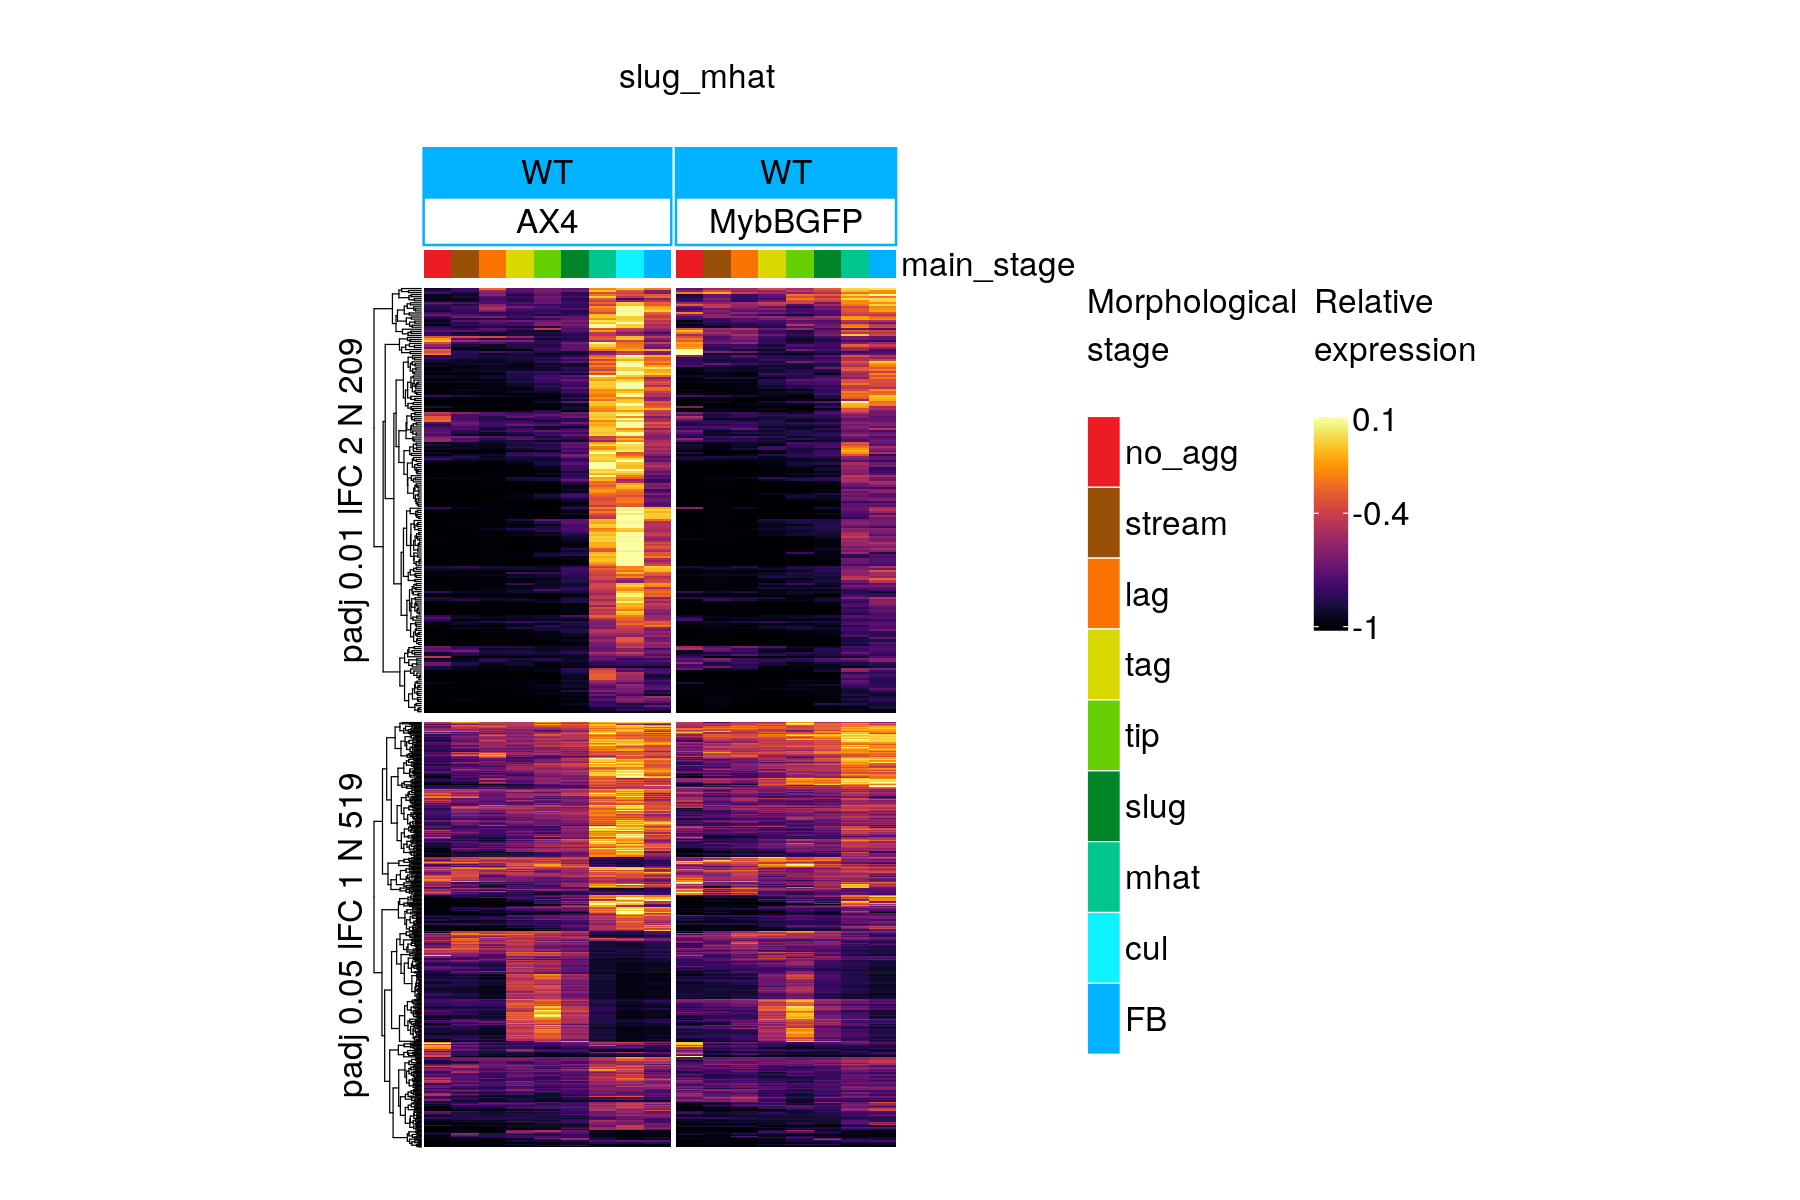

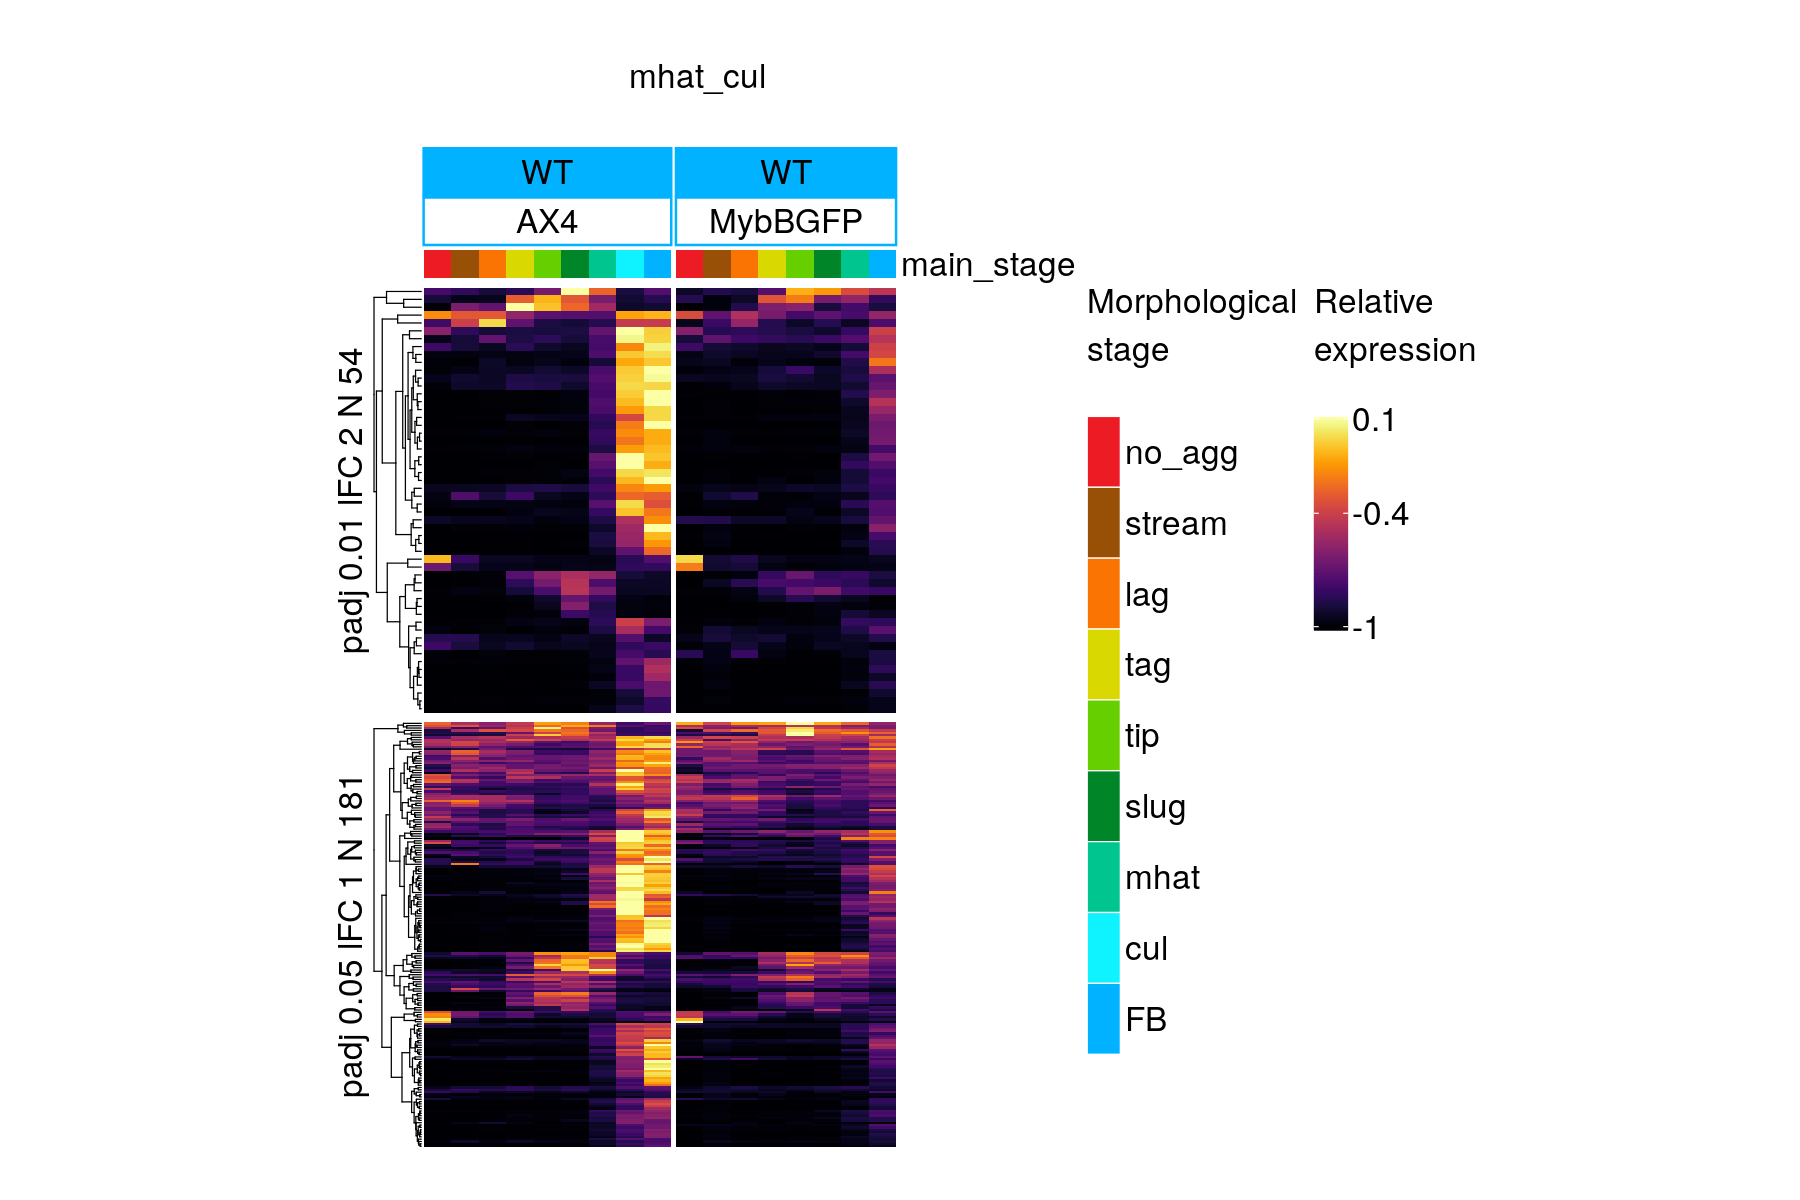

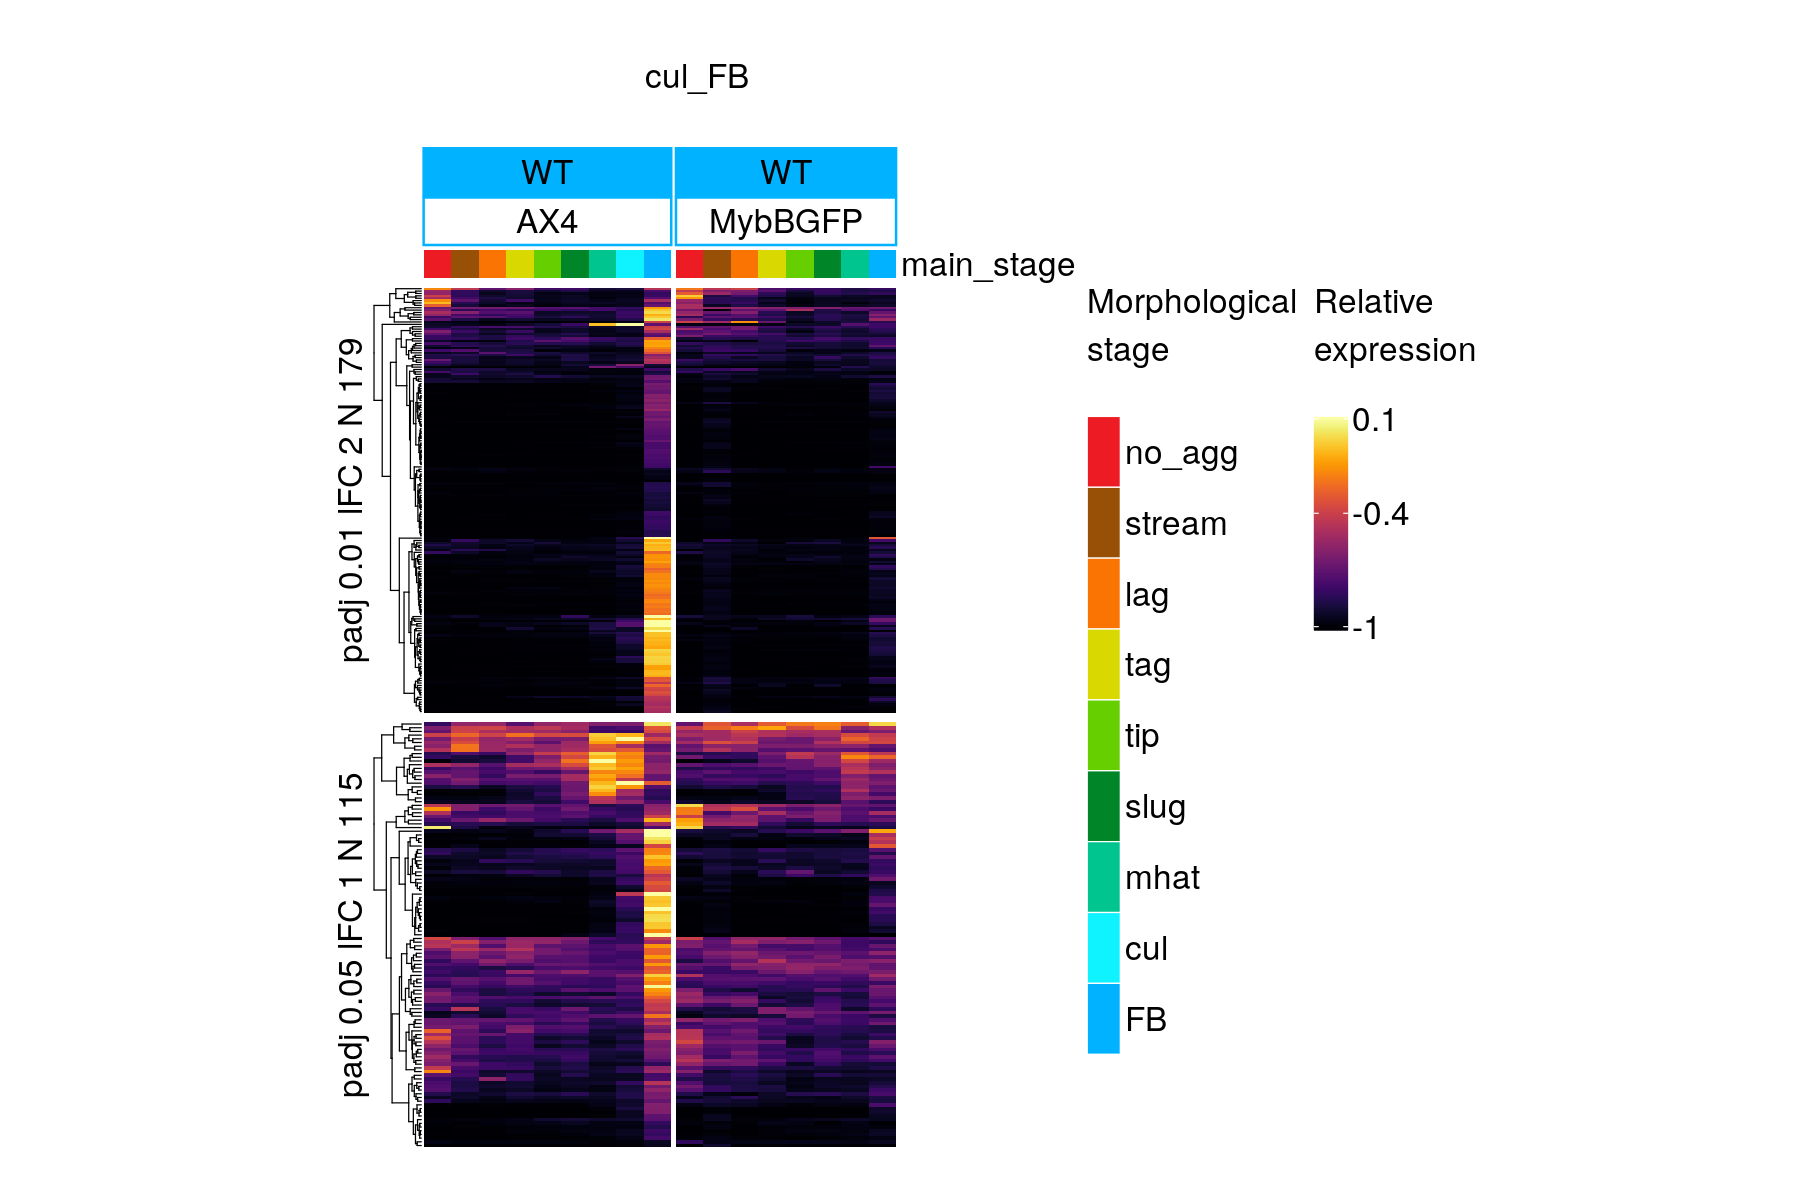

In [23]:
for (comparison in comparisons){
    fc_col=paste(comparison,'_log2FoldChange',sep='')
    fdr_col=paste(comparison,'_FDR_overall',sep='')
    data_defined=data_AX4_keepNA[!is.na(data_AX4_keepNA[fc_col]) & !is.na(data_AX4_keepNA[fdr_col]) & !is.na(data_AX4_keepNA[comparison]),]
    first=TRUE
    heatmaps=make_anno()
    for(param_idx in 1:nrow(params_data)){
        padj=params_data[param_idx,'padj_max'] 
        lfc=params_data[param_idx,'lfc_min']
        genes<-rownames(data_defined[abs(data_defined[fc_col])>=params_data[param_idx,'lfc_min'] & 
                        data_defined[fdr_col]<=params_data[param_idx,'padj_max'] &
                        data_defined[comparison]==1,])
        genes_previous=c()
        if (param_idx>1) genes_previous=rownames(
                        data_defined[abs(data_defined[fc_col])>=params_data[param_idx-1,'lfc_min'] & 
                        data_defined[fdr_col]<=params_data[param_idx-1,'padj_max'] &
                        data_defined[comparison]==1,])
        genes<-genes[which(!genes %in% genes_previous)]
    
        expression=t(avg_expression[avg_expression$Strain=='AX4',genes])
        #expression=t(avg_expression[,genes])
        distances<-dist(expression, method="cosine")
        hc<-hclust(d=distances, method = "ward.D2" )
        hc_ordered<-reorder(x=hc,dist = distances)
        genes<- as.dendrogram(hc_ordered) %>% labels

        n_genes=length(genes)
        #print(paste(comparison,n_genes))
        data_anno=paste('padj',params_data[param_idx,'padj_max'],'lFC',params_data[param_idx,'lfc_min'],'N',n_genes)
        height=0.3*n_genes
        if (height>9) height=9
        heatmap=Heatmap(t(avg_expression[,genes]),cluster_columns = FALSE,cluster_rows = TRUE,
                        show_column_names = FALSE,
                          show_row_names = FALSE, col=inferno(256),column_title=NULL, 
                          row_title=data_anno,
                          show_heatmap_legend = first,heatmap_legend_param = list(
                          title = "\nRelative \nexpression\n",
                          at = c(min_expression, round(mean(c(min_expression,max_expression)),1),max_expression),
                          grid_width= unit(legend_width, "cm"),grid_height= unit(legened_height, "cm") ,
                          labels_gp = gpar(fontsize = cluster_font),title_gp = gpar(fontsize = cluster_font)),
                          #** Cluster name fontsize
                          row_title_gp=gpar(fontsize=cluster_font),height=unit(height, "cm"))
        first=FALSE
        heatmaps = heatmaps %v% heatmap
    }
    draw(heatmaps,width=unit(10, "cm"),
            column_title =paste(comparison,'\n'),column_title_gp = gpar(fontsize = cluster_font))

}